# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [570]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import time
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

%matplotlib inline

## Initial Exploratory Data Analysis and Feature Engineering.

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### The portfolio data set

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.shape

(10, 6)

The portfolio data set contains meta data about various offers. We can convert the "channels" and "offer_type" columns into their respective dummies column for easier data handling.

In [11]:
web = []
email = []
mobile = []
social = []
for row in portfolio.itertuples():
    if "web" in row.channels:
        web.append(1)
    else:
        web.append(0)
    if "email" in row.channels:
        email.append(1)
    else:
        email.append(0)
    if  "mobile" in row.channels:
        mobile.append(1)
    else:
        mobile.append(0)
    if "social" in row.channels:
        social.append(1)
    else:
        social.append(0)
portfolio["channel_type_web"] = web
portfolio["channel_type_email"] = email
portfolio["channel_type_mobile"] = mobile
portfolio["channel_type_social"] = social

In [12]:
portfolio = pd.get_dummies(portfolio, columns=["offer_type"])

In [13]:
portfolio.drop(["channels"], axis=1, inplace=True)

In [14]:
portfolio.head()

,difficulty,duration,id,reward,channel_type_web,channel_type_email,channel_type_mobile,channel_type_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [15]:
portfolio

,difficulty,duration,id,reward,channel_type_web,channel_type_email,channel_type_mobile,channel_type_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [16]:
portfolio.to_csv("portfolio_checkpoint1.csv", index=False)

In [66]:
portfolio = pd.read_csv("portfolio_checkpoint1.csv")

### The transcript data set.

In [18]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
transcript.shape

(306534, 4)

The transcript data set contains various events that took place during this experiment. There are four types of events, as seen below. We can convert this column to dummies.

In [20]:
transcript["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The data type of "value" column depends on the "event" values, as demonstrated below. We can extract values according to the types of transactions, and create separate columns for each types of values.

In [21]:
transcript[transcript["event"] == "transaction"]["value"].head()

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
Name: value, dtype: object

In [22]:
transcript[transcript["event"] == "offer received"]["value"].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [23]:
transcript[transcript["event"] == "offer viewed"]["value"].head()

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [24]:
transcript[transcript["event"] == "offer completed"]["value"].head()

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
Name: value, dtype: object

In [25]:
# lists for dummies
transaction = []
offer_received = []
offer_viewed = []
offer_completed = []

offer_ids= []
transaction_amounts = []
complete_rewards = []

for row in transcript.itertuples():
    event = row.event
    
    if event == "transaction":
        transaction.append(1)
        transaction_amounts.append(row.value.get("amount"))
        
        
        offer_received.append(0)
        offer_viewed.append(0)
        offer_completed.append(0)
        offer_ids.append(None)
        complete_rewards.append(np.nan)

    elif event == "offer received":
        offer_received.append(1)
        offer_ids.append(row.value.get("offer id"))
        
        offer_viewed.append(0)
        offer_completed.append(0)
        transaction.append(0)
        transaction_amounts.append(np.nan)
        complete_rewards.append(np.nan)

    elif event == "offer viewed":
        offer_viewed.append(1)
        offer_ids.append(row.value.get("offer id"))
        
        offer_received.append(0)
        offer_completed.append(0)
        complete_rewards.append(np.nan)
        transaction.append(0)
        transaction_amounts.append(np.nan)
        
    else: # offer complete
        offer_completed.append(1)
        offer_ids.append(row.value.get("offer_id"))
        complete_rewards.append(row.value.get("reward"))
        
        offer_received.append(0)
        offer_viewed.append(0)
        transaction.append(0)
        transaction_amounts.append(np.nan)

transcript["event_type_offer_received"] = offer_received
transcript["event_type_offer_viewed"] = offer_viewed
transcript["event_type_transaction"] = transaction
transcript["event_type_offer_completed"] = offer_completed

transcript["offer_id"] = offer_ids
transcript["transaction_amount"] = transaction_amounts
transcript["reward_amount"] = complete_rewards



In [26]:
transcript.drop(["event", "value"], axis=1, inplace=True)

In [27]:
transcript.head()

,person,time,event_type_offer_received,event_type_offer_viewed,event_type_transaction,event_type_offer_completed,offer_id,transaction_amount,reward_amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [28]:
# cleaning up rounding errors
transcript["transaction_amount"] = transcript["transaction_amount"].apply(lambda x: round(x, 2))
transcript["reward_amount"] = transcript["reward_amount"].apply(lambda x: round(x, 2))

Maunually unit testing the transcript df dummies

In [29]:
transcript_copy = pd.read_json('data/transcript.json', orient='records', lines=True)

In [30]:
assert transcript[transcript["event_type_transaction"] == 1]["event_type_transaction"].count() == transcript_copy[transcript_copy["event"] == "transaction"]["event"].count(), "transaction counts are incorrect"
print("transaction test: pass")

assert transcript[transcript["event_type_offer_received"] == 1]["event_type_offer_received"].count() == transcript_copy[transcript_copy["event"] == "offer received"]["event"].count(), "offer received counts are incorrect"
print("offer received test: pass")

transcript[transcript["event_type_offer_viewed"] == 1]["event_type_offer_viewed"].count()  == transcript_copy[transcript_copy["event"] == "offer viewed"]["event"].count(), "offer viewed counts are incorrect"
print("offer viewed test: pass")

transcript[transcript["event_type_offer_completed"] == 1]["event_type_offer_completed"].count()  == transcript_copy[transcript_copy["event"] == "offer completed"]["event"].count(), "offer completed counts are incorrect"
print("offer completed test: pass")


transaction test: pass
offer received test: pass
offer viewed test: pass
offer completed test: pass


In [31]:
transcript.to_csv("transcript_checkpoint1.csv", index=False)

In [32]:
transcript = pd.read_csv("transcript_checkpoint1.csv")

There seems to be a wide range in the "transaction_amount" column. I am surprised to see that a customer paid more than \\$1000 on a single transaction! I assume these outlier transactions are catering customers for large events (like meetings, conventions, conferences, etc.), and such purchases will not be influenced by promotions (i.e. they will have to buy regardless of the promotion.) We'll identify these outliers using a hybrid (rule-based and statistics based) approach. 

Specifically, for a transaction to be considered an outlier, the transaction amount must exceed (1) a modified inter-quartile range (IQR) based threshold, and 2) a \\$50 threshold.  

The modified IQR was computed by first truncating the 20% of the highest transactions by amount from each customer's transaction record, then determining the twice the IQR value above their third quartile value. The reason to truncate the 20% of the highest transactions is that, in a data with an extremely large transaction, with only a few additional transactions (e.g. \\$2.50, \\$3.00, \\$1000.00), the IQR based threshold becomes significantly biased towards the large value, and in some cases, the threshold accidentally becomes larger than what obviously seems to be an outlier. 

The reason for the second criterion is that, when a customer has many small transactions, with another higher, but still seemingly normal amount, the relatively high amount will be flagged as an outlier. Consider this case where a customer spends \\$0.50, \\$0.50, \\$0.60, \\$0.60, and $5.00. In this case, the \\$5.00 transaction will become an outlier. To prevent this, we will set a second threshold of \\$50. If the threshold from the first step is below \\$50, then the final threshold will be set to \\$50.  


As we can see below, majority of the transaction amount falls below \\$50.

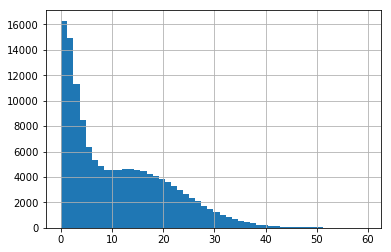

In [183]:
transcript[(transcript["event_type_transaction"] == 1) & (transcript["transaction_amount"] < 60)]["transaction_amount"].hist(bins=50);

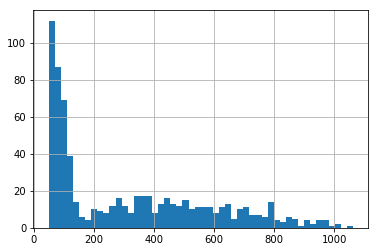

In [191]:
transcript[(transcript["event_type_transaction"] == 1) & (transcript["transaction_amount"] > 50) ]["transaction_amount"].hist(bins=50);

In [27]:
transcript["transaction_amount"].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: transaction_amount, dtype: float64

In [3]:
def record_outliers(customer_id, transcript=transcript):
    # record the outliers
    # the outlier detection is a hybrid rule-based/IQR method
    # using the IQR based outlier detection
    transaction_idx_list = []
    transaction_amount_list = []
    outlier_transaction_idxs = []
    outlier_list = ""
    df = transcript[(transcript["person"] == customer_id) & (transcript["event_type_transaction"] == 1)][["time", "transaction_amount"]].sort_values(by=["transaction_amount"])
    transaction_idx_list = df.index.values
    transaction_amount_list = df["transaction_amount"].values
    length = df.shape[0]
    if length > 1:
        df.drop(df.tail(math.ceil(length*0.2)).index, inplace=True)

    q3 = df["transaction_amount"].quantile(.75)
    q1 = df["transaction_amount"].quantile(.25)
    iqr = q3 - q1

    # using 3 times the IQR to prevent accidentally removing high-amount non-outliers
    iqr_high = q3 + (iqr * 2)
    # setting the lowest threshold to 50 (a simple rule to avoid detecting reasonable transactions as outliers for customers who usually spend very small amount) 
    if iqr_high < 50:
        iqr_high = 50.0
#     print("{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}".format(mean, q3, iqr, iqr_high))
#     print(iqr_high)
#     print(transaction_amount_list)
    for i in range(len(transaction_amount_list)):
        if transaction_amount_list[i] >= iqr_high:
#             print(transaction_amount_list[i])
            transcript.loc[transaction_idx_list[i], "outlier"] = 1

    return None

In [29]:
# create a column to indicate an outlier to be determined.
transcript["outlier"] = transcript["event_type_transaction"].apply(lambda x: np.nan if x == 0 else 0)

In [30]:
for row in tqdm(profile.itertuples(), total=profile.shape[0]):
    record_outliers(row.id)

In [31]:
transcript[(transcript["outlier"]) == 1]["transaction_amount"].describe()

count     700.000000
mean      319.280729
std       262.821634
min        50.030000
25%        85.172500
50%       246.185000
75%       514.200000
max      1062.280000
Name: transaction_amount, dtype: float64

In [32]:
transcript.to_csv("transcript_checkpoint2.csv", index=False)

In [34]:
transcript = pd.read_csv("transcript_checkpoint2.csv")

In [34]:
transcript.sample(15)

,person,time,event_type_offer_received,event_type_offer_viewed,event_type_transaction,event_type_offer_completed,offer_id,transaction_amount,reward_amount,outlier
145511,3063fd31679246569290695afa24f5b8,390,0,0,1,0,NaN,2.73,NaN,0.0
298441,f1dd0a48888a4af4936a445ce4134356,678,0,0,1,0,NaN,16.45,NaN,0.0
295980,44750d9c9cec4dedbcc5cc6de4dae6f2,666,0,0,1,0,NaN,12.83,NaN,0.0
214581,2eab0e7827794dba9634144fb7722379,504,0,0,0,1,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,NaN
62256,5a2ee75088994187bed4cb8404acb54a,168,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
79356,fdcb232e66d8452d9cd914e2770c9a00,192,0,0,1,0,NaN,0.94,NaN,0.0
23328,6091d5074b14477c8e9740f4daf6e978,24,0,0,1,0,NaN,9.31,NaN,0.0
51271,43ed353933c144caa4efffd219bb17a1,150,0,0,1,0,NaN,27.61,NaN,0.0
2359,a18461ce01d340eb8704bf7fb692c6ba,0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
40725,b2f79fa7cb3f48c984dfe5df60d04e74,90,0,0,1,0,NaN,15.17,NaN,0.0


### The profile data set.

In [35]:
profile.shape

(17000, 5)

In [36]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


I assume that the huge spike for 118 year old customers are default value indicating customers who did not enter their age. I will replace it with nan's. 

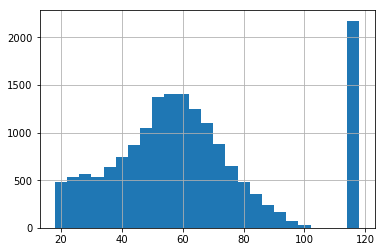

In [37]:
profile["age"].hist(bins=25);

In [38]:
profile["age"].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [35]:
profile["age"] = profile["age"].replace([118], np.nan)

The "became member on" column looks like a date in a form of yyyymmdd. Will convert it to yyyy-mm-dd format, and also compute the days each customers have been with Starbucks. We will use the latest recorded date in the "became_member_on" column as a reference date.

In [36]:
profile["became_member_on"].max() # getting the last date a customer has joined in this dataset

20180726

In [37]:
ref_date = datetime.datetime(2018, 7, 26) # using the last date joined as a reference date to compute the customer tenure length

In [38]:
tenure_lengths = []
joined_dates = []
for row in profile.itertuples():
    date = row.became_member_on
    joined_date = datetime.datetime(int(str(date)[0:4]), int(str(date)[4:6]), int(str(date)[6:8]))
    days_delta = ref_date - joined_date
    days_delta = days_delta.days
    tenure_lengths.append(days_delta)
    joined_dates.append(joined_date)
profile["tenure_length"] = tenure_lengths
profile["joined_date"] = joined_dates

In [39]:
profile.drop(["became_member_on"], axis=1, inplace=True)

In [44]:
profile.head()

,age,gender,id,income,tenure_length,joined_date
0,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15
2,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09
4,NaN,None,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04


In [45]:
profile["tenure_length"].describe()

count    17000.000000
mean       517.449882
std        411.223904
min          0.000000
25%        208.000000
50%        358.000000
75%        791.000000
max       1823.000000
Name: tenure_length, dtype: float64

Next, we will convert the gender to dummies.

In [40]:
gender_dummies = pd.get_dummies(profile["gender"])

In [41]:
gender_dummies.columns = ["female", "male", "other"]

In [42]:
profile = pd.concat([profile, gender_dummies], axis=1)

In [43]:
profile.drop("gender", axis=1, inplace=True)

In [50]:
profile.head()

,age,id,income,tenure_length,joined_date,female,male,other
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0


We can summarize the transactions for each customers to obtain a total transaction amount and a total reward amount.

In [51]:
total_transaction_amounts = []
total_reward_amounts = []
for row in tqdm(profile.itertuples(), total=profile.shape[0]):
    total_transaction_amounts.append(transcript[transcript["person"] == row.id]["transaction_amount"].sum())
    total_reward_amounts.append(transcript[transcript["person"] == row.id]["reward_amount"].sum())

In [52]:
profile["total_transaction_amount"] = total_transaction_amounts
profile["total_reward_amount"] = total_reward_amounts

In [53]:
profile.head()

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0,20.40,5.0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0,77.01,5.0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0,14.30,0.0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0,159.27,20.0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0,4.65,0.0


In [54]:
profile.to_csv("profile_checkpoint1.csv", index=False)

In [44]:
profile = pd.read_csv("profile_checkpoint1.csv")

In [56]:
profile.sample(15)

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount
3564,NaN,3cbbefdc6db148d88acf8944bd77c48d,NaN,744,2016-07-12,0,0,0,52.38,4.0
13674,35.0,6f4dce8dbb044c0eb773d40fb2604bc3,31000.0,86,2018-05-01,1,0,0,56.94,22.0
14121,66.0,577c19a3495947d8bace5f3f7ad4f0ed,55000.0,425,2017-05-27,1,0,0,52.94,0.0
12333,NaN,effbbf2f8081437eb1fa22e17dd84038,NaN,183,2018-01-24,0,0,0,24.25,10.0
5629,65.0,19eff2554d094649a115ea5320dd9e8a,90000.0,163,2018-02-13,0,1,0,81.90,10.0
7767,NaN,14b3c3a8b314464a9daf8354ed6dd560,NaN,351,2017-08-09,0,0,0,10.73,0.0
9427,25.0,de5a7b09cf5140c9a5b2827a7e04c808,53000.0,1470,2014-07-17,1,0,0,67.40,15.0
11248,66.0,5b5888cf8fb346378ff0f3d42139a9db,71000.0,42,2018-06-14,0,1,0,20.30,5.0
1307,20.0,aef583f3c3614f9e96d7940df55510b2,75000.0,90,2018-04-27,0,1,0,13.84,5.0
16748,60.0,9250d51a392f4f2691eabff6851dcf66,67000.0,605,2016-11-28,1,0,0,497.35,5.0


In this step, we will do a bulk of feature engineering as listed below:

1) generate new features to go into the profile data, which will be derived from the transcript and the portfolio data. The new features to be added are:

The number of hours each types of offers (discount/bogo/informational) were active: "discount_active_hours", etc.
The number of hours no promotions were active: "no_promotions_hours"
The number of hours the customer was aware of each types of offers: "discount_aware_hours", etc.
The number of transactions that took place while the customer was aware of each types of offers: "discount_transaction_count", etc.
The number of transactions while no promotions were in effect: "no_promotions_transactions_count"
The total amount spent while the customer was aware of each types of offers: "discount_spending_amount", etc.
The total amount spent while no promotions were in effect: "no_promotions_spending_amount"
The total amount of outlier transactions: "outlier_spending_amount"
The total number of outlier counts: "outlier_count"
The total number of hours where multiple offers were in effect at the same time: "overlap_hours"
The maximum number of offers that overlapped: "max_overlap" 
The average spending per hour while no promotions were active: "no_promotions_spending_per_hour_aware"
The ratio of discount and bogo aware/active hours to no promotions aware hours: "discount_bogo_to_no_promotions_hours_ratio_aware", etc.
The average of the view to end time for informational offers: "informational_avg_view_to_end_time"


2) create another dataframe called "offers", which consolidates the transactions recorded in transcript. An observation in offers dataframe contains the id of a customer who received the offer ("customer_id"), the id of the offer ("offer_id"), the  offer received time, viewed time, completed time, and end time (four rows in transcirpt), as well as the sum of the transaction amount that took place while a customer was aware of the corresponding offer ("transaction_amount_sum"), an average spending amount per hour while the customer was aware of the offer ("spending_per_hour"), time between the received and the viewed time stamps ("receive_to_view_time"), time between the viewed and teh completed time ("view_to_complete_time"), whether a specific offer was successfully completed ("success"), as well as the dummies of the channel in which the offers were distributed ("web", "email", "mobile", and "social".)

In [57]:
profile.head(15)

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0,20.40,5.0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0,77.01,5.0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0,14.30,0.0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0,159.27,20.0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0,4.65,0.0
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,2018-04-26,0,1,0,57.73,7.0
6,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,304,2017-09-25,0,0,0,0.00,0.0
7,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,297,2017-10-02,0,0,0,0.24,0.0
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,2018-02-09,0,1,0,36.43,19.0
9,NaN,8974fc5686fe429db53ddde067b88302,NaN,611,2016-11-22,0,0,0,15.62,5.0


In [45]:
transcript["no_promotions_transaction"] = np.nan
transcript["no_promotions_transaction"] = transcript["event_type_transaction"].apply(lambda x: 0 if x == 1 else np.nan)

In [4]:
def compute_successful_offers(customer_id, transcript=transcript, portfolio=portfolio):
    
    offer_type = '' 
    offer_ids = []
    offer_received_times = []
    offer_viewed_times = []
    offer_completed_times = []
    offer_end_times = []
    offer_types = []
    offer_thresholds = []
    total_transaction_amounts = []
    spendings_per_hour = []
    receive_to_view_times = []
    view_to_complete_times = []
    success = []
    web = []
    email = []
    mobile = []
    social = []

    df_single_customer_transcript = transcript[(transcript["person"] == customer_id)]
    
    received_offers = transcript[(transcript["person"] == customer_id) & (transcript["event_type_offer_received"] == 1)]["offer_id"]

    total_offers_count = received_offers.count()

    # select the offers that worked
    for idx, offer_id in received_offers.items():
        
        # determine the offer type
        if (portfolio[(portfolio["id"] == offer_id)]["offer_type_discount"].values)[0] == 1:
            offer_type = "discount"
        elif (portfolio[(portfolio["id"] == offer_id)]["offer_type_bogo"].values)[0] == 1:
            offer_type = "bogo"
        elif (portfolio[(portfolio["id"] == offer_id)]["offer_type_informational"].values)[0] == 1:
            offer_type = "informational"
        
        # get the time when an offer was received
        offer_start_time = transcript.iloc[idx, 1] 
        
        # get the length of time the offer is in effect
        offer_effective_days = portfolio[portfolio["id"] == offer_id]["duration"].values[0]

        # get the amount of transaction needed to complete the offer
        offer_threshold = portfolio[portfolio["id"] == offer_id]["difficulty"].values[0]
        offer_thresholds.append(offer_threshold)
        
        # calculate the time the offer expires
        offer_end_time = offer_start_time + offer_effective_days * 24

        # get the time the offer was viewed, if such an event takes place
        offer_viewed_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_viewed"] == 1) & (df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time)]["time"].values

        # record completed time, except for informational offers as they have no complete time stamps
        if offer_type != "informational":
            offer_completed_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_completed"] == 1) & (df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time)]["time"].values
        
        # get the time and amount of transactions, if they take place
        transaction_amount_sum = df_single_customer_transcript[(df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time) & (df_single_customer_transcript["event_type_transaction"] == 1) & (df_single_customer_transcript["outlier"] == 0)]["transaction_amount"].sum()
        total_transaction_amounts.append(transaction_amount_sum)
            
        # Record offer information
        offer_ids.append(offer_id)
        offer_received_times.append(offer_start_time)
        offer_end_times.append(offer_end_time)
        offer_types.append(offer_type)

        # if the view time is same as or after the start time, record relevant values
        if len(offer_viewed_time) > 0 and offer_viewed_time[0] >= offer_start_time:
            offer_viewed_times.append(offer_viewed_time[0])
            receive_to_view_times.append(offer_viewed_time[0] - offer_start_time)
        # else record as NaN
        elif len(offer_viewed_time) == 0:
            offer_viewed_times.append(np.nan)
            receive_to_view_times.append(np.nan)
 
        # if discount or bogo, and the completed time is same as or before the end time, record relevant values
        if offer_type != "informational" and len(offer_completed_time) > 0 and offer_completed_time[0] <= offer_end_time:
            offer_completed_times.append(offer_completed_time[0])
            # and if the completed time is same as or after the view time, calculate teh view to complete time 
            if len(offer_viewed_time) > 0 and offer_viewed_time[0] <= offer_completed_time[0]:
                view_to_complete_times.append(offer_completed_time[0] - offer_viewed_time[0])
            else:
                view_to_complete_times.append(np.nan)
        # else record as NaN
        else:
            offer_completed_times.append(np.nan)
            view_to_complete_times.append(np.nan)
            
        # calculate the spending per hour
        if offer_type != "informational" and len(offer_completed_time) > 0 and len(offer_viewed_time) > 0 and offer_viewed_time[0] < offer_completed_time[0]:
            finish_time = offer_completed_time[0]
        elif offer_type != "informational":
            finish_time = offer_end_time    
            
        if offer_type != "informational" and len(offer_completed_time) > 0:
            spending_per_hour = transaction_amount_sum / (finish_time - offer_start_time)
        elif offer_type != "informational" and len(offer_completed_time) == 0:
            spending_per_hour = np.nan
        elif offer_type == "informational" and len(offer_viewed_time) > 0:
            spending_per_hour = transaction_amount_sum / (offer_end_time - offer_start_time)
        elif offer_type == "informational" and len(offer_viewed_time) == 0:
            spending_per_hour = np.nan
            
        spendings_per_hour.append(spending_per_hour)
        
        # Determine the sources of the offer
        web.append((portfolio[portfolio["id"] == offer_id]["channel_type_web"].values)[0])
        email.append((portfolio[portfolio["id"] == offer_id]["channel_type_email"].values)[0])
        mobile.append((portfolio[portfolio["id"] == offer_id]["channel_type_mobile"].values)[0])
        social.append((portfolio[portfolio["id"] == offer_id]["channel_type_social"].values)[0])

    
    # create a time table to fill when offers were in effect
    number_of_days = 30
    duration_hours = number_of_days * 24
    # create an empty time table
    df_timetable = pd.DataFrame(0, index=np.arange(duration_hours), columns=["discount_active", "bogo_active", "informational_active", "discount_aware", "bogo_aware", "informational_aware", "no_promotions", "transaction", "transaction_amount", "outlier_transaction"])

    # record the discount, bogo, informational offers in effect
    for i in range(len(offer_types)):
        offer_type = offer_types[i]
        start_time = offer_received_times[i]
        view_time = offer_viewed_times[i]
        end_time = offer_end_times[i]
        completed_time = offer_completed_times[i]
        if np.isnan(completed_time):
            completed_time = end_time
            
        if offer_type == "discount":
            df_timetable.loc[start_time:end_time, "discount_active"] += 1
            df_timetable.loc[view_time:completed_time, "discount_aware"] += 1
        elif offer_type == "bogo":
            df_timetable.loc[start_time:end_time, "bogo_active"] += 1
            df_timetable.loc[view_time:completed_time, "bogo_aware"] += 1
        else:
            df_timetable.loc[start_time:end_time, "informational_active"] += 1
            df_timetable.loc[view_time:end_time, "informational_aware"] += 1
     
    # calculate when a customer is not aware of any offers (including discount, bogo, or informational)
    df_timetable["no_promotions"] = np.where(((df_timetable["discount_aware"] + df_timetable["bogo_aware"] + df_timetable["informational_aware"]) == 0), 1, 0)
     
    # add the customer's transaction history and amount
    transaction_times = df_single_customer_transcript[df_single_customer_transcript["event_type_transaction"] == 1]["time"].values
    transaction_amounts = df_single_customer_transcript[df_single_customer_transcript["event_type_transaction"] == 1]["transaction_amount"].values
    outlier_transactions = df_single_customer_transcript[df_single_customer_transcript["outlier"] == 1]["time"].values
     
    for i in range(len(transaction_times)):
        df_timetable.loc[transaction_times[i], "transaction"] = 1
        df_timetable.loc[transaction_times[i], "transaction_amount"] = transaction_amounts[i]

    for i in range(len(outlier_transactions)):
        df_timetable.loc[outlier_transactions[i], "outlier_transaction"] = 1
     
    no_promotions_hours = df_timetable[(df_timetable["no_promotions"] == 1)]["no_promotions"].count()
    no_promotions_transaction_amount = df_timetable[(df_timetable["no_promotions"] == 1) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()
    
    # Record transactions that took place during no promotions period
    no_promotions_transactions_idxs = df_timetable[(df_timetable["transaction"] == 1) & (df_timetable["no_promotions"] == 1)].index.values
    for i in no_promotions_transactions_idxs:
        transcript_idx = transcript[(transcript["person"] == customer_id) & (transcript["time"] == i) & (transcript["event_type_transaction"] == 1)].index.values[0] # here, the i is the index of the timetable, but it is also the time stamp in the transcript, so I'm using it as a filter 
        transcript.loc[transcript_idx, "no_promotions_transaction"] = 1
    
    if no_promotions_hours > 0:
        no_promotions_spending_per_hour = no_promotions_transaction_amount / no_promotions_hours
    elif no_promotions_hours == 0:
        no_promotions_spending_per_hour = np.nan
       
    for i in range(len(offer_ids)):         
        # check if the offer was effective:
        offer_type = offer_types[i]
        
        # discounts/bogos: offer is viewed, viewed after start, completed after the view, completed before the end, the transaction sum minus the outlier exceeds the offer threshold
        if offer_type != "informational" and (not math.isnan(offer_viewed_times[i])) and (not math.isnan(offer_completed_times[i])) and offer_received_times[i] <= offer_viewed_times[i] and offer_viewed_times[i] <= offer_completed_times[i] and offer_completed_times[i] <= offer_end_times[i] and total_transaction_amounts[i] >= offer_thresholds[i]:
            success.append(1)
        # informationals: offer was viewed, and transaction amount is greater than 0.0 and the spending per hour is greater than the non-promotional spending per hour 
        elif offer_type == "informational" and (not math.isnan(offer_viewed_times[i])) and offer_received_times[i] <= offer_viewed_times[i] and offer_viewed_times[i] <= offer_end_times[i] and total_transaction_amounts[i] > 0 and spendings_per_hour[i] > no_promotions_spending_per_hour:
            success.append(1)
        else:
            success.append(0)
     
    # Wrap the results inside a dictionary
    offer_results = {
        "offer_ids": tuple(offer_ids),
        "offer_received_times": tuple(offer_received_times),
        "offer_viewed_times": tuple(offer_viewed_times),
        "offer_completed_times": tuple(offer_completed_times),
        "offer_end_times": tuple(offer_end_times),
        "offer_types": tuple(offer_types),
        "total_transaction_amount": tuple(total_transaction_amounts),
        "spendings_per_hour": tuple(spendings_per_hour),
        "receive_to_view_times": tuple(receive_to_view_times),
        "view_to_complete_times": tuple(view_to_complete_times),
        "success": tuple(success),
        "web": tuple(web),
        "email": tuple(email),
        "mobile": tuple(mobile),
        "social": tuple(social)
    }

    no_promotions_results = {
        "no_promotions_hours": no_promotions_hours,
        "no_promotions_transaction_amount": no_promotions_transaction_amount,
        "no_promotions_spending_per_hour": no_promotions_spending_per_hour
    }

    return offer_results, no_promotions_results, df_timetable
    

In [5]:
def compute_additional_customer_features(customer_id, transcript=transcript, profile=profile):
    df_single_customer_transcript = transcript[(transcript["person"] == customer_id)]
    df_customer_transactions = pd.DataFrame(columns=["customer_id"]) 

    # get a list of offers a customer has received
    offer_results, no_promotions_results, df_timetable = compute_successful_offers(customer_id)
    
    df_customer_transactions["offer_id"] = offer_results["offer_ids"]
    df_customer_transactions["received_time"] = offer_results["offer_received_times"]
    df_customer_transactions["viewed_time"] = offer_results["offer_viewed_times"]
    df_customer_transactions["completed_time"] = offer_results["offer_completed_times"]
    df_customer_transactions["end_time"] = offer_results["offer_end_times"]
    df_customer_transactions["offer_type"] = offer_results["offer_types"]
    df_customer_transactions["transaction_amount_sum"] = offer_results["total_transaction_amount"]
    df_customer_transactions["spending_per_hour"] = offer_results["spendings_per_hour"]
    df_customer_transactions["receive_to_view_time"] = offer_results["receive_to_view_times"]
    df_customer_transactions["view_to_complete_time"] = offer_results["view_to_complete_times"]
    df_customer_transactions["success"] = offer_results["success"]
    df_customer_transactions["web"] = offer_results["web"]
    df_customer_transactions["email"] = offer_results["email"]
    df_customer_transactions["mobile"] = offer_results["mobile"]
    df_customer_transactions["social"] = offer_results["social"]
    df_customer_transactions["customer_id"] = customer_id
    
    
    # calculate new feature values
    discount_active_hours = df_timetable[(df_timetable["discount_active"] > 0)]["discount_active"].count()
    bogo_active_hours = df_timetable[(df_timetable["bogo_active"] > 0)]["bogo_active"].count()
    informational_active_hours = df_timetable[(df_timetable["informational_active"] > 0)]["informational_active"].count()
    no_promotions_hours = df_timetable[(df_timetable["no_promotions"] > 0)]["no_promotions"].count()
    discount_aware_hours = df_timetable[(df_timetable["discount_aware"] > 0)]["discount_aware"].count()
    bogo_aware_hours = df_timetable[(df_timetable["bogo_aware"] > 0)]["bogo_aware"].count()
    informational_aware_hours = df_timetable[(df_timetable["informational_aware"] > 0)]["informational_aware"].count()
    discount_transaction_counts = df_timetable[(df_timetable["discount_aware"] > 0) & (df_timetable["transaction"] == 1)]["discount_aware"].count()
    bogo_transaction_counts = df_timetable[(df_timetable["bogo_aware"] > 0) & (df_timetable["transaction"] == 1)]["bogo_aware"].count()
    informational_transaction_counts = df_timetable[(df_timetable["informational_aware"] > 0) & (df_timetable["transaction"] == 1)]["informational_aware"].count()
    no_promotions_transaction_counts = df_timetable[(df_timetable["no_promotions"] > 0) & (df_timetable["transaction"] == 1)]["no_promotions"].count()
    
    discount_transaction_amount = df_timetable[(df_timetable["discount_aware"] > 0) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()
    bogo_transaction_amount = df_timetable[(df_timetable["bogo_aware"] > 0) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()  
    informational_transaction_amount = df_timetable[(df_timetable["informational_aware"] > 0) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()
    no_promotions_transaction_amount = df_timetable[(df_timetable["no_promotions"] > 0) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()
    outlier_transaction_amount =  df_timetable[(df_timetable["outlier_transaction"] == 1)]["transaction_amount"].sum()
    outlier_count = df_timetable[(df_timetable["outlier_transaction"] == 1)]["transaction_amount"].count()
    overlap_hours = df_timetable[((df_timetable["discount_active"] + df_timetable["bogo_active"]) > 1)]["discount_active"].count()
    max_overlap = (df_timetable["discount_active"] + df_timetable["bogo_active"]).max()
    no_promotional_average_spending_aware = no_promotions_results["no_promotions_spending_per_hour"]
    
    view_to_end_times = []
    for i in range(len(offer_results["offer_ids"])):
        if offer_results["offer_types"][i] == "informational" and not np.isnan(offer_results["offer_viewed_times"][i]):
            view_to_end_times.append(offer_results["offer_end_times"][i] - offer_results["offer_viewed_times"][i])
    if len(view_to_end_times) > 0:
        informational_avg_view_to_end_time = sum(view_to_end_times) / len(view_to_end_times)
    else:
        informational_avg_view_to_end_time = np.nan
    
    additional_features = {
        "discount_active_hours": discount_active_hours,
        "bogo_active_hours": bogo_active_hours,
        "informational_active_hours": informational_active_hours,
        "no_promotions_hours": no_promotions_hours,
        "discount_aware_hours": discount_aware_hours,
        "bogo_aware_hours": bogo_aware_hours,
        "informational_aware_hours": informational_aware_hours,
        "discount_transaction_counts": discount_transaction_counts,
        "bogo_transaction_counts": bogo_transaction_counts,
        "informational_transaction_counts": informational_transaction_counts,
        "no_promotions_transaction_counts": no_promotions_transaction_counts,
        "discount_transaction_amount": discount_transaction_amount,
        "bogo_transaction_amount": bogo_transaction_amount,
        "informational_transaction_amount": informational_transaction_amount,
        "no_promotions_transaction_amount": no_promotions_transaction_amount,
        "overlap_hours": overlap_hours,
        "max_overlap": max_overlap, 
        "outlier_transaction_amount": outlier_transaction_amount,
        "outlier_count": outlier_count, 
        "no_promotional_average_spending_aware": no_promotional_average_spending_aware,
        "informational_avg_view_to_end_time": informational_avg_view_to_end_time
    }
    
    return additional_features, df_customer_transactions

In [48]:
discount_active_hours_list = []
bogo_active_hours_list = []
informational_active_hours_list = []
no_promotions_hours_list = []
discount_aware_hours_list = []
bogo_aware_hours_list = []
informational_aware_hours_list = []
discount_transaction_count_list = []
bogo_transaction_count_list = []
informational_transaction_count_list = []
no_promotions_transaction_count_list = []
discount_spending_amount_list = []
bogo_spending_amount_list = []
informational_spending_amount_list = []
no_promotions_spending_amount_list = []
overlap_hours_list = []
max_overlap_list = []
outlier_transaction_amount_list = []
outlier_count_list = []
no_promotions_avg_spending_list = []
discount_bogo_to_no_promotions_hours_ratio_aware_list = []
discount_bogo_to_no_promotions_hours_ratio_active_list = []
informational_avg_view_to_end_time_list = []

offers = pd.DataFrame()

for row in tqdm(profile.itertuples(), total=profile.shape[0]):
    additional_features, df_customer_transaction = compute_additional_customer_features(row.id)

    offers = pd.concat([offers, df_customer_transaction], axis=0, ignore_index=True)
    
    discount_active_hours = additional_features["discount_active_hours"]
    bogo_active_hours = additional_features["bogo_active_hours"]
    no_promotions_hours = additional_features["no_promotions_hours"]
    discount_aware_hours = additional_features["discount_aware_hours"]
    bogo_aware_hours = additional_features["bogo_aware_hours"]
    
    discount_active_hours_list.append(discount_active_hours)
    bogo_active_hours_list.append(bogo_active_hours)
    informational_active_hours_list.append(additional_features["informational_active_hours"])
    no_promotions_hours_list.append(no_promotions_hours)
    discount_aware_hours_list.append(discount_aware_hours)
    bogo_aware_hours_list.append(bogo_aware_hours)
    informational_aware_hours_list.append(additional_features["informational_aware_hours"])
    discount_transaction_count_list.append(additional_features["discount_transaction_counts"])
    bogo_transaction_count_list.append(additional_features["bogo_transaction_counts"])
    informational_transaction_count_list.append(additional_features["informational_transaction_counts"])
    no_promotions_transaction_count_list.append(additional_features["no_promotions_transaction_counts"])
    discount_spending_amount_list.append(additional_features["discount_transaction_amount"])
    bogo_spending_amount_list.append(additional_features["bogo_transaction_amount"])
    informational_spending_amount_list.append(additional_features["informational_transaction_amount"])
    no_promotions_spending_amount_list.append(additional_features["no_promotions_transaction_amount"])
    overlap_hours_list.append(additional_features["overlap_hours"])
    max_overlap_list.append(additional_features["max_overlap"])
    outlier_transaction_amount_list.append(additional_features["outlier_transaction_amount"])
    outlier_count_list.append(additional_features["outlier_count"])
    no_promotions_avg_spending_list.append(additional_features["no_promotional_average_spending_aware"])
    informational_avg_view_to_end_time_list.append(additional_features["informational_avg_view_to_end_time"])
    
    if no_promotions_hours > 0:
        discount_bogo_to_no_promotions_hours_aware = (discount_aware_hours + bogo_aware_hours) / no_promotions_hours
        discount_bogo_to_no_promotions_hours_active = (discount_active_hours + bogo_active_hours) / no_promotions_hours
    elif no_promotions_hours == 0:
        # if a customer had no promotion hours at all, devide discount and bogo hours by one instead of zero
        discount_bogo_to_no_promotions_hours_aware = (discount_aware_hours + bogo_aware_hours) / 1
        discount_bogo_to_no_promotions_hours_active = (discount_active_hours + bogo_active_hours) / 1
        
    discount_bogo_to_no_promotions_hours_ratio_aware_list.append(discount_bogo_to_no_promotions_hours_aware)
    discount_bogo_to_no_promotions_hours_ratio_active_list.append(discount_bogo_to_no_promotions_hours_active)


In [51]:
profile["discount_active_hours"] = discount_active_hours_list
profile["bogo_active_hours"] = bogo_active_hours_list
profile["informational_active_hours"] = informational_active_hours_list 
profile["no_promotions_hours"] = no_promotions_hours_list
profile["discount_aware_hours"] = discount_aware_hours_list
profile["bogo_aware_hours"] = bogo_aware_hours_list
profile["informational_aware_hours"] = informational_aware_hours_list 
profile["discount_transaction_count"] = discount_transaction_count_list # number of transactions that took place while the customer was aware of discount offers
profile["bogo_transaction_count"] = bogo_transaction_count_list # number of transactions that took place while the customer was aware of bogo offers
profile["informational_transaction_count"] = informational_transaction_count_list # number of transactions that took place while the customer was aware of informational offers
profile["no_promotions_transaction_count"] = no_promotions_transaction_count_list 
profile["discount_spending_amount"] = discount_spending_amount_list
profile["bogo_spending_amount"] = bogo_spending_amount_list
profile["informational_spending_amount"] = informational_spending_amount_list
profile["no_promotions_spending_amount"] = no_promotions_spending_amount_list
profile["outlier_spending_amount"] = outlier_transaction_amount_list
profile["outlier_count"] = outlier_count_list
profile["overlap_hours"] = overlap_hours_list 
profile["max_overlap"] = max_overlap_list
profile["no_promotions_spending_per_hour_aware"] = no_promotions_avg_spending_list
profile["discount_bogo_to_no_promotions_hours_ratio_aware"] = discount_bogo_to_no_promotions_hours_ratio_aware_list
profile["discount_bogo_to_no_promotions_hours_ratio_active"] = discount_bogo_to_no_promotions_hours_ratio_active_list
profile["informational_avg_view_to_end_time"] = informational_avg_view_to_end_time_list

In [52]:
offers.head()

,customer_id,offer_id,received_time,viewed_time,completed_time,end_time,offer_type,transaction_amount_sum,spending_per_hour,receive_to_view_time,view_to_complete_time,success,web,email,mobile,social
0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,168.0,216.0,NaN,336.0,discount,0.00,NaN,48.0,NaN,0.0,1.0,1.0,1.0,0.0
1,68be06ca386d4c31939f3a4f0e3dd783,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,348.0,NaN,576.0,discount,10.52,NaN,12.0,NaN,0.0,1.0,1.0,0.0,0.0
2,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,408.0,408.0,552.0,648.0,discount,14.84,0.103056,0.0,144.0,1.0,1.0,1.0,1.0,1.0
3,68be06ca386d4c31939f3a4f0e3dd783,2298d6c36e964ae4a3e7e9706d1fb8c2,504.0,504.0,552.0,672.0,discount,12.21,0.254375,0.0,48.0,1.0,1.0,1.0,1.0,1.0
4,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,576.0,582.0,NaN,816.0,discount,9.88,NaN,6.0,NaN,0.0,1.0,1.0,1.0,1.0


In [53]:
profile.head()

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount,...,informational_spending_amount,no_promotions_spending_amount,outlier_spending_amount,outlier_count,overlap_hours,max_overlap,no_promotions_spending_per_hour_aware,discount_bogo_to_no_promotions_hours_ratio_aware,discount_bogo_to_no_promotions_hours_ratio_active,informational_avg_view_to_end_time
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0,20.40,5.0,...,0.00,0.00,0.0,0,266,4,0.000000,2.103448,2.379310,NaN
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0,77.01,5.0,...,0.00,77.01,0.0,0,0,1,0.106958,0.000000,0.234722,NaN
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0,14.30,0.0,...,0.00,14.30,0.0,0,0,1,0.025953,0.306715,0.306715,NaN
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0,159.27,20.0,...,49.39,68.27,0.0,0,73,2,0.146817,0.494624,0.830108,24.0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0,4.65,0.0,...,0.00,3.56,0.0,0,144,2,0.012192,1.133562,1.565068,96.0


In [54]:
offers.to_csv("offers_checkpoint1.csv", index=False)

In [55]:
offers = pd.read_csv("offers_checkpoint1.csv")

In [56]:
transcript.to_csv("transcript_checkpoint3.csv", index=False)

In [57]:
transcript = pd.read_csv("transcript_checkpoint3.csv")

In [60]:
profile.to_csv("profile_checkpoint2.csv", index=False)

In [63]:
profile = pd.read_csv("profile_checkpoint2.csv")

In [69]:
offer_success_rates = []
for row in tqdm(portfolio.itertuples(), total=portfolio.shape[0]):
    success = offers[(offers["offer_id"] == row.id) & (offers["success"] == 1)]["offer_id"].count()
    total = offers[(offers["offer_id"] == row.id)]["offer_id"].count()
    success_rate = success / total * 100
    offer_success_rates.append(success_rate)

In [70]:
portfolio["success_rate"] = offer_success_rates

In [71]:
portfolio.to_csv("portfolio_checkpoint2.csv", index=False)

In [72]:
portfolio = pd.read_csv("portfolio_checkpoint2.csv")

In [208]:
portfolio

,difficulty,duration,id,reward,channel_type_web,channel_type_email,channel_type_mobile,channel_type_social,offer_type_bogo,offer_type_discount,offer_type_informational,success_rate,relative_sales_price,margin_high,margin_low,profit_high_margin,profit_low_margin,break_even_ratio_high_margin,break_even_ratio_low_margin
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,34.095064,0.500000,0.400000,0.200000,0.444444,0.285714,1.125000,1.750000
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0,36.151719,0.500000,0.400000,0.200000,0.444444,0.285714,1.125000,1.750000
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1,28.265721,1.000000,0.900000,0.700000,1.000000,1.000000,1.000000,1.000000
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0,27.797317,0.500000,0.400000,0.200000,0.444444,0.285714,1.125000,1.750000
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0,17.540428,0.750000,0.650000,0.450000,0.722222,0.642857,1.038462,1.166667
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0,57.311012,0.571429,0.471429,0.271429,0.523810,0.387755,1.090909,1.473684
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0,61.050415,0.800000,0.700000,0.500000,0.777778,0.714286,1.028571,1.120000
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1,46.573904,1.000000,0.900000,0.700000,1.000000,1.000000,1.000000,1.000000
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0,46.585656,0.500000,0.400000,0.200000,0.444444,0.285714,1.125000,1.750000
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0,27.882600,0.800000,0.700000,0.500000,0.777778,0.714286,1.028571,1.120000


Adding more features.

The average amount spent during promotinos while a customer was aware of the offer: "discount_spending_per_hour_aware", etc.
The average amount spent during promotinos while offers were active : "discount_spending_per_hour_active", etc.
The number of successful offers of different types: "successful_discount_count", etc.
The average time between the received and the viewed time for different types of offers: "discount_avg_receive_to_view_time", etc.
The average time between the viewed time and the completed time for different types of offers: "discount_avg_view_to_complete_time", etc.
The total count of offers by different types: "discount_total_offers_count", etc.
The ratio of the number of successful offers vs the total number of offers by different offer types: "discount_success_rate", etc.

In [73]:
discount_avg_spending_aware_list = []
bogo_avg_spending_aware_list = []
informational_avg_spending_aware_list = []
no_promotions_avg_spending_list = []
successful_discount_count_list = []
successful_bogo_count_list = []
discount_avg_receive_to_view_time_list = []
bogo_avg_receive_to_view_time_list = []
discount_avg_view_to_complete_time_list = []
bogo_avg_view_to_complete_time_list = []
discount_total_offers_count_list = []
bogo_total_offers_count_list = []
informational_total_offers_count_list = []
discount_avg_spending_active_list = []
bogo_avg_spending_active_list = []
informational_avg_spending_active_list = []
informational_avg_receive_to_view_time_list = []
informational_avg_view_to_end_time_list = []
successful_informational_count_list = []
discount_success_rate_list = []
bogo_success_rate_list = []
informational_success_rate_list = []

for row in tqdm(profile.itertuples(), total=profile.shape[0]):
    discount_avg_receive_to_view_time_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount")]["receive_to_view_time"].mean())
    bogo_avg_receive_to_view_time_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo")]["receive_to_view_time"].mean())
    informational_avg_receive_to_view_time_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational")]["receive_to_view_time"].mean())
    discount_avg_view_to_complete_time_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount")]["view_to_complete_time"].mean())
    bogo_avg_view_to_complete_time_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo")]["view_to_complete_time"].mean())
    informational_avg_view_to_end_time_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational")]["view_to_complete_time"].mean())
    discount_view_to_complete_time = offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount") & (offers["success"] == 1)]["view_to_complete_time"].sum()
    bogo_view_to_complete_time = offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo") & (offers["success"] == 1)]["view_to_complete_time"].sum()
    informational_view_to_complete_time = (offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational")]["end_time"].sum() - offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational")]["viewed_time"].sum())

    if discount_view_to_complete_time >= 0:
        discount_avg_spending_aware_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount") & (offers["success"] == 1)]["transaction_amount_sum"].sum() / (discount_view_to_complete_time + 1))
    else:
        discount_avg_spending_aware_list.append(np.nan)
   
    if bogo_view_to_complete_time >= 0:
        bogo_avg_spending_aware_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo") & (offers["success"] == 1)]["transaction_amount_sum"].sum() / bogo_view_to_complete_time)
    else:
        bogo_avg_spending_aware_list.append(np.nan)

    if informational_view_to_complete_time >= 0:
        informational_avg_spending_aware_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational") & (offers["success"] == 1)]["transaction_amount_sum"].sum() / (informational_view_to_complete_time + 1))
    else:
        informational_avg_spending_aware_list.append(np.nan)

    discount_active_time = (offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount")]["end_time"].sum() - offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount")]["received_time"].sum())
    bogo_active_time = (offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo")]["end_time"].sum() - offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo")]["received_time"].sum())
    informational_active_time = (offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational")]["end_time"].sum() - offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational")]["received_time"].sum())

    if discount_active_time >= 0:
        discount_avg_spending_active_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount") & (offers["success"] == 1)]["transaction_amount_sum"].sum() / (discount_active_time + 1))
    else:
        discount_avg_spending_active_list.append(np.nan)

    if bogo_active_time >= 0:
        bogo_avg_spending_active_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo") & (offers["success"] == 1)]["transaction_amount_sum"].sum() / (bogo_active_time + 1))
    else:
        bogo_avg_spending_active_list.append(np.nan)

    if informational_active_time >= 0:
        informational_avg_spending_active_list.append(offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational") & (offers["success"] == 1)]["transaction_amount_sum"].sum() / (informational_active_time + 1))
    else:
        informational_avg_spending_active_list.append(np.nan)

    successful_discount_count = offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount") & (offers["success"] == 1)]["offer_id"].count()
    successful_bogo_count = offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo") & (offers["success"] == 1)]["offer_id"].count()
    successful_informational_count = offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational") & (offers["success"] == 1)]["offer_id"].count()
    
    successful_discount_count_list.append(successful_discount_count)
    successful_bogo_count_list.append(successful_bogo_count)
    successful_informational_count_list.append(successful_informational_count)
 
    discount_total_offers_count = offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "discount")]["offer_id"].count()
    bogo_total_offers_count = offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "bogo")]["offer_id"].count()
    informational_total_offers_count = offers[(offers["customer_id"] == row.id) & (offers["offer_type"] == "informational")]["offer_id"].count()

    discount_total_offers_count_list.append(discount_total_offers_count)
    bogo_total_offers_count_list.append(bogo_total_offers_count)
    informational_total_offers_count_list.append(informational_total_offers_count)

    discount_success_rate_list.append(successful_discount_count / discount_total_offers_count)
    bogo_success_rate_list.append(successful_bogo_count / bogo_total_offers_count)
    informational_success_rate_list.append(successful_informational_count / informational_total_offers_count)


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in long_scalars
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in long_scalars
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


In [74]:
profile["discount_spending_per_hour_aware"] = discount_avg_spending_aware_list 
profile["bogo_spending_per_hour_aware"] = bogo_avg_spending_aware_list
profile["informational_spending_per_hour_aware"] = informational_avg_spending_aware_list
profile["discount_spending_per_hour_active"] = discount_avg_spending_active_list 
profile["bogo_spending_per_hour_active"] = bogo_avg_spending_active_list
profile["informational_spending_per_hour_active"] = informational_avg_spending_active_list
profile["successful_discount_count"] = successful_discount_count_list
profile["successful_bogo_count"] = successful_bogo_count_list
profile["successful_informational_count"] = successful_informational_count_list
profile["discount_avg_receive_to_view_time"] = discount_avg_receive_to_view_time_list 
profile["bogo_avg_receive_to_view_time"] = bogo_avg_receive_to_view_time_list 
profile["informational_avg_receive_to_view_time"] = informational_avg_receive_to_view_time_list
profile["discount_avg_view_to_complete_time"] = discount_avg_view_to_complete_time_list 
profile["bogo_avg_view_to_complete_time"] = bogo_avg_view_to_complete_time_list 
profile["discount_total_offers_count"] = discount_total_offers_count_list
profile["bogo_total_offers_count"] = bogo_total_offers_count_list
profile["informational_total_offers_count"] = informational_total_offers_count_list
profile["discount_success_rate"] = discount_success_rate_list
profile["bogo_success_rate"] = bogo_success_rate_list
profile["informational_success_rate"] = informational_success_rate_list


In [74]:
profile.head()

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount,...,bogo_avg_receive_to_view_time,informational_avg_receive_to_view_time,discount_avg_view_to_complete_time,bogo_avg_view_to_complete_time,discount_total_offers_count,bogo_total_offers_count,informational_total_offers_count,discount_success_rate,bogo_success_rate,informational_success_rate
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0,20.40,5.0,...,NaN,NaN,96.0,NaN,5,0,0,0.4,NaN,NaN
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0,77.01,5.0,...,NaN,NaN,NaN,NaN,0,1,1,NaN,0.000000,0.0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0,14.30,0.0,...,0.0,NaN,NaN,NaN,0,1,1,NaN,0.000000,0.0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0,159.27,20.0,...,28.0,48.0,NaN,114.0,0,3,1,NaN,0.666667,1.0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0,4.65,0.0,...,NaN,0.0,NaN,NaN,3,0,2,0.0,NaN,0.0


In [75]:
profile.to_csv("profile_checkpoint3.csv", index=False)

In [81]:
profile = pd.read_csv("profile_checkpoint3.csv")

In [82]:
profile.shape

(17000, 53)

Adding the ratios between the spending amount per hour of promotions to non-promotions for active and aware hours: "discount_to_no_promotions_spending_per_hour_ratio_aware", etc.

In [83]:
discount_to_no_promotions_spending_per_hour_ratio_aware_list = []
bogo_to_no_promotions_spending_per_hour_ratio_aware_list = []
informational_to_no_promotions_spending_per_hour_ratio_aware_list = []
discount_to_no_promotions_spending_per_hour_ratio_active_list = []
bogo_to_no_promotions_spending_per_hour_ratio_active_list = []
informational_to_no_promotions_spending_per_hour_ratio_active_list = []
for row in tqdm(profile.itertuples(), total=profile.shape[0]):
    discount_spending_per_hour_aware = row.discount_spending_per_hour_aware
    bogo_spending_per_hour_aware = row.bogo_spending_per_hour_aware
    informational_spending_per_hour_aware = row.informational_spending_per_hour_aware
    discount_spending_per_hour_active = row.discount_spending_per_hour_active
    bogo_spending_per_hour_active = row.bogo_spending_per_hour_active
    informational_spending_per_hour_active = row.informational_spending_per_hour_active
    no_promotions_spending_per_hour = row.no_promotions_spending_per_hour_aware
    
    # a work-around to prevent the division by zero problem. If a customer didn't spend any money at all during the non-promotions period, pretend that he/she spent one cent.
    if no_promotions_spending_per_hour == 0:
        no_promotions_spending_per_hour = 0.01 / row.no_promotions_hours 
        
    if math.isnan(discount_spending_per_hour_aware):
        discount_to_no_promotions_spending_per_hour_ratio_aware_list.append(np.nan)
    else:
        discount_to_no_promotions_spending_per_hour_ratio_aware_list.append(discount_spending_per_hour_aware / no_promotions_spending_per_hour)
        
    if math.isnan(bogo_spending_per_hour_aware):
        bogo_to_no_promotions_spending_per_hour_ratio_aware_list.append(np.nan)
    else:
        bogo_to_no_promotions_spending_per_hour_ratio_aware_list.append(bogo_spending_per_hour_aware / no_promotions_spending_per_hour)
        
    if math.isnan(informational_spending_per_hour_aware):
        informational_to_no_promotions_spending_per_hour_ratio_aware_list.append(np.nan)
    else:
        informational_to_no_promotions_spending_per_hour_ratio_aware_list.append(informational_spending_per_hour_aware / no_promotions_spending_per_hour)
        
    
    if math.isnan(discount_spending_per_hour_active):
        discount_to_no_promotions_spending_per_hour_ratio_active_list.append(np.nan)
    else:
        discount_to_no_promotions_spending_per_hour_ratio_active_list.append(discount_spending_per_hour_active / no_promotions_spending_per_hour)
        
    if math.isnan(bogo_spending_per_hour_active):
        bogo_to_no_promotions_spending_per_hour_ratio_active_list.append(np.nan)
    else:
        bogo_to_no_promotions_spending_per_hour_ratio_active_list.append(bogo_spending_per_hour_active / no_promotions_spending_per_hour)
        
    if math.isnan(informational_spending_per_hour_active):
        informational_to_no_promotions_spending_per_hour_ratio_active_list.append(np.nan)
    else:
        informational_to_no_promotions_spending_per_hour_ratio_active_list.append(informational_spending_per_hour_active / no_promotions_spending_per_hour)
        
profile["discount_to_no_promotions_spending_per_hour_ratio_aware"] = discount_to_no_promotions_spending_per_hour_ratio_aware_list
profile["bogo_to_no_promotions_spending_per_hour_ratio_aware"] = bogo_to_no_promotions_spending_per_hour_ratio_aware_list
profile["informational_to_no_promotions_spending_per_hour_ratio_aware"] = informational_to_no_promotions_spending_per_hour_ratio_aware_list
profile["discount_to_no_promotions_spending_per_hour_ratio_active"] = discount_to_no_promotions_spending_per_hour_ratio_active_list
profile["bogo_to_no_promotions_spending_per_hour_ratio_active"] = bogo_to_no_promotions_spending_per_hour_ratio_active_list
profile["informational_to_no_promotions_spending_per_hour_ratio_active"] = informational_to_no_promotions_spending_per_hour_ratio_active_list

And finally, identifying customers who respond positively to each of the promotion types: "discount_positive_response_aware", etc.

In [147]:
profile["discount_positive_response_aware_low_margin"] = np.nan
profile["bogo_positive_response_aware_low_margin"] = np.nan
profile["informational_positive_response_aware"] = np.nan

profile["discount_positive_response_active_low_margin"] = np.nan 
profile["bogo_positive_response_active_low_margin"] = np.nan 
profile["informational_positive_response_active"] = np.nan  

profile["discount_positive_response_aware_high_margin"] = np.nan 
profile["bogo_positive_response_aware_high_margin"] = np.nan
profile["discount_positive_response_active_high_margin"] = np.nan 
profile["bogo_positive_response_active_high_margin"] = np.nan

profile["informational_positive_response_aware"] = np.nan

profile["discount_negative_response_aware_high_margin"] = np.nan
profile["bogo_negative_response_aware_high_margin"] = np.nan

profile["discount_negative_response_aware_low_margin"] = np.nan
profile["bogo_negative_response_aware_low_margin"] = np.nan

In [148]:
profile["discount_positive_response_aware_low_margin"] = profile.apply(lambda x: np.nan if x["discount_total_offers_count"] == 0 else (1 if (x["discount_to_no_promotions_spending_per_hour_ratio_aware"] > 1.19) else 0), axis=1)
profile["bogo_positive_response_aware_low_margin"] = profile.apply(lambda x: np.nan if x["bogo_total_offers_count"] == 0 else (1 if (x["bogo_to_no_promotions_spending_per_hour_ratio_aware"] > 1.75) else 0), axis=1)
profile["informational_positive_response_aware"] = profile.apply(lambda x: np.nan if x["informational_total_offers_count"] == 0 else (1 if (x["informational_to_no_promotions_spending_per_hour_ratio_aware"] > 1.0) else 0), axis=1)

profile["discount_positive_response_active_low_margin"] = profile.apply(lambda x: np.nan if x["discount_total_offers_count"] == 0 else (1 if (x["discount_to_no_promotions_spending_per_hour_ratio_active"] > 1.19) else 0), axis=1)
profile["bogo_positive_response_active_low_margin"] = profile.apply(lambda x: np.nan if x["bogo_total_offers_count"] == 0 else (1 if (x["bogo_to_no_promotions_spending_per_hour_ratio_active"] > 1.75) else 0), axis=1)
profile["informational_positive_response_active"] = profile.apply(lambda x: np.nan if x["informational_total_offers_count"] == 0 else (1 if (x["informational_to_no_promotions_spending_per_hour_ratio_active"] > 1.0) else 0), axis=1)

profile["discount_positive_response_aware_high_margin"] = profile.apply(lambda x: np.nan if x["discount_total_offers_count"] == 0 else (1 if (x["discount_to_no_promotions_spending_per_hour_ratio_aware"] > 1.04) else 0), axis=1)
profile["bogo_positive_response_aware_high_margin"] = profile.apply(lambda x: np.nan if x["bogo_total_offers_count"] == 0 else (1 if (x["bogo_to_no_promotions_spending_per_hour_ratio_aware"] > 1.12) else 0), axis=1)

profile["discount_positive_response_active_high_margin"] = profile.apply(lambda x: np.nan if x["discount_total_offers_count"] == 0 else (1 if (x["discount_to_no_promotions_spending_per_hour_ratio_active"] > 1.04) else 0), axis=1)
profile["bogo_positive_response_active_high_margin"] = profile.apply(lambda x: np.nan if x["bogo_total_offers_count"] == 0 else (1 if (x["bogo_to_no_promotions_spending_per_hour_ratio_active"] > 1.12) else 0), axis=1)

profile["informational_negative_response_aware"] = profile.apply(lambda x: np.nan if x["informational_total_offers_count"] == 0 else (0 if (x["informational_to_no_promotions_spending_per_hour_ratio_aware"] > 1.0) else 1), axis=1)

profile["discount_negative_response_aware_high_margin"] = profile.apply(lambda x: np.nan if x["discount_total_offers_count"] == 0 else (0 if (x["discount_to_no_promotions_spending_per_hour_ratio_aware"] > 1.04) else 1), axis=1)
profile["bogo_negative_response_aware_high_margin"] = profile.apply(lambda x: np.nan if x["bogo_total_offers_count"] == 0 else (0 if (x["bogo_to_no_promotions_spending_per_hour_ratio_aware"] > 1.12) else 1), axis=1)

profile["discount_negative_response_aware_low_margin"] = profile.apply(lambda x: np.nan if x["discount_total_offers_count"] == 0 else (0 if (x["discount_to_no_promotions_spending_per_hour_ratio_aware"] > 1.19) else 1), axis=1)
profile["bogo_negative_response_aware_low_margin"] = profile.apply(lambda x: np.nan if x["bogo_total_offers_count"] == 0 else (0 if (x["bogo_to_no_promotions_spending_per_hour_ratio_aware"] > 1.75) else 1), axis=1)


In [149]:
profile.to_csv("profile_checkpoint4.csv", index=False)

In [150]:
profile = pd.read_csv("profile_checkpoint4.csv")

In [88]:
offers = pd.read_csv("offers_checkpoint1.csv")
portfolio = pd.read_csv("portfolio_checkpoint2.csv")
transcript = pd.read_csv("transcript_checkpoint3.csv")

In [89]:
offer_id = portfolio["id"].values
for i in offer_id:
    sph_col_name = i + "_spending_per_hour"
    profile[sph_col_name] = np.nan
    sr_col_name = i + "_success_rate"
    profile[sr_col_name] = np.nan
    oc_col_name = i + "_offer_count"
    profile[oc_col_name] = np.nan

In [90]:
for row in tqdm(profile.itertuples(), total=profile.shape[0]):

    customer_id = row.id
    for oid in offer_id:
        total_offer_count = offers[(offers["customer_id"] == customer_id) & (offers["offer_id"] == oid)]["offer_id"].count()
        offers_idx = offers[(offers["customer_id"] == customer_id) & (offers["offer_id"] == oid) & (offers["success"] == 1)].index.values
        successful_offer_count = len(offers_idx)
        success_rate = successful_offer_count / total_offer_count
        
        if len(offers_idx) > 0:
            for i in offers_idx:

                if oid == "5a8bc65990b245e5a138643cd4eb9837" or oid == "3f207df678b143eea3cee63160fa8bed":
                    start_time = offers.loc[i]["viewed_time"]
                    end_time = offers.loc[i]["end_time"]
                else:
                    start_time = offers.loc[i]["viewed_time"]
                    end_time = offers.loc[i]["completed_time"]

                length = []
                
                length.append(end_time - start_time)

                amount = (offers.loc[i]["transaction_amount_sum"].sum()) 
                spending_per_hour = (offers[(offers["customer_id"] == customer_id) & (offers["offer_id"] == oid)]["transaction_amount_sum"].sum()) / (sum(length) + 1)

                sph_col_name = str(oid) + "_spending_per_hour"
                sr_col_name = str(oid) + "_success_rate"
                oc_col_name = str(oid) + "_offer_count"
                profile.loc[profile["id"] == customer_id, sph_col_name] = spending_per_hour
                profile.loc[profile["id"] == customer_id, sr_col_name] = success_rate
                profile.loc[profile["id"] == customer_id, oc_col_name] = total_offer_count
                


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


In [91]:
profile.to_csv("profile_checkpoint5.csv", index=False)

In [92]:
profile = pd.read_csv("profile_checkpoint5.csv")

In [36]:
profile.sample(15)

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount,...,fafdcd668e3743c1bb461111dcafc2a4_offer_count,5a8bc65990b245e5a138643cd4eb9837_spending_per_hour,5a8bc65990b245e5a138643cd4eb9837_success_rate,5a8bc65990b245e5a138643cd4eb9837_offer_count,f19421c1d4aa40978ebb69ca19b0e20d_spending_per_hour,f19421c1d4aa40978ebb69ca19b0e20d_success_rate,f19421c1d4aa40978ebb69ca19b0e20d_offer_count,2906b810c7d4411798c6938adc9daaa5_spending_per_hour,2906b810c7d4411798c6938adc9daaa5_success_rate,2906b810c7d4411798c6938adc9daaa5_offer_count
6040,80.0,599dffb0d78a429383e5603a7c57f027,70000.0,378,2017-07-13,1,0,0,148.37,22.0,...,NaN,0.656849,1.0,1.0,0.885806,1.0,1.0,NaN,NaN,NaN
11645,54.0,35ebf54706f14bdc9b7e611707398168,55000.0,851,2016-03-27,0,1,0,161.45,22.0,...,2.0,1.461538,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
11100,NaN,d9d1c595b0ce4da695e96312369e5c4c,NaN,839,2016-04-08,0,0,0,28.21,11.0,...,2.0,NaN,NaN,NaN,0.167808,1.0,1.0,0.149320,0.5,2.0
11574,NaN,9dcc543fb44a4ff3b491f7b057dde052,NaN,925,2016-01-13,0,0,0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14817,59.0,2f657abf30dd4b039f3c492dc61b19af,44000.0,778,2016-06-08,0,1,0,224.18,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7518,62.0,ccb81c7706fa46b692d357a2098fdfb1,52000.0,305,2017-09-24,0,1,0,23.53,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4319,66.0,69e6c4ed12ca4b6194317ece94122792,42000.0,719,2016-08-06,0,1,0,26.72,0.0,...,NaN,0.255890,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
5008,49.0,ae042c0c47e142238b09f90e367d5c05,33000.0,1406,2014-09-19,0,1,0,49.10,9.0,...,1.0,NaN,NaN,NaN,0.469459,0.5,2.0,0.484651,1.0,1.0
10296,83.0,5e1f40e330ea403a97ffa5356eb481d4,62000.0,323,2017-09-06,1,0,0,49.75,7.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8078,54.0,0a2d08c3970c4d2181711b61f4f9cb31,97000.0,83,2018-05-04,0,1,0,68.96,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
portfolio["relative_sales_price"] = np.nan
portfolio["margin_high"] = np.nan
portfolio["margin_low"] = np.nan
portfolio["profit_high_margin"] = np.nan
portfolio["profit_low_margin"] = np.nan
portfolio["break_even_ratio_high_margin"] = np.nan
portfolio["break_even_ratio_low_margin"] = np.nan

for row in portfolio.itertuples():
    offer_id = row.id
    if row.offer_type_discount == 1:
        portfolio.loc[portfolio["id"] == offer_id, "relative_sales_price"] = 1 - (row.reward / row.difficulty)
    elif row.offer_type_bogo == 1:
        portfolio.loc[portfolio["id"] == offer_id, "relative_sales_price"] = 0.5
    else:
        portfolio.loc[portfolio["id"] == offer_id, "relative_sales_price"] = 1
        
for row in portfolio.itertuples():
    offer_id = row.id
    if row.offer_type_informational == 0:
        portfolio.loc[portfolio["id"] == offer_id, "margin_high"] = row.relative_sales_price - 0.1
        portfolio.loc[portfolio["id"] == offer_id, "margin_low"] = row.relative_sales_price - 0.3
    else:
        portfolio.loc[portfolio["id"] == offer_id, "margin_high"] = row.relative_sales_price - 0.1
        portfolio.loc[portfolio["id"] == offer_id, "margin_low"] = row.relative_sales_price - 0.3
        
for row in portfolio.itertuples():
    offer_id = row.id
    if row.offer_type_informational == 0:
        portfolio.loc[portfolio["id"] == offer_id, "profit_high_margin"] = row.margin_high / 0.9
        portfolio.loc[portfolio["id"] == offer_id, "profit_low_margin"] = row.margin_low / 0.7
    else:
        portfolio.loc[portfolio["id"] == offer_id, "profit_high_margin"] = row.margin_high / 0.9
        portfolio.loc[portfolio["id"] == offer_id, "profit_low_margin"] = row.margin_low / 0.7
        
for row in portfolio.itertuples():
    offer_id = row.id
    if row.offer_type_informational == 0:
        portfolio.loc[portfolio["id"] == offer_id, "break_even_ratio_high_margin"] = row.relative_sales_price / row.profit_high_margin
        portfolio.loc[portfolio["id"] == offer_id, "break_even_ratio_low_margin"] = row.relative_sales_price / row.profit_low_margin 
    else:
        portfolio.loc[portfolio["id"] == offer_id, "break_even_ratio_high_margin"] = row.relative_sales_price / row.profit_high_margin
        portfolio.loc[portfolio["id"] == offer_id, "break_even_ratio_low_margin"] = row.relative_sales_price / row.profit_low_margin
        
        

In [94]:
portfolio.to_csv("portfolio_checkpoint3.csv", index=False)

In [95]:
portfolio = pd.read_csv("portfolio_checkpoint3.csv")

In [71]:
profile.sample(15)

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount,...,ae264e3637204a6fb9bb56bc8210ddfd_positive_response,4d5c57ea9a6940dd891ad53e9dbe8da0_positive_response,3f207df678b143eea3cee63160fa8bed_positive_response,9b98b8c7a33c4b65b9aebfe6a799e6d9_positive_response,0b1e1539f2cc45b7b9fa7c272da2e1d7_positive_response,2298d6c36e964ae4a3e7e9706d1fb8c2_positive_response,fafdcd668e3743c1bb461111dcafc2a4_positive_response,5a8bc65990b245e5a138643cd4eb9837_positive_response,f19421c1d4aa40978ebb69ca19b0e20d_positive_response,2906b810c7d4411798c6938adc9daaa5_positive_response
2251,70.0,f97fd483fae542439aaa7af6fe206b9a,50000.0,866,2016-03-12,0,1,0,33.31,8.0,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
4107,20.0,4ea8b6e0463240ff8f60427a54463f15,49000.0,66,2018-05-21,0,1,0,26.58,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
16801,33.0,106a0aa3ec754404b210cfce31790970,31000.0,209,2017-12-29,0,1,0,353.98,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
11325,45.0,1be96fc7edd14e428addbbdc7eccdd27,56000.0,1287,2015-01-16,0,1,0,43.20,3.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN
12711,75.0,cd0f84578949465d8eada90884f8f05f,64000.0,268,2017-10-31,1,0,0,176.89,12.0,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
3213,NaN,0069a50874d846438e58acff5e594725,NaN,814,2016-05-03,0,0,0,33.50,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5045,54.0,af65587f707a47439462c90d0564ee43,113000.0,644,2016-10-20,0,1,0,118.96,25.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
8794,62.0,3063a61dfbd6445182690171c722fb16,52000.0,272,2017-10-27,0,1,0,108.66,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
5288,67.0,523e4e31038742ea8b4c93afa7afad92,62000.0,88,2018-04-29,1,0,0,6.99,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5673,53.0,705644ad87c44c09bfc8162c85ec7368,102000.0,337,2017-08-23,1,0,0,70.58,5.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [384]:
offer_id = portfolio["id"].values
for i in offer_id:
    pr_col_name = i + "_positive_response"
    profile[pr_col_name] = np.nan
    nr_col_name = i + "_negative_response"
    profile[nr_col_name] = np.nan

In [390]:
offer_id = portfolio["id"].values
for offer in offer_id:
    sr_col_name = offer + "_success_rate"
    sph_col_name = offer + "_spending_per_hour"
    total_sph_col_name = offer + "_total_spending_per_hour"
    
    profile[total_sph_col_name] = profile[sr_col_name] * profile[sph_col_name]
    
for offer in offer_id:
    total_sph_col_name = offer + "_total_spending_per_hour"
    tsph_to_np_ratio_col_name = offer + "_total_spending_per_hour_to_no_promotions_ratio"
    profile[tsph_to_np_ratio_col_name] = profile[total_sph_col_name] / profile["no_promotions_spending_per_hour_aware"]

for offer in offer_id:
    pr_col_name = offer + "_positive_response"
    nr_col_name = offer + "_negative_response"
    oc_col_name = offer + "_offer_count"
    tsph_to_np_ratio_col_name = offer + "_total_spending_per_hour_to_no_promotions_ratio"
    threshold = portfolio[portfolio["id"] == offer]["break_even_ratio_high_margin"].values[0]
    
    profile[pr_col_name] = profile.apply(lambda x: np.nan if np.isnan(x[oc_col_name]) else (1 if (x[tsph_to_np_ratio_col_name] > threshold) else 0), axis=1)
    profile[nr_col_name] = profile.apply(lambda x: np.nan if np.isnan(x[oc_col_name]) else (0 if (x[tsph_to_np_ratio_col_name] > threshold) else 1), axis=1)

In [393]:
profile.to_csv("profile_checkpoint6.csv", index=False)

In [394]:
profile = pd.read_csv("profile_checkpoint6.csv")

# Statistics on individual offers

In [164]:
offers[offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd"]["offer_id"].count()

7658

In [150]:
profile["ae264e3637204a6fb9bb56bc8210ddfd_positive_response"].value_counts()

1.0    2255
0.0      75
Name: ae264e3637204a6fb9bb56bc8210ddfd_positive_response, dtype: int64

In [165]:
offers[offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0"]["offer_id"].count()

7593

In [151]:
profile["4d5c57ea9a6940dd891ad53e9dbe8da0_positive_response"].value_counts()

1.0    2364
0.0      65
Name: 4d5c57ea9a6940dd891ad53e9dbe8da0_positive_response, dtype: int64

In [166]:
offers[offers["offer_id"] == "3f207df678b143eea3cee63160fa8bed"]["offer_id"].count()

7617

In [152]:
profile["3f207df678b143eea3cee63160fa8bed_positive_response"].value_counts()

1.0    1927
0.0      36
Name: 3f207df678b143eea3cee63160fa8bed_positive_response, dtype: int64

In [167]:
offers[offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9"]["offer_id"].count()

7677

In [153]:
profile["9b98b8c7a33c4b65b9aebfe6a799e6d9_positive_response"].value_counts()

1.0    1884
0.0      72
Name: 9b98b8c7a33c4b65b9aebfe6a799e6d9_positive_response, dtype: int64

In [168]:
offers[offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7"]["offer_id"].count()

7668

In [154]:
profile["0b1e1539f2cc45b7b9fa7c272da2e1d7_positive_response"].value_counts()

1.0    1204
0.0      26
Name: 0b1e1539f2cc45b7b9fa7c272da2e1d7_positive_response, dtype: int64

In [169]:
offers[offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2"]["offer_id"].count()

7646

In [155]:
profile["2298d6c36e964ae4a3e7e9706d1fb8c2_positive_response"].value_counts()

1.0    3761
0.0      97
Name: 2298d6c36e964ae4a3e7e9706d1fb8c2_positive_response, dtype: int64

In [170]:
offers[offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4"]["offer_id"].count()

7597

In [156]:
profile["fafdcd668e3743c1bb461111dcafc2a4_positive_response"].value_counts()

1.0    3974
0.0      82
Name: fafdcd668e3743c1bb461111dcafc2a4_positive_response, dtype: int64

In [171]:
offers[offers["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837"]["offer_id"].count()

7618

In [157]:
profile["5a8bc65990b245e5a138643cd4eb9837_positive_response"].value_counts()

1.0    3159
0.0      45
Name: 5a8bc65990b245e5a138643cd4eb9837_positive_response, dtype: int64

In [172]:
offers[offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d"]["offer_id"].count()

7571

In [158]:
profile["f19421c1d4aa40978ebb69ca19b0e20d_positive_response"].value_counts()

1.0    3065
0.0      80
Name: f19421c1d4aa40978ebb69ca19b0e20d_positive_response, dtype: int64

In [164]:
offers[offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd"]["offer_id"].count()

7658

In [65]:
profile["2906b810c7d4411798c6938adc9daaa5_positive_response"].value_counts()

0    15136
1     1864
Name: 2906b810c7d4411798c6938adc9daaa5_positive_response, dtype: int64

In [66]:
offers.columns

Index(['customer_id', 'offer_id', 'received_time', 'viewed_time',
       'completed_time', 'end_time', 'offer_type', 'transaction_amount_sum',
       'spending_per_hour', 'receive_to_view_time', 'view_to_complete_time',
       'success', 'web', 'email', 'mobile', 'social'],
      dtype='object')

In [ ]:
offers.groupby(by="")

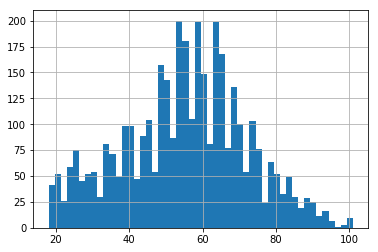

In [184]:
profile[(profile["fafdcd668e3743c1bb461111dcafc2a4_positive_response"] == 1)]["age"].hist(bins=50)

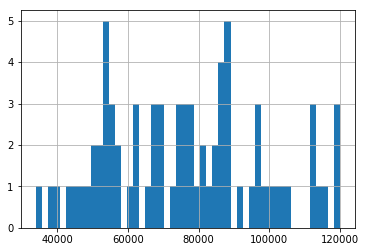

In [175]:
profile[(profile["ae264e3637204a6fb9bb56bc8210ddfd_positive_response"] == 0)]["age"].hist(bins=50)

In [40]:
profile.sample(15)

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount,...,ae264e3637204a6fb9bb56bc8210ddfd_positive_response,4d5c57ea9a6940dd891ad53e9dbe8da0_positive_response,3f207df678b143eea3cee63160fa8bed_positive_response,9b98b8c7a33c4b65b9aebfe6a799e6d9_positive_response,0b1e1539f2cc45b7b9fa7c272da2e1d7_positive_response,2298d6c36e964ae4a3e7e9706d1fb8c2_positive_response,fafdcd668e3743c1bb461111dcafc2a4_positive_response,5a8bc65990b245e5a138643cd4eb9837_positive_response,f19421c1d4aa40978ebb69ca19b0e20d_positive_response,2906b810c7d4411798c6938adc9daaa5_positive_response
14509,NaN,52293b30cace464aacc43227ab3538d2,NaN,178,2018-01-29,0,0,0,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3310,74.0,5c1113029907478db64fc389e9d19a9e,65000.0,708,2016-08-17,0,1,0,29.64,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2862,76.0,990080173c3f4871bb8634a9b50e118a,75000.0,250,2017-11-18,0,1,0,45.86,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14958,NaN,aefcc0baa56342649e3549e6cbc6d1e5,NaN,320,2017-09-09,0,0,0,4.85,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16381,65.0,5c73c99208e449129397591e045e641f,36000.0,220,2017-12-18,0,1,0,88.82,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,96.0,868317b9be554cb18e50bc68484749a2,89000.0,251,2017-11-17,1,0,0,81.92,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15750,NaN,8ae49e01c5cc4029ad3758b6081b3bfd,NaN,30,2018-06-26,0,0,0,10.22,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7094,60.0,76e4c32f141f4bd1b1a905cf6b28bcfa,104000.0,444,2017-05-08,1,0,0,29.77,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13569,28.0,53df362c15624e65ba73c38367ca1735,73000.0,1196,2015-04-17,0,1,0,40.43,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
913,49.0,8c843138f8d642da9bec4370e87c38d9,70000.0,262,2017-11-06,1,0,0,47.22,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Understanding the data sets.

### Understanding the experiment.

There are four different discount offers, four bogo offers, and two informational offers.

In [566]:
portfolio[(portfolio["offer_type_discount"] == 1)]["id"].count()

4

In [570]:
portfolio[(portfolio["offer_type_discount"] == 1)]["id"].count()

4

In [571]:
portfolio[(portfolio["offer_type_informational"] == 1)]["id"].count()

2

And the total number of offers by each types (i.e. discount, bogo, and informational) are roughly proportionate. 

In [537]:
transcript_merge = pd.merge(transcript[transcript["event_type_offer_received"] == 1], portfolio, left_on="offer_id", right_on="id")

In [574]:
transcript_merge.sample(5).sort_values("time")

,person,time,event_type_offer_received,event_type_offer_viewed,event_type_transaction,event_type_offer_completed,offer_id,transaction_amount,reward_amount,outlier,...,duration,id,reward,channel_type_web,channel_type_email,channel_type_mobile,channel_type_social,offer_type_bogo,offer_type_discount,offer_type_informational
69879,4e3f3a3401ae4b50837665179b6d7415,0,1,0,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,...,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
24720,2d22aa1312114d02967a62cf4e5b37db,168,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,...,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
34285,e2fa490b0c9f44228ba46919ba32958c,336,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,...,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
66207,0485b8cb0bfc4d938895bbd6d8cbd7df,504,1,0,0,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,...,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
15163,aa13d8187b5f4fdb9a0cfa94e39e911f,576,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,...,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [557]:
transcript_merge[(transcript_merge["offer_type_discount"] ==1)]["offer_id"].count()

30543

In [558]:
transcript_merge[(transcript_merge["offer_type_bogo"] ==1)]["offer_id"].count()

30499

In [559]:
transcript_merge[(transcript_merge["offer_type_informational"] ==1)]["offer_id"].count()

15235

Offers were sent out in chunks (as oppose to randomly at any time). This will make the analysis a little easier to do.

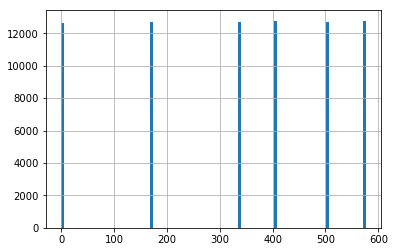

In [522]:
offer_dates_plot = transcript[(transcript["event_type_offer_received"] == 1)]["time"].hist(bins=100);

In [204]:
transcript[(transcript["event_type_offer_received"] == 1) & (transcript["time"] == 168)]["offer_id"].value_counts()

ae264e3637204a6fb9bb56bc8210ddfd    1319
9b98b8c7a33c4b65b9aebfe6a799e6d9    1296
5a8bc65990b245e5a138643cd4eb9837    1270
2906b810c7d4411798c6938adc9daaa5    1270
3f207df678b143eea3cee63160fa8bed    1266
f19421c1d4aa40978ebb69ca19b0e20d    1263
fafdcd668e3743c1bb461111dcafc2a4    1250
2298d6c36e964ae4a3e7e9706d1fb8c2    1250
0b1e1539f2cc45b7b9fa7c272da2e1d7    1245
4d5c57ea9a6940dd891ad53e9dbe8da0    1240
Name: offer_id, dtype: int64

Viewed time, transactions and completed time for an offer at hour 168. Shows a time decay for viewed time and the completed time, and an initial surge and a decay for transactions. Interesting to see, but not relevant to the main goal. 

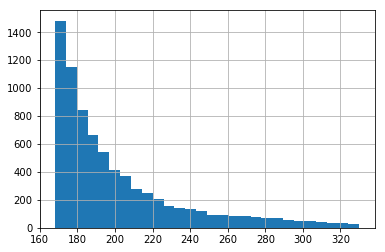

In [218]:
transcript[(transcript["event_type_offer_viewed"] == 1) & (transcript["time"] >= 168) & (transcript["time"] <= 335) & (transcript["offer_id"] <= "ae264e3637204a6fb9bb56bc8210ddfd")]["time"].hist(bins=28)

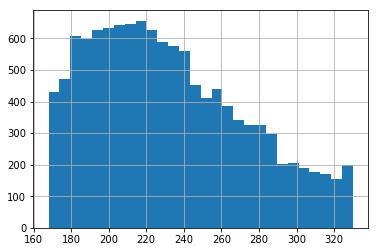

In [222]:
transcript[(transcript["event_type_transaction"] == 1) & (transcript["time"] >= 168) & (transcript["time"] <= 335) & (transcript["no_promotions_transaction"] == 0)]["time"].hist(bins=28)

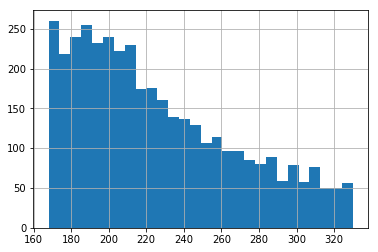

In [219]:
transcript[(transcript["event_type_offer_completed"] == 1) & (transcript["time"] >= 168) & (transcript["time"] <= 335) & (transcript["offer_id"] <= "ae264e3637204a6fb9bb56bc8210ddfd")]["time"].hist(bins=28)

In [228]:
offer_dates_plot.set_xlim(-50, 750)

(-50, 750)

In [523]:
# offer_dates_plot.figure

And the number of offers sent out are roughly proportionate and equal each time.

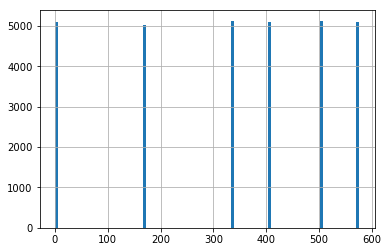

In [37]:
transcript[(transcript["event_type_offer_received"] == 1) & ((transcript["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") | (transcript["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") | (transcript["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") | (transcript["offer_id"] == "2906b810c7d4411798c6938adc9daaa5")) ]["time"].hist(bins=100)

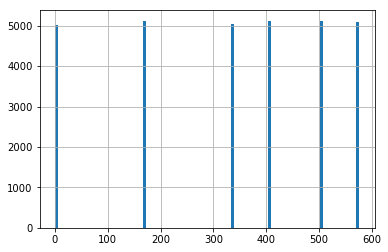

In [39]:
transcript[(transcript["event_type_offer_received"] == 1) & ((transcript["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") | (transcript["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") | (transcript["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") | (transcript["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d")) ]["time"].hist(bins=100)

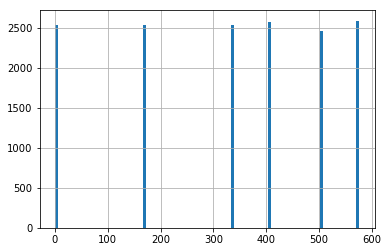

In [41]:
transcript[(transcript["event_type_offer_received"] == 1) & ((transcript["offer_id"] == "3f207df678b143eea3cee63160fa8bed") | (transcript["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837"))]["time"].hist(bins=100)

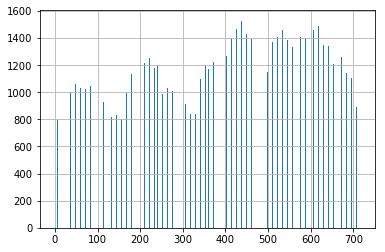

In [118]:
transcript[(transcript["event_type_transaction"] == 1) ]["time"].hist(bins=720);

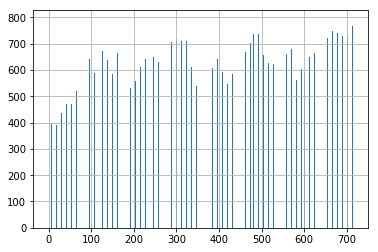

In [119]:
transcript[(transcript["event_type_transaction"] == 1) & (transcript["no_promotions_transaction"] == 1)]["time"].hist(bins=720);

base-line transaction amount (no promotions transactions only)

In [121]:
time_group = transcript[(transcript["event_type_transaction"] == 1) & (transcript["no_promotions_transaction"] == 1)].groupby("time").sum()

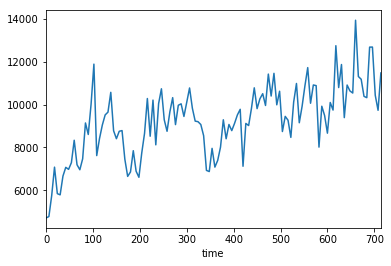

In [122]:
transaction_amount_plot = time_group["transaction_amount"].plot(kind="line")

full transaction amount (including transactions during promotions)

In [126]:
time_group = transcript[(transcript["event_type_transaction"] == 1)].groupby("time").sum()

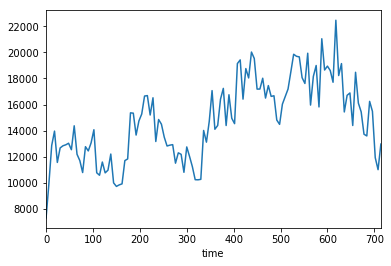

In [127]:
transaction_amount_plot = time_group["transaction_amount"].plot(kind="line")

In [129]:
transaction_amount_plot.set_xlim(-50, 750)

(-50, 750)

In [130]:
# transaction_amount_plot.figure

### Success rate by types

In [115]:
successful_discounts = offers[(offers["offer_type"] == "discount") & (offers["success"] == 1)]["offer_id"].count()

total_discounts = offers[(offers["offer_type"] == "discount")]["offer_id"].count()

print("Successful Discounts: {0}, Total Discounts: {1}, Success Rate: {2:.1f} %".format(successful_discounts, total_discounts, (successful_discounts/total_discounts*100)))

Successful Discounts: 12493, Total Discounts: 30543, Success Rate: 40.9 %


In [116]:
successful_bogos = offers[(offers["offer_type"] == "bogo") & (offers["success"] == 1)]["offer_id"].count()

total_bogos = offers[(offers["offer_type"] == "bogo")]["offer_id"].count()

print("Successful BOGO's: {0}, Total BOGO's: {1}, Success Rate: {2:.1f} %".format(successful_bogos, total_bogos, (successful_bogos/total_bogos*100)))

Successful BOGO's: 11017, Total BOGO's: 30499, Success Rate: 36.1 %


In [117]:
successful_infos = offers[(offers["offer_type"] == "informational") & (offers["success"] == 1)]["offer_id"].count()

total_infos = offers[(offers["offer_type"] == "informational")]["offer_id"].count()

print("Successful Informationals: {0}, Total Informationals: {1}, Success Rate: {2:.1f} %".format(successful_infos, total_infos, (successful_infos/total_infos*100)))

Successful Informationals: 5701, Total Informationals: 15235, Success Rate: 37.4 %


### success rate by channels

In [163]:
web_results = offers[(offers["web"] == 1)]["success"].value_counts()

print("Web Success: {0}, Web Total: {1}, Web Success Rate: {2:.1f} %".format(web_results[0], web_results[1], (web_results[1]/(web_results[0] + web_results[1])*100)))

Web Success: 37949, Web Total: 23052, Web Success Rate: 37.8 %


In [164]:
email_results = offers[(offers["email"] == 1)]["success"].value_counts()

print("Email Success: {0}, Email Total: {1}, Email Success Rate: {2:.1f} %".format(web_results[0], email_results[1], (email_results[1]/(email_results[0] + email_results[1])*100)))

Email Success: 37949, Email Total: 29211, Email Success Rate: 38.3 %


In [165]:
social_results = offers[(offers["social"] == 1)]["success"].value_counts()

print("Social Success: {0}, Social Total: {1}, Social Success Rate: {2:.1f} %".format(social_results[0], social_results[1], (social_results[1]/(social_results[0] + social_results[1])*100)))

Social Success: 24232, Social Total: 21451, Social Success Rate: 47.0 %


In [166]:
mobile_results = offers[(offers["mobile"] == 1)]["success"].value_counts()

print("Mobile Success: {0}, Mobile Total: {1}, Mobile Success Rate: {2:.1f} %".format(mobile_results[0], mobile_results[1], (mobile_results[1]/(mobile_results[0] + mobile_results[1])*100)))

Mobile Success: 40743, Mobile Total: 27866, Mobile Success Rate: 40.6 %


# Correlation analysis of offer success rate vs features

In [214]:
pointbiserialr(portfolio["success_rate"].values, portfolio["difficulty"].values)

PointbiserialrResult(correlation=-0.318056100663557, pvalue=0.3704649200787039)

In [215]:
pointbiserialr(portfolio["success_rate"].values, portfolio["duration"].values)

PointbiserialrResult(correlation=-0.031125601204305485, pvalue=0.9319786721692948)

In [216]:
pointbiserialr(portfolio["success_rate"].values, portfolio["reward"].values)

PointbiserialrResult(correlation=-0.21502599343304002, pvalue=0.5507820336982716)

In [217]:
pointbiserialr(portfolio["success_rate"].values, portfolio["channel_type_web"].values)

PointbiserialrResult(correlation=-0.07510721876309716, pvalue=0.836626641321613)

In [219]:
pointbiserialr(portfolio["success_rate"].values, portfolio["channel_type_email"].values)

PointbiserialrResult(correlation=nan, pvalue=1.0)

In [220]:
pointbiserialr(portfolio["success_rate"].values, portfolio["channel_type_mobile"].values)

PointbiserialrResult(correlation=0.5180096711394204, pvalue=0.12508908209334613)

In [221]:
pointbiserialr(portfolio["success_rate"].values, portfolio["channel_type_social"].values)

PointbiserialrResult(correlation=0.7907948409408422, pvalue=0.0064544858668168885)

In [222]:
pointbiserialr(portfolio["success_rate"].values, portfolio["offer_type_bogo"].values)

PointbiserialrResult(correlation=-0.1323465387118921, pvalue=0.7155097858747652)

In [223]:
pointbiserialr(portfolio["success_rate"].values, portfolio["offer_type_discount"].values)

PointbiserialrResult(correlation=0.1599877333205199, pvalue=0.6588480382763615)

In [224]:
pointbiserialr(portfolio["success_rate"].values, portfolio["offer_type_informational"].values)

PointbiserialrResult(correlation=-0.03385341133605368, pvalue=0.9260304745882326)

# Offer property analyses

In [550]:
portfolio["id"]

0    ae264e3637204a6fb9bb56bc8210ddfd
1    4d5c57ea9a6940dd891ad53e9dbe8da0
2    3f207df678b143eea3cee63160fa8bed
3    9b98b8c7a33c4b65b9aebfe6a799e6d9
4    0b1e1539f2cc45b7b9fa7c272da2e1d7
5    2298d6c36e964ae4a3e7e9706d1fb8c2
6    fafdcd668e3743c1bb461111dcafc2a4
7    5a8bc65990b245e5a138643cd4eb9837
8    f19421c1d4aa40978ebb69ca19b0e20d
9    2906b810c7d4411798c6938adc9daaa5
Name: id, dtype: object

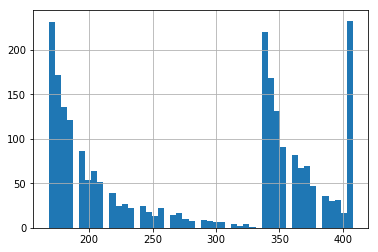

In [551]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

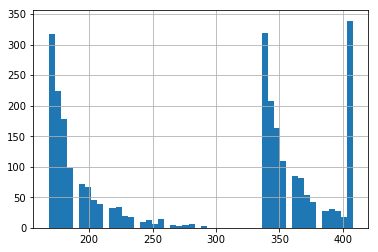

In [552]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

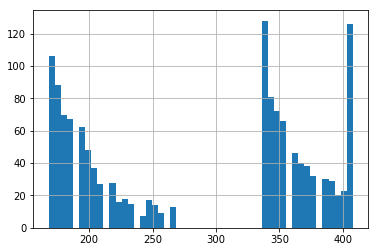

In [553]:
offers[(offers["offer_id"] == "3f207df678b143eea3cee63160fa8bed") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

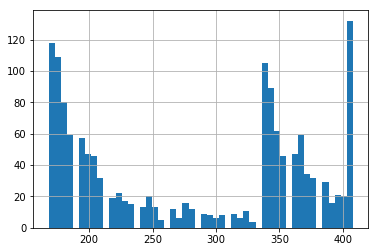

In [554]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

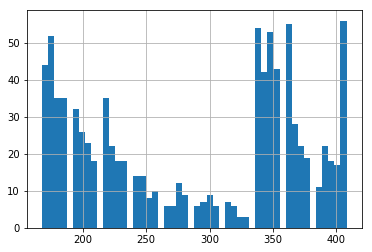

In [343]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

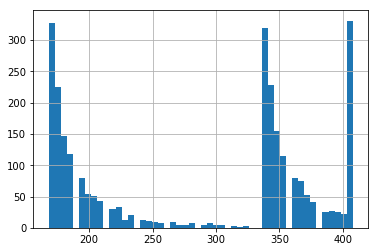

In [555]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

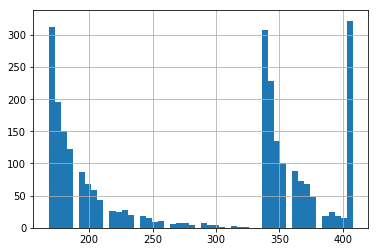

In [556]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

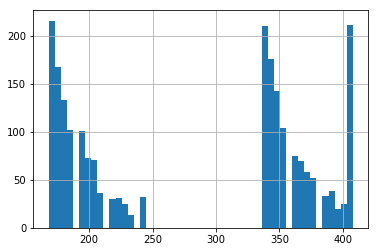

In [557]:
offers[(offers["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

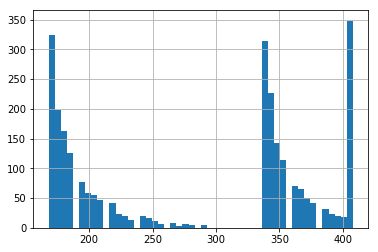

In [558]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

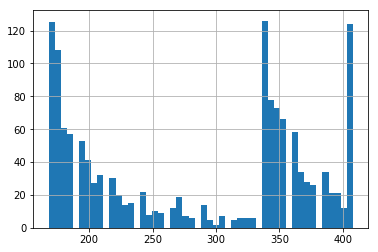

In [559]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

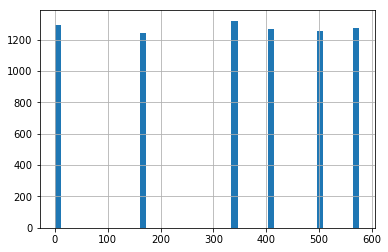

In [333]:
transcript[(transcript["event_type_offer_received"] == 1) & (transcript["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7")]["time"].hist(bins=50)

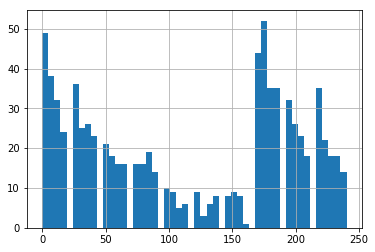

In [344]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

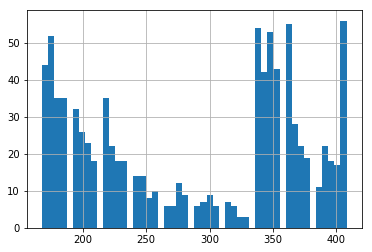

In [343]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

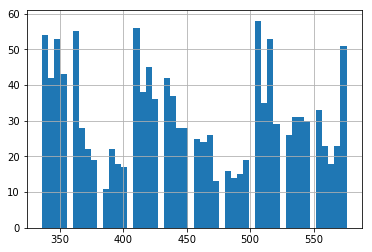

In [345]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

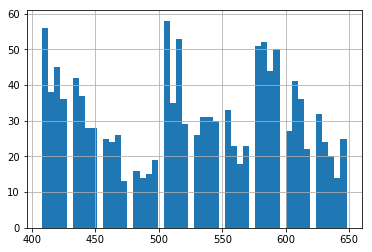

In [346]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

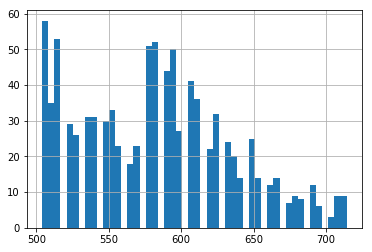

In [385]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

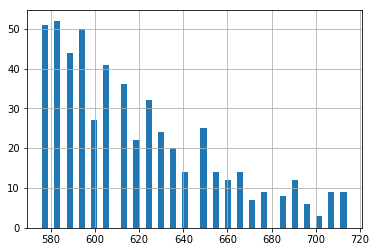

In [348]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

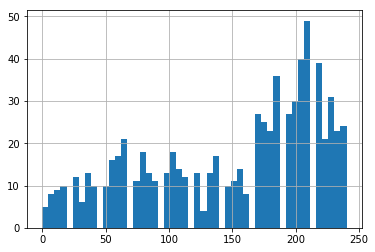

In [337]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["completed_time"] >= 0) & (offers["completed_time"] <= 240)]["completed_time"].hist(bins=50)

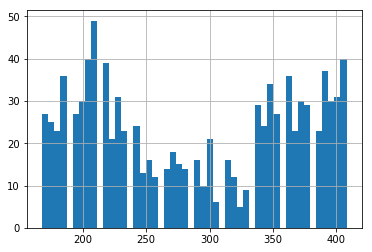

In [338]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["completed_time"] >= 168) & (offers["completed_time"] <= 408)]["completed_time"].hist(bins=50)

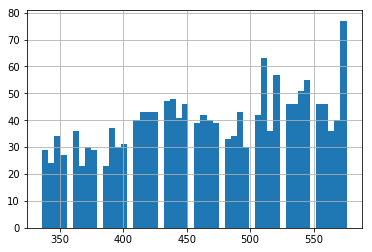

In [339]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["completed_time"] >= 336) & (offers["completed_time"] <= 576)]["completed_time"].hist(bins=50)

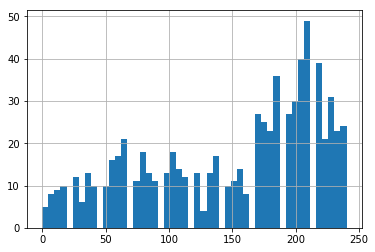

In [337]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["completed_time"] >= 408) & (offers["completed_time"] <= 648)]["completed_time"].hist(bins=50)

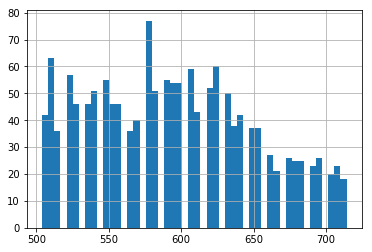

In [340]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["completed_time"] >= 504) & (offers["completed_time"] <= 744)]["completed_time"].hist(bins=50)

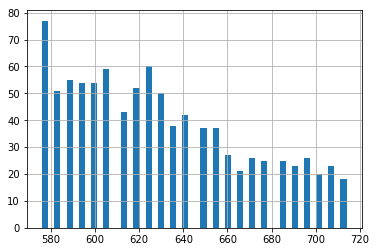

In [341]:
offers[(offers["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7") & (offers["completed_time"] >= 576) & (offers["completed_time"] <= 816)]["completed_time"].hist(bins=50)

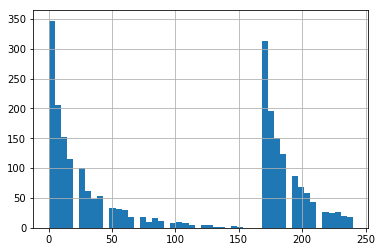

In [386]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

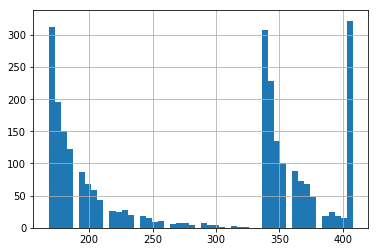

In [387]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

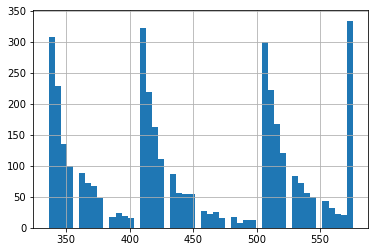

In [388]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

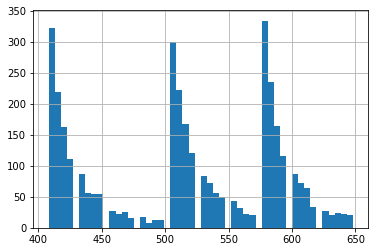

In [389]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

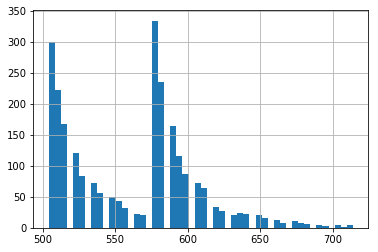

In [390]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

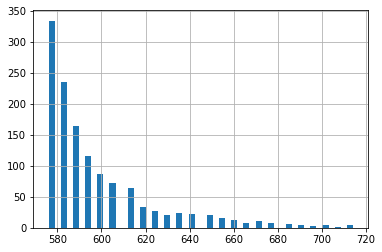

In [391]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

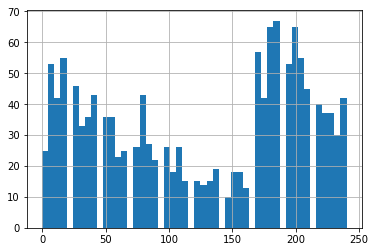

In [392]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["completed_time"] >= 0) & (offers["completed_time"] <= 240)]["completed_time"].hist(bins=50)

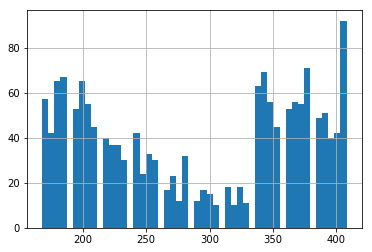

In [393]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["completed_time"] >= 168) & (offers["completed_time"] <= 408)]["completed_time"].hist(bins=50)

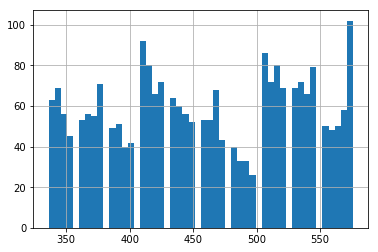

In [394]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["completed_time"] >= 336) & (offers["completed_time"] <= 576)]["completed_time"].hist(bins=50)

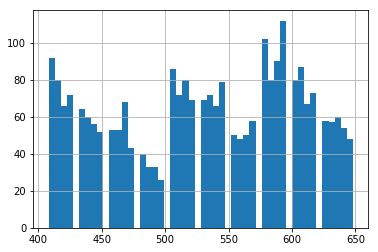

In [395]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["completed_time"] >= 408) & (offers["completed_time"] <= 648)]["completed_time"].hist(bins=50)

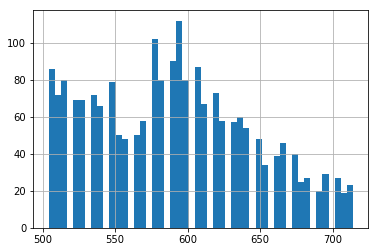

In [396]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["completed_time"] >= 504) & (offers["completed_time"] <= 744)]["completed_time"].hist(bins=50)

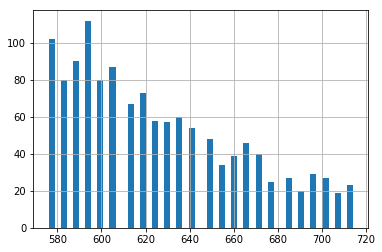

In [397]:
offers[(offers["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4") & (offers["completed_time"] >= 576) & (offers["completed_time"] <= 816)]["completed_time"].hist(bins=50)

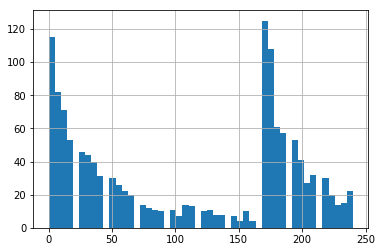

In [398]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

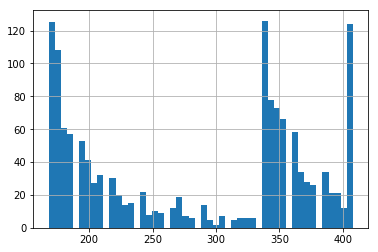

In [399]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

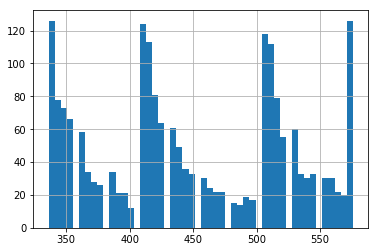

In [400]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

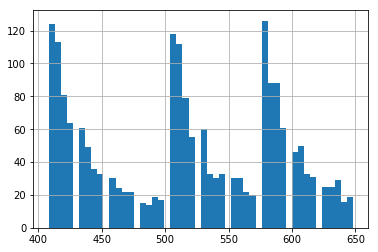

In [401]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

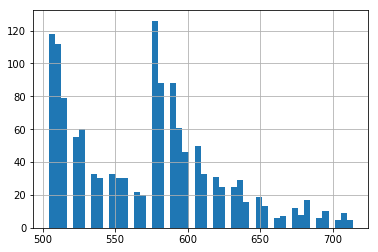

In [402]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

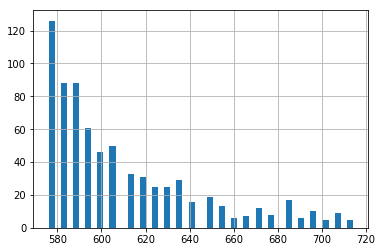

In [403]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

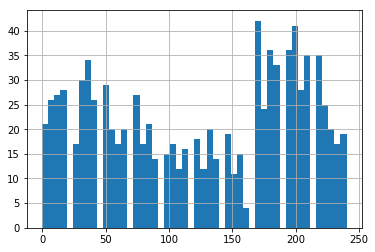

In [404]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["completed_time"] >= 0) & (offers["completed_time"] <= 240)]["completed_time"].hist(bins=50)

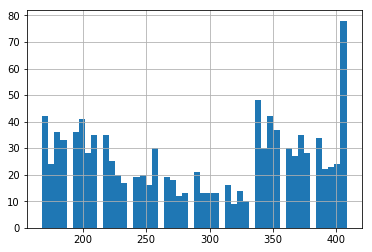

In [405]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["completed_time"] >= 168) & (offers["completed_time"] <= 408)]["completed_time"].hist(bins=50)

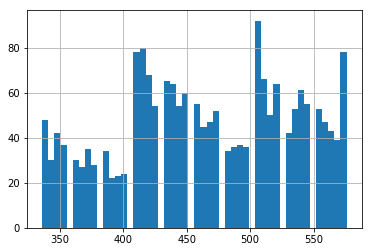

In [406]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["completed_time"] >= 336) & (offers["completed_time"] <= 576)]["completed_time"].hist(bins=50)

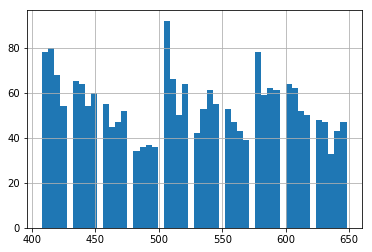

In [407]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["completed_time"] >= 408) & (offers["completed_time"] <= 648)]["completed_time"].hist(bins=50)

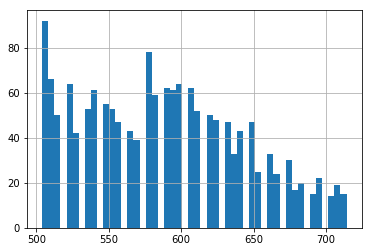

In [408]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["completed_time"] >= 504) & (offers["completed_time"] <= 744)]["completed_time"].hist(bins=50)

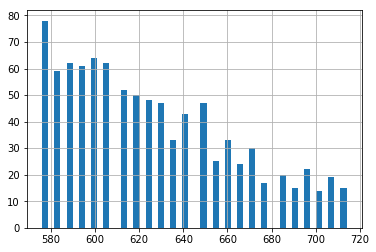

In [409]:
offers[(offers["offer_id"] == "2906b810c7d4411798c6938adc9daaa5") & (offers["completed_time"] >= 576) & (offers["completed_time"] <= 816)]["completed_time"].hist(bins=50)

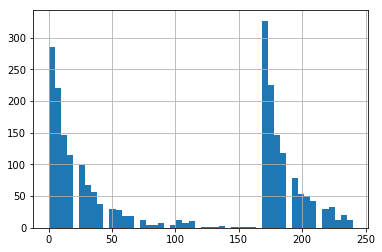

In [410]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

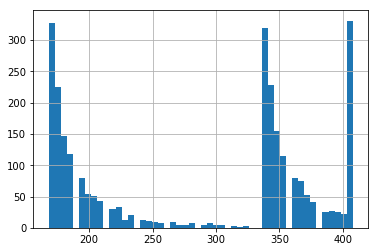

In [411]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

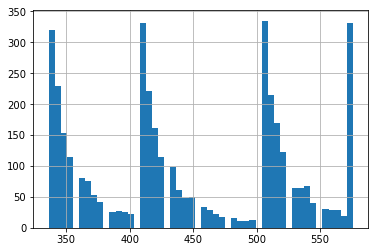

In [412]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

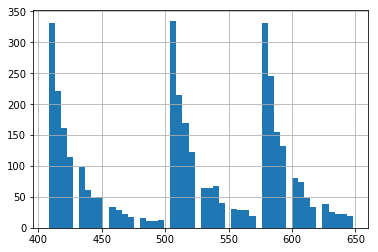

In [413]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

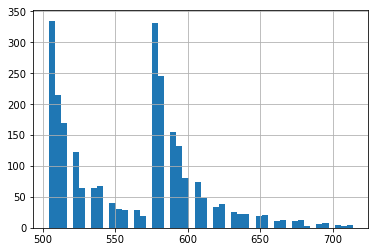

In [414]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

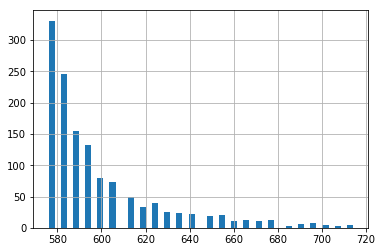

In [415]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

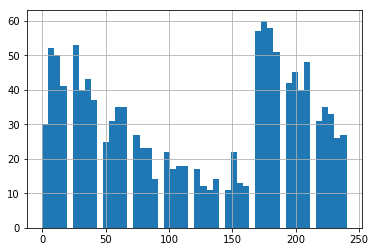

In [416]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["completed_time"] >= 0) & (offers["completed_time"] <= 240)]["completed_time"].hist(bins=50)

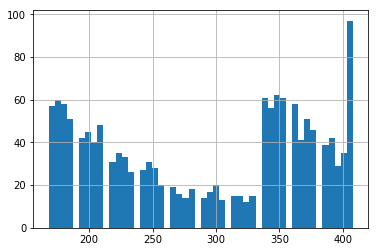

In [417]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["completed_time"] >= 168) & (offers["completed_time"] <= 408)]["completed_time"].hist(bins=50)

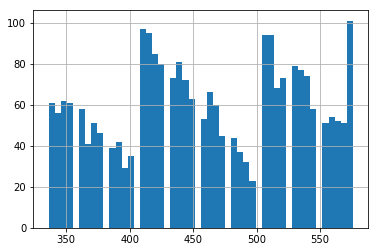

In [418]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["completed_time"] >= 336) & (offers["completed_time"] <= 576)]["completed_time"].hist(bins=50)

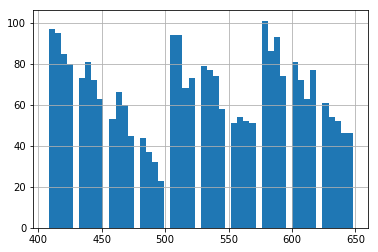

In [419]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["completed_time"] >= 408) & (offers["completed_time"] <= 648)]["completed_time"].hist(bins=50)

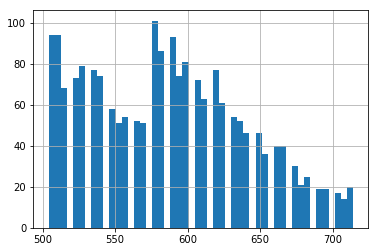

In [420]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["completed_time"] >= 504) & (offers["completed_time"] <= 744)]["completed_time"].hist(bins=50)

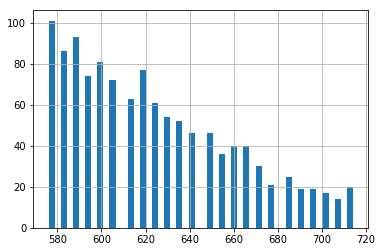

In [421]:
offers[(offers["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & (offers["completed_time"] >= 576) & (offers["completed_time"] <= 816)]["completed_time"].hist(bins=50)

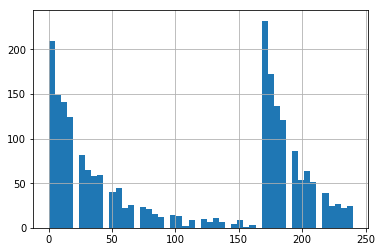

In [422]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

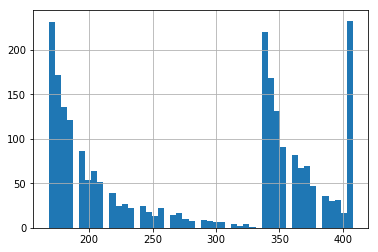

In [423]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

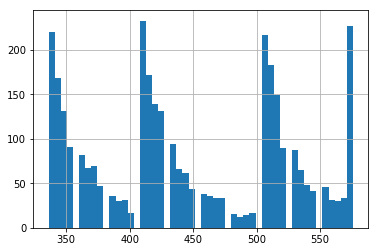

In [424]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

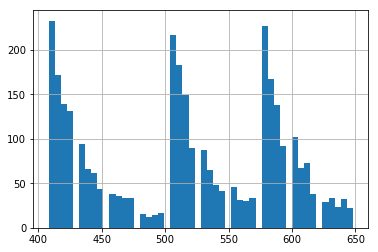

In [425]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

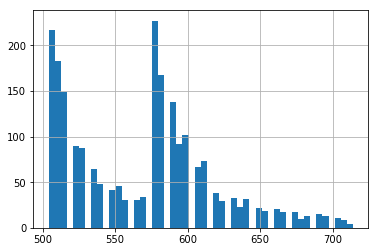

In [426]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

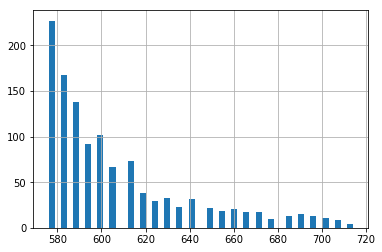

In [427]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

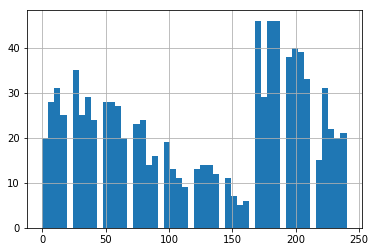

In [428]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["completed_time"] >= 0) & (offers["completed_time"] <= 240)]["completed_time"].hist(bins=50)

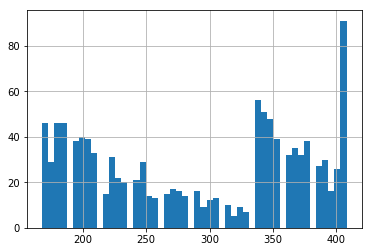

In [429]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["completed_time"] >= 168) & (offers["completed_time"] <= 408)]["completed_time"].hist(bins=50)

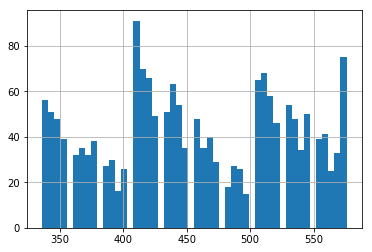

In [430]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["completed_time"] >= 336) & (offers["completed_time"] <= 576)]["completed_time"].hist(bins=50)

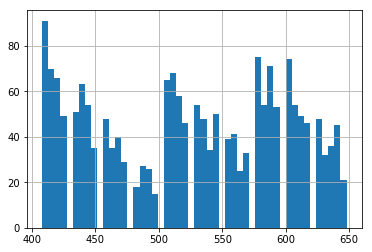

In [431]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["completed_time"] >= 408) & (offers["completed_time"] <= 648)]["completed_time"].hist(bins=50)

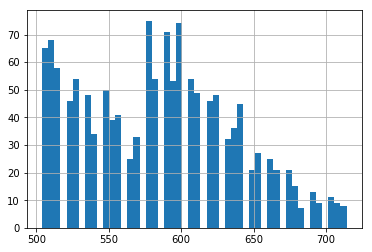

In [432]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["completed_time"] >= 504) & (offers["completed_time"] <= 744)]["completed_time"].hist(bins=50)

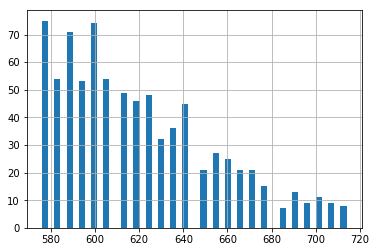

In [433]:
offers[(offers["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd") & (offers["completed_time"] >= 576) & (offers["completed_time"] <= 816)]["completed_time"].hist(bins=50)

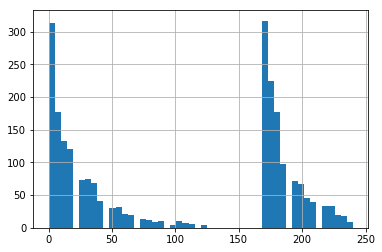

In [434]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

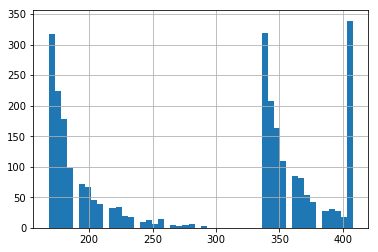

In [435]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

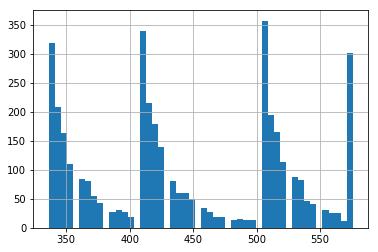

In [436]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

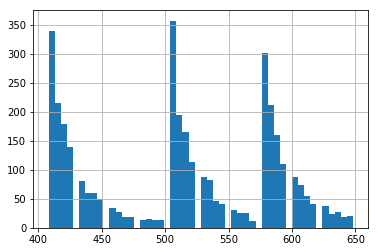

In [437]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

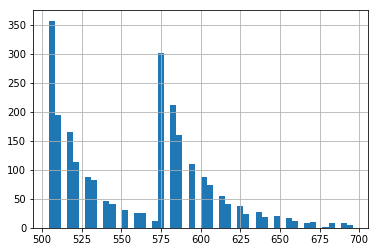

In [438]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

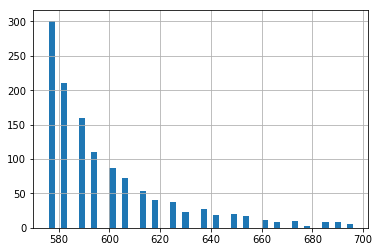

In [439]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

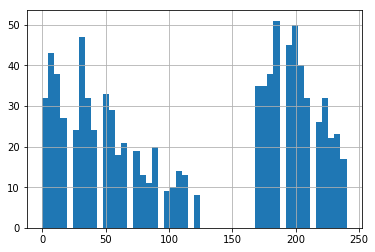

In [440]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["completed_time"] >= 0) & (offers["completed_time"] <= 240)]["completed_time"].hist(bins=50)

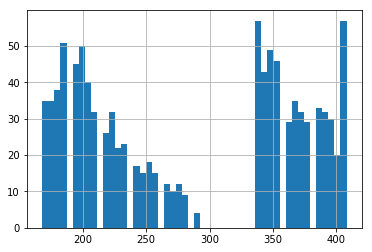

In [441]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["completed_time"] >= 168) & (offers["completed_time"] <= 408)]["completed_time"].hist(bins=50)

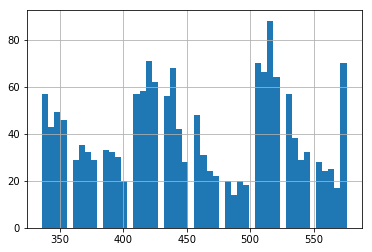

In [442]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["completed_time"] >= 336) & (offers["completed_time"] <= 576)]["completed_time"].hist(bins=50)

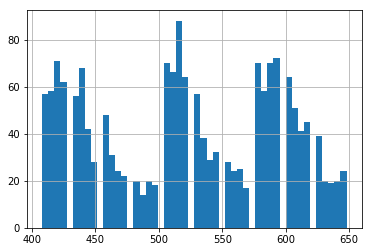

In [443]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["completed_time"] >= 408) & (offers["completed_time"] <= 648)]["completed_time"].hist(bins=50)

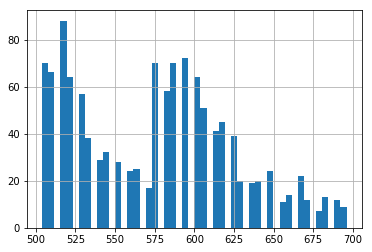

In [444]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["completed_time"] >= 504) & (offers["completed_time"] <= 744)]["completed_time"].hist(bins=50)

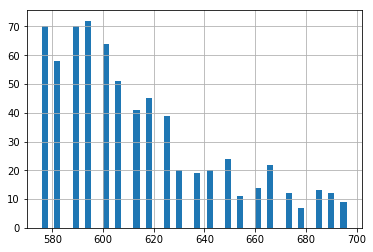

In [445]:
offers[(offers["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0") & (offers["completed_time"] >= 576) & (offers["completed_time"] <= 816)]["completed_time"].hist(bins=50)

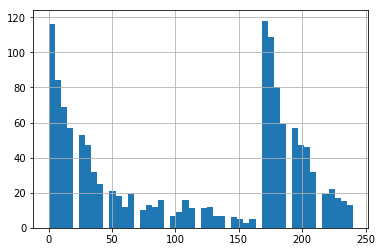

In [446]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

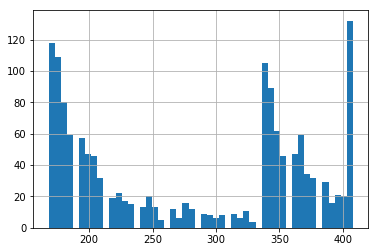

In [447]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

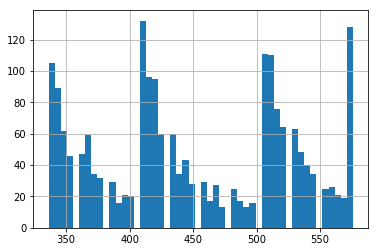

In [448]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

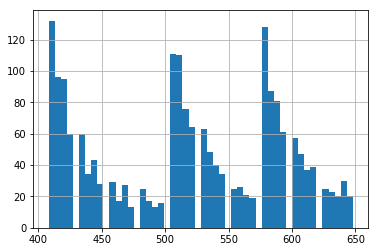

In [449]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

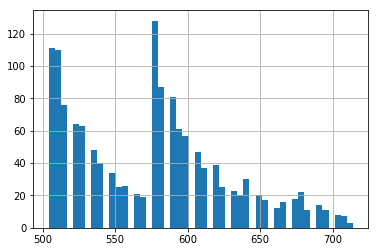

In [450]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

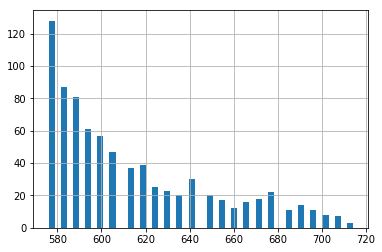

In [451]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

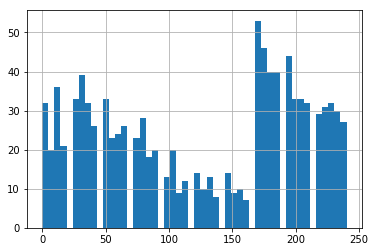

In [452]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["completed_time"] >= 0) & (offers["completed_time"] <= 240)]["completed_time"].hist(bins=50)

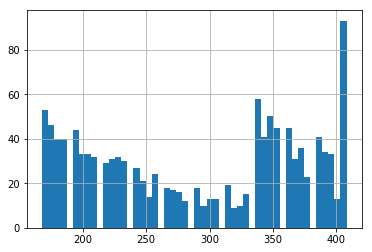

In [453]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["completed_time"] >= 168) & (offers["completed_time"] <= 408)]["completed_time"].hist(bins=50)

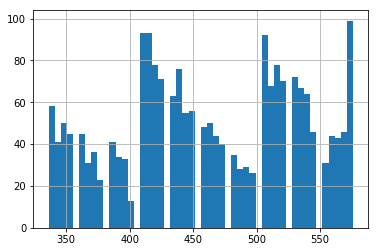

In [454]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["completed_time"] >= 336) & (offers["completed_time"] <= 576)]["completed_time"].hist(bins=50)

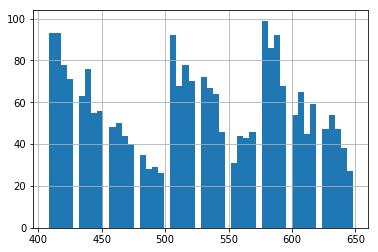

In [455]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["completed_time"] >= 408) & (offers["completed_time"] <= 648)]["completed_time"].hist(bins=50)

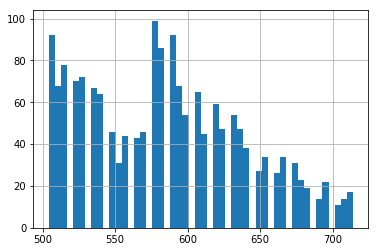

In [456]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["completed_time"] >= 504) & (offers["completed_time"] <= 744)]["completed_time"].hist(bins=50)

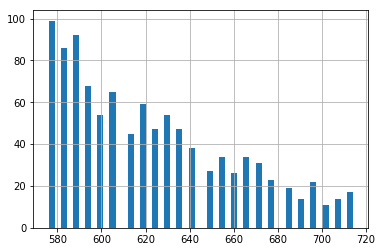

In [457]:
offers[(offers["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (offers["completed_time"] >= 576) & (offers["completed_time"] <= 816)]["completed_time"].hist(bins=50)

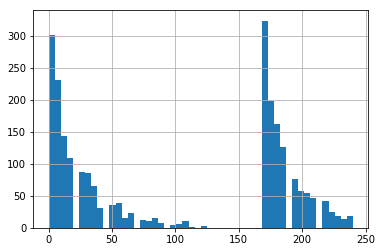

In [458]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

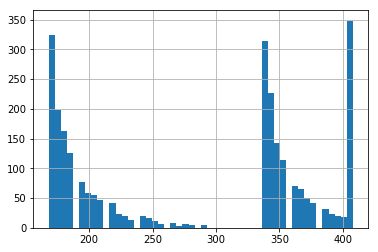

In [459]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

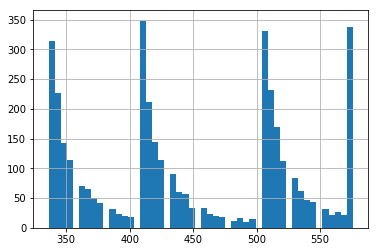

In [460]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

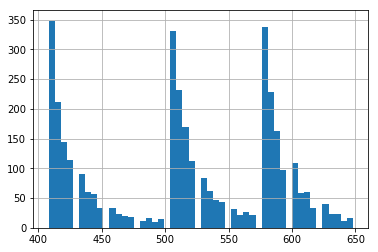

In [461]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

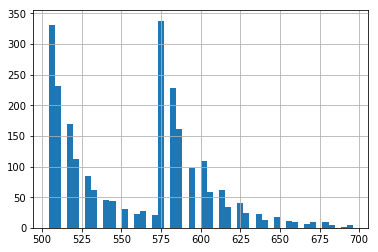

In [462]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

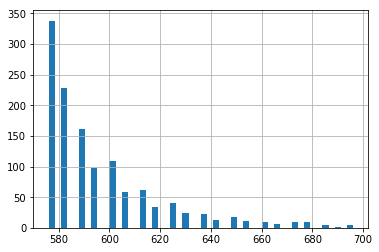

In [463]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

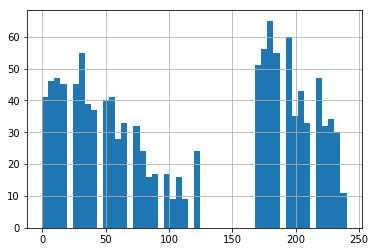

In [464]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["completed_time"] >= 0) & (offers["completed_time"] <= 240)]["completed_time"].hist(bins=50)

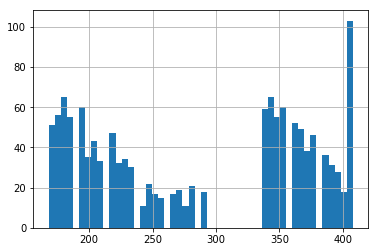

In [465]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["completed_time"] >= 168) & (offers["completed_time"] <= 408)]["completed_time"].hist(bins=50)

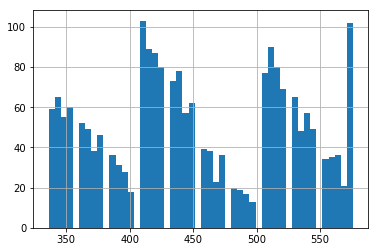

In [466]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["completed_time"] >= 336) & (offers["completed_time"] <= 576)]["completed_time"].hist(bins=50)

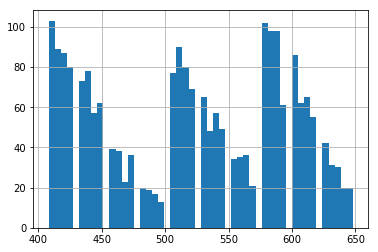

In [467]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["completed_time"] >= 408) & (offers["completed_time"] <= 648)]["completed_time"].hist(bins=50)

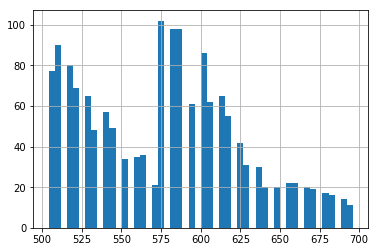

In [468]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["completed_time"] >= 504) & (offers["completed_time"] <= 744)]["completed_time"].hist(bins=50)

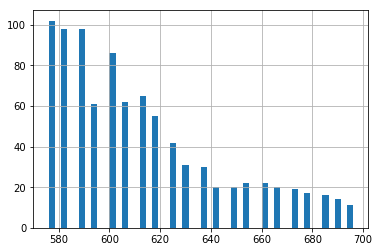

In [469]:
offers[(offers["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d") & (offers["completed_time"] >= 576) & (offers["completed_time"] <= 816)]["completed_time"].hist(bins=50)

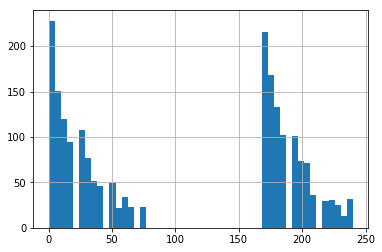

In [470]:
offers[(offers["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

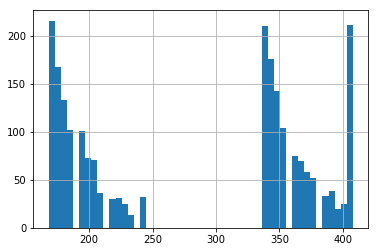

In [471]:
offers[(offers["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

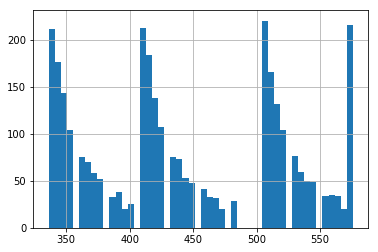

In [472]:
offers[(offers["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

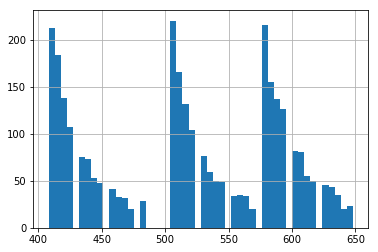

In [473]:
offers[(offers["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

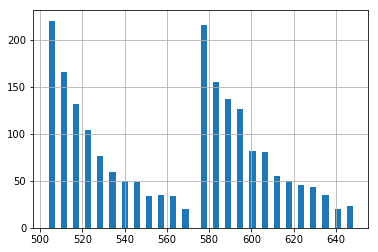

In [474]:
offers[(offers["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

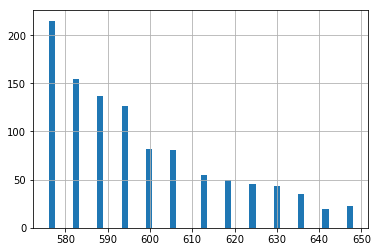

In [475]:
offers[(offers["offer_id"] == "5a8bc65990b245e5a138643cd4eb9837") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

In [485]:
offers.head()

,customer_id,offer_id,received_time,viewed_time,completed_time,end_time,offer_type,transaction_amount_sum,spending_per_hour,receive_to_view_time,view_to_complete_time,success,web,email,mobile,social
0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,168.0,216.0,NaN,336.0,discount,0.00,NaN,48.0,NaN,0.0,1.0,1.0,1.0,0.0
1,68be06ca386d4c31939f3a4f0e3dd783,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,348.0,NaN,576.0,discount,10.52,NaN,12.0,NaN,0.0,1.0,1.0,0.0,0.0
2,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,408.0,408.0,552.0,648.0,discount,14.84,0.103056,0.0,144.0,1.0,1.0,1.0,1.0,1.0
3,68be06ca386d4c31939f3a4f0e3dd783,2298d6c36e964ae4a3e7e9706d1fb8c2,504.0,504.0,552.0,672.0,discount,12.21,0.254375,0.0,48.0,1.0,1.0,1.0,1.0,1.0
4,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,576.0,582.0,NaN,816.0,discount,9.88,NaN,6.0,NaN,0.0,1.0,1.0,1.0,1.0


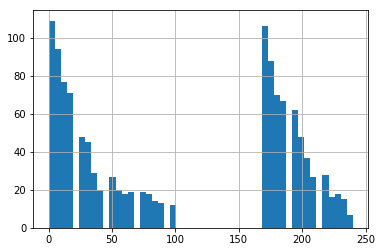

In [486]:
offers[(offers["offer_id"] == "3f207df678b143eea3cee63160fa8bed") & (offers["viewed_time"] >= 0) & (offers["viewed_time"] <= 240)]["viewed_time"].hist(bins=50)

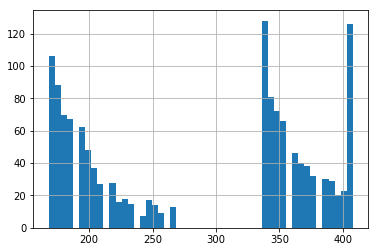

In [487]:
offers[(offers["offer_id"] == "3f207df678b143eea3cee63160fa8bed") & (offers["viewed_time"] >= 168) & (offers["viewed_time"] <= 408)]["viewed_time"].hist(bins=50)

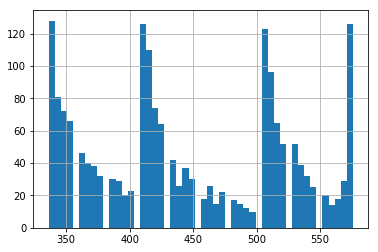

In [488]:
offers[(offers["offer_id"] == "3f207df678b143eea3cee63160fa8bed") & (offers["viewed_time"] >= 336) & (offers["viewed_time"] <= 576)]["viewed_time"].hist(bins=50)

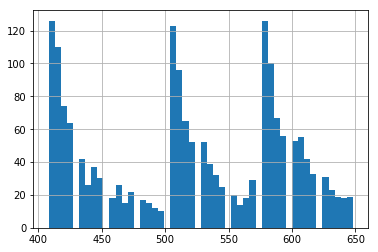

In [489]:
offers[(offers["offer_id"] == "3f207df678b143eea3cee63160fa8bed") & (offers["viewed_time"] >= 408) & (offers["viewed_time"] <= 648)]["viewed_time"].hist(bins=50)

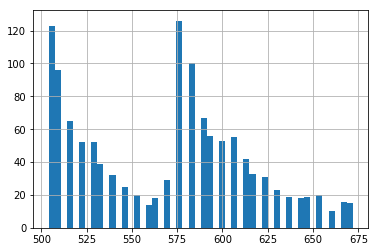

In [490]:
offers[(offers["offer_id"] == "3f207df678b143eea3cee63160fa8bed") & (offers["viewed_time"] >= 504) & (offers["viewed_time"] <= 744)]["viewed_time"].hist(bins=50)

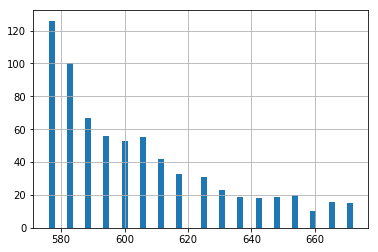

In [491]:
offers[(offers["offer_id"] == "3f207df678b143eea3cee63160fa8bed") & (offers["viewed_time"] >= 576) & (offers["viewed_time"] <= 816)]["viewed_time"].hist(bins=50)

In [317]:
offers["received_time"].value_counts()

408.0    12778
576.0    12765
336.0    12711
504.0    12704
168.0    12669
0.0      12650
Name: received_time, dtype: int64

In [363]:
customer_id_list = list(offers[(offers["received_time"] == 168)]["customer_id"])

In [376]:
offers_groupby_customer_id = offers.groupby(by="customer_id")

In [378]:
offers_groupby_customer_id["received_time"]

In [227]:
profile["no_promotions_spending_per_hour_aware"].describe()

count    17000.000000
mean         0.101231
std          0.105069
min          0.000000
25%          0.015666
50%          0.064869
75%          0.160694
max          0.750717
Name: no_promotions_spending_per_hour_aware, dtype: float64

In [228]:
profile["discount_spending_per_hour_aware"].describe()

count    17000.000000
mean         3.394315
std         15.811739
min          0.000000
25%          0.000000
50%          0.048631
75%          0.899270
max        319.830000
Name: discount_spending_per_hour_aware, dtype: float64

In [614]:
profile[(profile["discount_spending_per_hour_aware"] == 0)]["id"].count()

8978

In [690]:
profile[(profile["discount_spending_per_hour_aware"] > 300)]

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount,...,informational_positive_response_aware,discount_positive_response_active,bogo_positive_response_active,informational_positive_response_active,discount_negative_response_aware,bogo_negative_response_aware,informational_negative_response_aware,discount_negative_response_active,bogo_negative_response_active,informational_negative_response_active
11218,49,c2a5c2407540466b9b0f7e8e50715a73,98000.0,616,2016-11-17,1,0,0,345.72,25.0,...,0,1,1,0,1,0,1,0,0,1


In [691]:
offers[(offers["customer_id"] == "c2a5c2407540466b9b0f7e8e50715a73")]

,customer_id,offer_id,received_time,viewed_time,completed_time,end_time,offer_type,transaction_amount_sum,spending_per_hour,receive_to_view_time,view_to_complete_time,success,web,email,mobile,social
50358,c2a5c2407540466b9b0f7e8e50715a73,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,6.0,6.0,168.0,discount,51.43,0.306131,6.0,0.0,1.0,1.0,1.0,1.0,1.0
50359,c2a5c2407540466b9b0f7e8e50715a73,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0,174.0,198.0,336.0,bogo,88.96,2.965333,6.0,24.0,1.0,1.0,1.0,1.0,0.0
50360,c2a5c2407540466b9b0f7e8e50715a73,ae264e3637204a6fb9bb56bc8210ddfd,336.0,336.0,414.0,504.0,bogo,99.70,1.278205,0.0,78.0,1.0,0.0,1.0,1.0,1.0
50361,c2a5c2407540466b9b0f7e8e50715a73,2906b810c7d4411798c6938adc9daaa5,408.0,414.0,414.0,576.0,discount,162.77,0.968869,6.0,0.0,1.0,1.0,1.0,1.0,0.0
50362,c2a5c2407540466b9b0f7e8e50715a73,fafdcd668e3743c1bb461111dcafc2a4,504.0,510.0,510.0,744.0,discount,105.63,0.440125,6.0,0.0,1.0,1.0,1.0,1.0,1.0
50363,c2a5c2407540466b9b0f7e8e50715a73,2298d6c36e964ae4a3e7e9706d1fb8c2,576.0,600.0,576.0,744.0,discount,61.71,0.367321,24.0,NaN,0.0,1.0,1.0,1.0,1.0


In [692]:
transcript[(transcript["person"] == "c2a5c2407540466b9b0f7e8e50715a73")]

,person,time,event_type_offer_received,event_type_offer_viewed,event_type_transaction,event_type_offer_completed,offer_id,transaction_amount,reward_amount,outlier,no_promotions_transaction
8248,c2a5c2407540466b9b0f7e8e50715a73,0,1,0,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN
17236,c2a5c2407540466b9b0f7e8e50715a73,6,0,1,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaN
17237,c2a5c2407540466b9b0f7e8e50715a73,6,0,0,1,0,NaN,28.43,NaN,0.0,0.0
17238,c2a5c2407540466b9b0f7e8e50715a73,6,0,0,0,1,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,NaN,NaN
21617,c2a5c2407540466b9b0f7e8e50715a73,18,0,0,1,0,NaN,23.00,NaN,0.0,1.0
61446,c2a5c2407540466b9b0f7e8e50715a73,168,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,NaN
71159,c2a5c2407540466b9b0f7e8e50715a73,174,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,NaN
80751,c2a5c2407540466b9b0f7e8e50715a73,198,0,0,1,0,NaN,19.58,NaN,0.0,0.0
80752,c2a5c2407540466b9b0f7e8e50715a73,198,0,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,NaN,NaN
93108,c2a5c2407540466b9b0f7e8e50715a73,240,0,0,1,0,NaN,16.29,NaN,0.0,1.0


In [709]:
profile[(pd.isnull(profile["age"]))]

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount,...,informational_positive_response_aware,discount_positive_response_active,bogo_positive_response_active,informational_positive_response_active,discount_negative_response_aware,bogo_negative_response_aware,informational_negative_response_aware,discount_negative_response_active,bogo_negative_response_active,informational_negative_response_active


In [708]:
profile[(np.isnan(profile["age"]))]

,age,id,income,tenure_length,joined_date,female,male,other,total_transaction_amount,total_reward_amount,...,informational_positive_response_aware,discount_positive_response_active,bogo_positive_response_active,informational_positive_response_active,discount_negative_response_aware,bogo_negative_response_aware,informational_negative_response_aware,discount_negative_response_active,bogo_negative_response_active,informational_negative_response_active


In [704]:
profile["no_promotions_spending_per_hour_aware"].describe()

count    17000.000000
mean         0.101231
std          0.105069
min          0.000000
25%          0.015666
50%          0.064869
75%          0.160694
max          0.750717
Name: no_promotions_spending_per_hour_aware, dtype: float64

In [596]:
profile[(profile["discount_positive_response_aware"] == 1) & (profile["no_promotions_spending_per_hour_aware"] > 0)].loc[:, ["id", "discount_spending_per_hour_aware", "no_promotions_spending_per_hour_aware"]]

,id,discount_spending_per_hour_aware,no_promotions_spending_per_hour_aware
11,148adfcaa27d485b82f323aaaad036bd,0.092456,0.002910
12,2eeac8d8feae4a8cad5a6af0499a211d,0.123148,0.001968
15,31dda685af34476cad5bc968bdb01c53,1.529058,0.254846
18,6445de3b47274c759400cd68131d91b4,0.123083,0.020017
20,440cf1fd7580490c971d8c651ed962af,4.274630,0.388341
21,4b0da7e80e5945209a1fdddfe813dbe0,18.213333,0.193964
22,c27e0d6ab72c455a8bb66d980963de60,9.141667,0.146280
24,f806632c011441378d4646567f357a21,0.465309,0.036409
26,65aba5c617294649aeb624da249e1ee5,0.132738,0.012393
27,c6c9884912c645429f3333f912b55f44,0.102424,0.015987


In [693]:
profile[(profile["discount_positive_response_aware"] == 1) & (profile["no_promotions_spending_per_hour_aware"] > 0)].loc[:, ["id", "discount_spending_per_hour_aware", "no_promotions_spending_per_hour_aware"]]

,id,discount_spending_per_hour_aware,no_promotions_spending_per_hour_aware
11,148adfcaa27d485b82f323aaaad036bd,0.091652,0.002910
12,2eeac8d8feae4a8cad5a6af0499a211d,0.122018,0.001968
15,31dda685af34476cad5bc968bdb01c53,1.518058,0.254846
18,6445de3b47274c759400cd68131d91b4,0.122066,0.020017
20,440cf1fd7580490c971d8c651ed962af,4.196909,0.388341
21,4b0da7e80e5945209a1fdddfe813dbe0,15.611429,0.193964
22,c27e0d6ab72c455a8bb66d980963de60,7.835714,0.146280
24,f806632c011441378d4646567f357a21,0.462454,0.036409
26,65aba5c617294649aeb624da249e1ee5,0.131176,0.012393
27,c6c9884912c645429f3333f912b55f44,0.101654,0.015987


In [493]:
profile["no_promotions_spending_per_hour_aware"].describe()

count    17000.000000
mean         0.101231
std          0.105069
min          0.000000
25%          0.015666
50%          0.064869
75%          0.160694
max          0.750717
Name: no_promotions_spending_per_hour_aware, dtype: float64

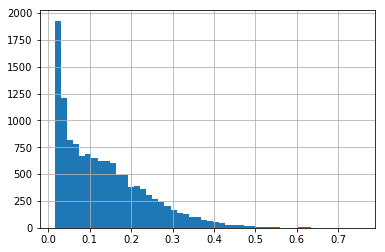

In [496]:
profile[(profile["no_promotions_spending_per_hour_aware"] > 0.015666)]["no_promotions_spending_per_hour_aware"].hist(bins=50)

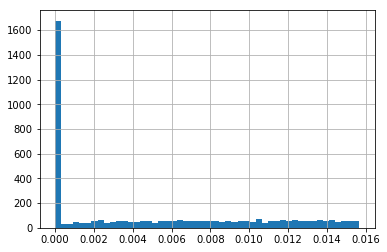

In [497]:
profile[(profile["no_promotions_spending_per_hour_aware"] < 0.015666)]["no_promotions_spending_per_hour_aware"].hist(bins=50)

In [522]:
90/80

1.125

In [518]:
profile[(profile["discount_spending_per_hour_aware"] >= 1.2 * profile["no_promotions_spending_per_hour_aware"]) & (profile["discount_spending_per_hour_aware"] > 0)][["discount_spending_per_hour_aware", "no_promotions_spending_per_hour_aware"]]

,discount_spending_per_hour_aware,no_promotions_spending_per_hour_aware
0,0.140155,0.000000
5,18.420000,0.084356
8,0.171274,0.000000
11,0.091652,0.002910
12,0.122018,0.001968
15,1.518058,0.254846
18,0.122066,0.020017
20,4.196909,0.388341
21,15.611429,0.193964
22,7.835714,0.146280


In [519]:
profile[(profile["bogo_spending_per_hour_aware"] >= 1.75 * profile["no_promotions_spending_per_hour_aware"]) & (profile["bogo_spending_per_hour_aware"] > 0)][["bogo_spending_per_hour_aware", "no_promotions_spending_per_hour_aware"]]

,bogo_spending_per_hour_aware,no_promotions_spending_per_hour_aware
3,0.376974,0.146817
5,0.180588,0.084356
8,0.168657,0.000000
13,0.414833,0.149778
16,0.353194,0.016341
21,inf,0.193964
24,0.689524,0.036409
25,4.746667,0.000000
32,0.787262,0.061235
33,0.282692,0.103224


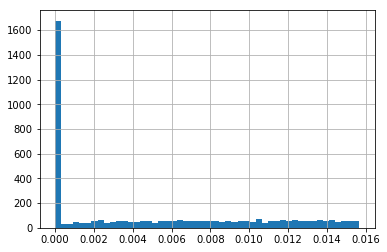

In [497]:
profile[(profile["no_promotions_spending_per_hour_aware"] < 0.015666)]["no_promotions_spending_per_hour_aware"].hist(bins=50)

In [515]:
profile[(profile["no_promotions_spending_per_hour_aware"] > profile["discount_spending_per_hour_aware"])][["discount_spending_per_hour_aware", "no_promotions_spending_per_hour_aware"]].sample(15)

,discount_spending_per_hour_aware,no_promotions_spending_per_hour_aware
12519,0.0,0.047174
7402,0.0,0.012425
9383,0.0,0.001822
6064,0.0,0.086307
15942,0.0,0.001057
10993,0.0,0.081518
12441,0.0,0.024891
2837,0.0,0.023133
16994,0.0,0.033636
14953,0.0,0.005903


In [590]:
# profile[(profile["discount_positive_response_aware"] == 1)].loc[:, ["id", "discount_spending_per_hour_aware", "no_promotions_spending_per_hour"]]

In [464]:
profile.iloc[0:15, 0:20]

,age,id,income,tenure_length,joined_date,Female,Male,Other,total_transaction_amount,total_reward_amount,discount_active_hours,bogo_active_hours,informational_active_hours,no_promotions_hours,discount_aware_hours,bogo_aware_hours,informational_aware_hours,discount_transaction_count,bogo_transaction_count,informational_transaction_count
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0,20.40,5.0,552,0,0,232,488,0,0,9,0,0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0,77.01,5.0,0,169,97,720,0,0,0,0,0,0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0,14.30,0.0,0,169,73,551,0,169,0,0,0,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0,159.27,20.0,0,386,73,465,0,230,25,0,2,2
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0,4.65,0.0,457,0,145,292,331,0,97,1,0,0
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,2018-04-26,0,1,0,57.73,7.0,385,169,97,466,152,103,0,1,1,0
6,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,304,2017-09-25,0,0,0,0.00,0.0,553,121,97,118,487,73,67,0,0,0
7,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,297,2017-10-02,0,0,0,0.24,0.0,241,459,0,429,229,62,0,1,1,0
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,2018-02-09,0,1,0,36.43,19.0,313,507,0,272,158,364,0,2,3,0
9,NaN,8974fc5686fe429db53ddde067b88302,NaN,611,2016-11-22,0,0,0,15.62,5.0,0,289,73,489,0,212,19,0,3,0


In [465]:
profile.iloc[0:15, 20:40]

,no_promotions_transaction_count,discount_spending_amount,bogo_spending_amount,informational_spending_amount,no_promotions_spending_amount,outlier_spending_amount,outlier_count,overlap_hours,max_overlap,no_promotions_spending_per_hour_aware,discount_bogo_to_no_promotion_hours_ratio_aware,discount_bogo_to_no_promotion_hours_ratio_active,informational_avg_view_to_end_time,discount_spending_per_hour_aware,bogo_spending_per_hour_aware,informational_spending_per_hour_aware,discount_spending_per_hour_active,bogo_spending_per_hour_active,informational_spending_per_hour_active,successful_discount_count
0,0,20.40,0.00,0.00,0.00,0.00,0,266,4,0.000000,2.103448,2.379310,NaN,0.140885,0.000000,0.000000,0.025616,0.000000,0.000000,2
1,3,0.00,0.00,0.00,77.01,0.00,0,0,1,0.106958,0.000000,0.234722,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,6,0.00,0.00,0.00,14.30,0.00,0,0,1,0.025953,0.306715,0.306715,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,3,0.00,41.61,49.39,68.27,0.00,0,73,2,0.146817,0.494624,0.830108,24.0,0.000000,0.376974,2.057917,0.000000,0.188487,0.685972,0
4,2,1.09,0.00,0.00,3.56,0.00,0,144,2,0.012192,1.133562,1.565068,96.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
5,2,18.42,18.42,0.00,39.31,0.00,0,73,2,0.084356,0.547210,1.188841,NaN,0.000000,0.180588,0.000000,0.045147,0.109643,0.000000,1
6,0,0.00,0.00,0.00,0.00,0.00,0,146,2,0.000000,4.745763,5.711864,66.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7,0,0.19,0.05,0.00,0.00,0.00,0,170,3,0.000000,0.678322,1.631702,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
8,0,26.89,36.43,0.00,0.00,0.00,0,218,3,0.000000,1.919118,3.014706,NaN,0.172372,0.168657,0.000000,0.065907,0.063247,0.000000,2
9,3,0.00,7.93,0.00,7.69,0.00,0,122,2,0.015726,0.433538,0.591002,18.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [466]:
profile.iloc[0:15, 40:60]

,successful_bogo_count,successful_informational_count,discount_avg_receive_to_view_time,bogo_avg_receive_to_view_time,informational_avg_receive_to_view_time,discount_avg_view_to_complete_time,bogo_avg_view_to_complete_time,discount_total_offers_count,bogo_total_offers_count,informational_total_offers_count,discount_success_rate,bogo_success_rate,informational_success_rate,discount_to_no_promotions_spending_per_hour_ratio_aware,bogo_to_no_promotions_spending_per_hour_ratio_aware,informational_to_no_promotions_spending_per_hour_ratio_aware,discount_to_no_promotions_spending_per_hour_ratio_active,bogo_to_no_promotions_spending_per_hour_ratio_active,informational_to_no_promotions_spending_per_hour_ratio_active,discount_positive_response_aware
0,0,0,13.2,NaN,NaN,96.0,NaN,5,0,0,0.4,NaN,NaN,3268.541667,0.000000,0.000000,594.280303,0.000000,0.000000,1
1,0,0,NaN,NaN,NaN,NaN,NaN,0,1,1,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0,0,NaN,0.0,NaN,NaN,NaN,0,1,1,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,2,1,NaN,28.0,48.0,NaN,114.0,0,3,1,NaN,0.666667,1.0,0.000000,2.567640,14.016863,0.000000,1.283820,4.672288,0
4,0,0,58.0,NaN,0.0,NaN,NaN,3,0,2,0.0,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
5,1,0,18.0,12.0,NaN,0.0,102.0,2,1,1,0.5,1.000000,0.0,0.000000,2.140781,0.000000,0.535195,1.299760,0.000000,0
6,0,0,28.0,48.0,30.0,NaN,NaN,3,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7,0,0,18.0,114.0,NaN,NaN,NaN,2,3,0,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
8,3,0,15.0,13.5,NaN,78.0,72.0,2,4,0,1.0,0.750000,NaN,4688.512821,4587.481481,0.000000,1792.666667,1720.305556,0.000000,1
9,0,0,NaN,15.0,54.0,NaN,NaN,0,3,1,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [467]:
profile.iloc[0:15, 60:80]

,bogo_positive_response_aware,informational_positive_response_aware,discount_positive_response_active,bogo_positive_response_active,informational_positive_response_active
0,0,0,1,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,1,0,1,1
4,0,0,0,0,0
5,1,0,0,1,0
6,0,0,0,0,0
7,0,0,0,0,0
8,1,0,1,1,0
9,0,0,0,0,0


In [602]:
profile["discount_positive_response_aware_low_margin"].value_counts()

0    8646
1    8354
Name: discount_positive_response_aware_low_margin, dtype: int64

In [603]:
profile["discount_positive_response_aware_high_margin"].value_counts()

0    8607
1    8393
Name: discount_positive_response_aware_high_margin, dtype: int64

In [606]:
profile["bogo_positive_response_aware_low_margin"].value_counts()

1.0    7104
0.0     355
Name: bogo_positive_response_aware_low_margin, dtype: int64

In [607]:
profile["bogo_positive_response_aware_high_margin"].value_counts()

1.0    7307
0.0     152
Name: bogo_positive_response_aware_high_margin, dtype: int64

In [608]:
profile["informational_positive_response_aware_low_margin"].value_counts()

0    12951
1     4049
Name: informational_positive_response_aware_low_margin, dtype: int64

### Base line prediction

In [229]:
def compute_baseline_performance(target_name, test_size, num_fold, random_state=3, profile=profile):
#     if target_type == "informational":
#         target_name = target_type + "_positive_response_aware"
#     else:
#         target_name = target_type + "_positive_response_aware_high_margin"
    full_df = profile.loc[:, ["age", "income", "tenure_length", "female", "male", "other", target_name]]
    full_df.dropna(inplace=True)

    X = full_df.iloc[:, 0:6].values
    y = full_df.iloc[:, 6].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

    folds = num_fold
    random_state = random_state

    models = []
    models.append(("LR", LogisticRegression(solver="lbfgs")))
    models.append(("LDA", LinearDiscriminantAnalysis()))
    models.append(("KNN", KNeighborsClassifier()))
    models.append(("SVC", SVC(gamma="scale")))
    models.append(("Ada", AdaBoostClassifier()))
    models.append(("RF", RandomForestClassifier(n_estimators=100)))
    models.append(("XGB", XGBClassifier()))

    f1_mean = []
    precision_mean = []
    recall_mean = []
    names = []
    for name, model in tqdm(models):
        kfold = KFold(n_splits=folds, random_state=random_state)
        cv_results_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring="f1")
        cv_results_precision = cross_val_score(model, X_train, y_train, cv=kfold, scoring="precision")
        cv_results_recall = cross_val_score(model, X_train, y_train, cv=kfold, scoring="recall")
        f1_mean.append(cv_results_f1.mean())
        precision_mean.append(cv_results_precision.mean())
        recall_mean.append(cv_results_recall.mean())
        names.append(name)
        

    print("{0} Positive Response\n".format(target_name))
    print(" Model      F1    Precision  Recall")
    for i in range(len(names)):
        
        print("  {0}:     {1:.2f}    {2:.2f}      {3:.2f}".format(names[i], f1_mean[i], precision_mean[i], recall_mean[i]))
        
    return None

In [230]:
compute_baseline_performance("discount_positive_response_aware_high_margin", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

discount_positive_response_aware_high_margin Positive Response

 Model      F1    Precision  Recall
  LR:     0.74    0.66      0.84
  LDA:     0.74    0.66      0.84
  KNN:     0.69    0.66      0.72
  SVC:     0.75    0.66      0.86
  Ada:     0.73    0.68      0.79
  RF:     0.70    0.67      0.74
  XGB:     0.73    0.69      0.78


In [231]:
compute_baseline_performance("discount_negative_response_aware_high_margin", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

discount_negative_response_aware_high_margin Positive Response

 Model      F1    Precision  Recall
  LR:     0.44    0.60      0.35
  LDA:     0.44    0.59      0.35
  KNN:     0.46    0.50      0.43
  SVC:     0.42    0.61      0.32
  Ada:     0.50    0.58      0.44
  RF:     0.47    0.52      0.43
  XGB:     0.52    0.58      0.46


In [232]:
compute_baseline_performance("bogo_positive_response_aware_high_margin", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

bogo_positive_response_aware_high_margin Positive Response

 Model      F1    Precision  Recall
  LR:     0.68    0.65      0.71
  LDA:     0.68    0.65      0.71
  KNN:     0.65    0.64      0.66
  SVC:     0.71    0.66      0.76
  Ada:     0.70    0.69      0.71
  RF:     0.67    0.66      0.68
  XGB:     0.70    0.68      0.72


In [233]:
compute_baseline_performance("bogo_negative_response_aware_high_margin", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

bogo_negative_response_aware_high_margin Positive Response

 Model      F1    Precision  Recall
  LR:     0.58    0.61      0.55
  LDA:     0.58    0.61      0.55
  KNN:     0.57    0.58      0.55
  SVC:     0.59    0.65      0.53
  Ada:     0.63    0.64      0.62
  RF:     0.58    0.61      0.56
  XGB:     0.62    0.65      0.60


In [234]:
compute_baseline_performance("informational_positive_response_aware", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


informational_positive_response_aware Positive Response

 Model      F1    Precision  Recall
  LR:     0.09    0.43      0.05
  LDA:     0.10    0.42      0.06
  KNN:     0.37    0.41      0.33
  SVC:     0.00    0.07      0.00
  Ada:     0.19    0.49      0.12
  RF:     0.34    0.42      0.29
  XGB:     0.19    0.51      0.12


In [235]:
compute_baseline_performance("informational_negative_response_aware", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

informational_negative_response_aware Positive Response

 Model      F1    Precision  Recall
  LR:     0.75    0.62      0.96
  LDA:     0.75    0.62      0.95
  KNN:     0.67    0.63      0.71
  SVC:     0.76    0.62      1.00
  Ada:     0.75    0.63      0.92
  RF:     0.68    0.63      0.74
  XGB:     0.75    0.63      0.93


In [236]:
def compute_baseline_performance_with_SMOTE(target_name, test_size, num_fold, random_state=3, profile=profile):
    random_state = random_state
    test_size=test_size
#     if target_type == "informational":
#         target_name = target_type + "_positive_response_aware"
#     elif target_type == "discount" or target_type == "bogo":
#         target_name = target_type + "_positive_response_aware_high_margin"
#     else:
#         target_name = target_type + "_positive_response"

    full_df = profile.loc[:, ["age", "income", "tenure_length", "female", "male", "other", target_name]]
    full_df.dropna(inplace=True)

    X = full_df.iloc[:, 0:6].values
    y = full_df.iloc[:, 6].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)


    kf = StratifiedKFold(n_splits=num_fold, random_state=random_state)
    sm = SMOTE(random_state=random_state, ratio = 'minority')
    lrF1Score = []
    ldaF1Score = []
    knnF1Score = []
    svmF1Score = []
    rfF1Score = []
    adaF1Score = []
    xgbF1Score = []

    lrPrecision = []
    ldaPrecision = []
    knnPrecision = []
    svmPrecision = []
    rfPrecision = []
    adaPrecision = []
    xgbPrecision = []

    lrRecall = []
    ldaRecall = []
    knnRecall = []
    svmRecall = []
    rfRecall = []
    adaRecall = []
    xgbRecall = []

    for train, validate in tqdm(kf.split(X_train, y_train), total=10): 
        """For each of the fold, we create a training and testing subsets and oversample to balance
        the dataset. The oversampling step needs to be done after each folds are made to avoid 
        'contaminating' the oversampled dataset (a good reference is 
        https://beckernick.github.io/oversampling-modeling/)."""

        train_fold = full_df.iloc[train].copy()
        validate_fold = full_df.iloc[validate].copy()

        train_fold.dropna(inplace=True)
        validate_fold.dropna(inplace=True)

        X_train_fold = train_fold.iloc[:, 0:6].values
        X_train_fold = scaler.transform(X_train_fold)
        y_train_fold = train_fold.iloc[:, 6].values

        X_validate_fold = validate_fold.iloc[:, 0:6].values
        X_validate_fold = scaler.transform(X_validate_fold)
        y_validate_fold = validate_fold.iloc[:, 6].values
        X_train_resample, y_train_resample = sm.fit_sample(X_train_fold, y_train_fold)

        lr = LogisticRegression(solver="lbfgs")
        lr.fit(X_train_resample, y_train_resample)
        lrPred = lr.predict(X_validate_fold)
        lrF1Score.append(f1_score(y_validate_fold, lrPred, average=None)[1])
        lrPrecision.append(precision_score(y_validate_fold, lrPred, average=None)[1])
        lrRecall.append(recall_score(y_validate_fold, lrPred, average=None)[1])

        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_resample, y_train_resample)
        ldaPred = lda.predict(X_validate_fold)
        ldaF1Score.append(f1_score(y_validate_fold, ldaPred, average=None)[1])
        ldaPrecision.append(precision_score(y_validate_fold, ldaPred, average=None)[1])
        ldaRecall.append(recall_score(y_validate_fold, ldaPred, average=None)[1])

        knn = KNeighborsClassifier()
        knn.fit(X_train_resample, y_train_resample)
        knnPred = knn.predict(X_validate_fold)
        knnF1Score.append(f1_score(y_validate_fold, knnPred, average=None)[1])
        knnPrecision.append(precision_score(y_validate_fold, knnPred, average=None)[1])
        knnRecall.append(recall_score(y_validate_fold, knnPred, average=None)[1])

        svm = SVC(gamma="scale")
        svm.fit(X_train_resample, y_train_resample)
        svmPred = svm.predict(X_validate_fold)
        svmF1Score.append(f1_score(y_validate_fold, svmPred, average=None)[1])
        svmPrecision.append(precision_score(y_validate_fold, svmPred, average=None)[1])
        svmRecall.append(recall_score(y_validate_fold, svmPred, average=None)[1])

        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_train_resample, y_train_resample)
        rfPred = rf.predict(X_validate_fold)
        rfF1Score.append(f1_score(y_validate_fold, rfPred, average=None)[1])
        rfPrecision.append(precision_score(y_validate_fold, rfPred, average=None)[1])
        rfRecall.append(recall_score(y_validate_fold, rfPred, average=None)[1])

        ada = AdaBoostClassifier()
        ada.fit(X_train_resample, y_train_resample)
        adaPred = ada.predict(X_validate_fold)
        adaF1Score.append(f1_score(y_validate_fold, adaPred, average=None)[1])
        adaPrecision.append(precision_score(y_validate_fold, adaPred, average=None)[1])
        adaRecall.append(recall_score(y_validate_fold, adaPred, average=None)[1])

        xgb = XGBClassifier()
        xgb.fit(X_train_resample, y_train_resample)
        xgbPred = xgb.predict(X_validate_fold)
        xgbF1Score.append(f1_score(y_validate_fold, xgbPred, average=None)[1])
        xgbPrecision.append(precision_score(y_validate_fold, xgbPred, average=None)[1])
        xgbRecall.append(recall_score(y_validate_fold, xgbPred, average=None)[1])

    print("{0} Positive Response".format(target_name))
    print(" Model      F1    Precision  Recall")
    print("  {0}:     {1:.2f}    {2:.2f}      {3:.2f}".format("LR", sum(lrF1Score)/10, sum(lrPrecision)/10, sum(lrRecall)/10))
    print("  {0}:     {1:.2f}    {2:.2f}      {3:.2f}".format("LDA", sum(ldaF1Score)/10, sum(ldaPrecision)/10, sum(ldaRecall)/10))
    print("  {0}:     {1:.2f}    {2:.2f}      {3:.2f}".format("KNN", sum(knnF1Score)/10, sum(knnPrecision)/10, sum(knnRecall)/10))
    print("  {0}:     {1:.2f}    {2:.2f}      {3:.2f}".format("SVM", sum(svmF1Score)/10, sum(svmPrecision)/10, sum(svmRecall)/10))
    print("  {0}:     {1:.2f}    {2:.2f}      {3:.2f}".format("RF", sum(rfF1Score)/10, sum(rfPrecision)/10, sum(rfRecall)/10))
    print("  {0}:     {1:.2f}    {2:.2f}      {3:.2f}".format("Ada", sum(adaF1Score)/10, sum(adaPrecision)/10, sum(adaRecall)/10))
    print("  {0}:     {1:.2f}    {2:.2f}      {3:.2f}".format("XGB", sum(xgbF1Score)/10, sum(xgbPrecision)/10, sum(xgbRecall)/10))
    


In [494]:
compute_baseline_performance_with_SMOTE("discount_positive_response_aware_high_margin", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

discount_positive_response_aware_high_margin Positive Response
 Model      F1    Precision  Recall
  LR:     0.63    0.73      0.56
  LDA:     0.63    0.72      0.56
  KNN:     0.63    0.66      0.59
  SVM:     0.67    0.72      0.62
  RF:     0.67    0.67      0.67
  Ada:     0.66    0.73      0.61
  XGB:     0.68    0.72      0.65


In [495]:
compute_baseline_performance_with_SMOTE("bogo_positive_response_aware_high_margin", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

bogo_positive_response_aware_high_margin Positive Response
 Model      F1    Precision  Recall
  LR:     0.64    0.66      0.61
  LDA:     0.63    0.66      0.61
  KNN:     0.62    0.64      0.61
  SVM:     0.68    0.68      0.67
  RF:     0.64    0.65      0.64
  Ada:     0.67    0.70      0.64
  XGB:     0.69    0.69      0.69


In [496]:
compute_baseline_performance_with_SMOTE("informational_positive_response_aware", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

informational_positive_response_aware Positive Response
 Model      F1    Precision  Recall
  LR:     0.45    0.44      0.46
  LDA:     0.45    0.44      0.46
  KNN:     0.45    0.41      0.50
  SVM:     0.49    0.46      0.52
  RF:     0.43    0.44      0.42
  Ada:     0.51    0.44      0.60
  XGB:     0.48    0.45      0.52


In [546]:
def train_model_for_offer_type(offer_type, test_size=0.2, profile=profile):
    if offer_type == "informational":
        offer_col_name = offer_type + "_positive_response_aware"
    else:
        offer_col_name = offer_type + "_positive_response_aware_high_margin"
    print(offer_col_name)
    ml_ready_df = profile.loc[:, ["age", "income", "tenure_length", "female", "male", "other", offer_col_name]]

    test_size=test_size
    random_state = 3

    ml_ready_df.dropna(inplace=True)

    X = ml_ready_df.iloc[:, 0:6].values
    y = ml_ready_df.iloc[:, 6].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

    model = AdaBoostClassifier()
    
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    f1_scr = f1_score(y_test, pred)
    precision_scr = precision_score(y_test, pred)
    recall_scr = recall_score(y_test, pred)
    
    print("AdaBoost")
    print(offer_col_name + "\n")
    print("F1    Precision  Recall")
    print("{0:.2f}     {1:.2f}    {2:.2f}\n".format(f1_scr, precision_scr, recall_scr))
    
    importance = model.feature_importances_

    
    print("Feature Importance:")
    print("age    income   tenure  female    male    other")
    print("{0:.2f}   {1:.2f}     {2:.2f}    {3:.2f}      {4:.2f}    {5:.2f}".format(importance[0], importance[1], importance[2], importance[3], importance[4], importance[5]))
    

    return model


In [543]:
discount_model = train_model_for_offer_type("discount")

discount_positive_response_aware_high_margin
AdaBoost
discount_positive_response_aware_high_margin

F1    Precision  Recall
0.74     0.69    0.80

Feature Importance:
age    income   tenure  female    male    other
0.26   0.20     0.50    0.00      0.02    0.02


In [539]:
discount_model = train_model_for_offer_type("bogo")

AdaBoost
bogo_positive_response_aware_high_margin

F1    Precision  Recall
0.68     0.67    0.69

Feature Importance:
age    income   tenure  female    male    other
0.18   0.28     0.48    0.02      0.02    0.02


In [547]:
discount_model = train_model_for_offer_type("informational")

informational_positive_response_aware
AdaBoost
informational_positive_response_aware

F1    Precision  Recall
0.17     0.49    0.10

Feature Importance:
age    income   tenure  female    male    other
0.30   0.22     0.46    0.00      0.00    0.02


In [581]:
def make_train_test_sets(offer_type, test_size=0.2, profile=profile):
    if offer_type == "informational":
        offer_col_name = offer_type + "_positive_response_aware"
    else:
        offer_col_name = offer_type + "_positive_response_aware_high_margin"
    ml_ready_df = profile.loc[:, ["age", "income", "tenure_length", "female", "male", "other", offer_col_name]]

    test_size=test_size
    random_state = 3

    ml_ready_df.dropna(inplace=True)

    X = ml_ready_df.iloc[:, 0:6].values
    y = ml_ready_df.iloc[:, 6].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [597]:
def optimize_model(offer_type, model_name, model_params, scoring="f1", nsplits=10, random_state=3):
    if model_name == "AdaBoost":
        model = AdaBoostClassifier()
    elif model_name == "XGBoost":
        model = XGBoostClassifier()
    elif model_name == "RandomForest":
        model = RandomForestClassifier()
    elif model_name == "SVC":
        model = SVC()
    X_train, X_test, y_train, y_test = make_train_test_sets(offer_type)
    kfold = KFold(n_splits=10, random_state=3)
    grid = GridSearchCV(estimator=model, param_grid=model_params, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, y_train)
    print("Optimizing for {0} using {1}".format(offer_type, model_name))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [601]:
model_name = "AdaBoost"
n_estimators = [10, 30, 50, 80, 100]
learning_rate = [0.01, 0.1, 1, 10, 50]
algorithm = ["SAMME", "SAMME.R"]
param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm)


In [ ]:
optimize_model("discount", model_name, param_grid)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:580: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: R

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:580: RuntimeWarning: 

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWar

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWar

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:580: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:579: R

### Models for individual offers are not accurate at all.

In [458]:
compute_baseline_performance_with_SMOTE("ae264e3637204a6fb9bb56bc8210ddfd_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

ae264e3637204a6fb9bb56bc8210ddfd_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.74    0.98      0.59
  LDA:     0.73    0.98      0.58
  KNN:     0.86    0.97      0.78
  SVM:     0.75    0.97      0.61
  RF:     0.93    0.97      0.89
  Ada:     0.80    0.98      0.68
  XGB:     0.83    0.98      0.73


In [460]:
compute_baseline_performance_with_SMOTE("ae264e3637204a6fb9bb56bc8210ddfd_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

ae264e3637204a6fb9bb56bc8210ddfd_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.08    0.04      0.59
  LDA:     0.08    0.04      0.59
  KNN:     0.07    0.04      0.32
  SVM:     0.07    0.04      0.44
  RF:     0.06    0.04      0.11
  Ada:     0.08    0.04      0.49
  XGB:     0.08    0.04      0.41


In [461]:
compute_baseline_performance_with_SMOTE("4d5c57ea9a6940dd891ad53e9dbe8da0_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

4d5c57ea9a6940dd891ad53e9dbe8da0_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.69    0.97      0.54
  LDA:     0.69    0.97      0.54
  KNN:     0.86    0.97      0.78
  SVM:     0.69    0.98      0.53
  RF:     0.93    0.97      0.89
  Ada:     0.79    0.97      0.67
  XGB:     0.82    0.97      0.71


In [462]:
compute_baseline_performance_with_SMOTE("4d5c57ea9a6940dd891ad53e9dbe8da0_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

4d5c57ea9a6940dd891ad53e9dbe8da0_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.05    0.03      0.45
  LDA:     0.05    0.03      0.45
  KNN:     0.05    0.03      0.20
  SVM:     0.06    0.03      0.53
  RF:     0.05    0.03      0.09
  Ada:     0.05    0.03      0.33
  XGB:     0.06    0.03      0.36


In [463]:
compute_baseline_performance_with_SMOTE("3f207df678b143eea3cee63160fa8bed_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

3f207df678b143eea3cee63160fa8bed_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.69    0.97      0.53
  LDA:     0.69    0.97      0.53
  KNN:     0.86    0.98      0.76
  SVM:     0.68    0.98      0.52
  RF:     0.93    0.98      0.89
  Ada:     0.78    0.98      0.66
  XGB:     0.83    0.98      0.73


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [464]:
compute_baseline_performance_with_SMOTE("3f207df678b143eea3cee63160fa8bed_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

3f207df678b143eea3cee63160fa8bed_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.02    0.01      0.18
  LDA:     0.02    0.01      0.18
  KNN:     0.03    0.02      0.27
  SVM:     0.03    0.02      0.40
  RF:     0.04    0.03      0.10
  Ada:     0.02    0.01      0.32
  XGB:     0.03    0.02      0.31


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [465]:
compute_baseline_performance_with_SMOTE("9b98b8c7a33c4b65b9aebfe6a799e6d9_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

9b98b8c7a33c4b65b9aebfe6a799e6d9_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.66    0.95      0.51
  LDA:     0.67    0.95      0.51
  KNN:     0.84    0.96      0.75
  SVM:     0.61    0.96      0.45
  RF:     0.92    0.96      0.88
  Ada:     0.75    0.96      0.61
  XGB:     0.81    0.96      0.70


In [466]:
compute_baseline_performance_with_SMOTE("9b98b8c7a33c4b65b9aebfe6a799e6d9_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

9b98b8c7a33c4b65b9aebfe6a799e6d9_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.06    0.03      0.37
  LDA:     0.06    0.03      0.39
  KNN:     0.07    0.04      0.26
  SVM:     0.07    0.04      0.56
  RF:     0.04    0.03      0.11
  Ada:     0.07    0.04      0.39
  XGB:     0.07    0.04      0.31


In [467]:
compute_baseline_performance_with_SMOTE("0b1e1539f2cc45b7b9fa7c272da2e1d7_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: Undefined

0b1e1539f2cc45b7b9fa7c272da2e1d7_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.68    0.97      0.53
  LDA:     0.68    0.97      0.53
  KNN:     0.89    0.98      0.82
  SVM:     0.73    0.98      0.58
  RF:     0.94    0.98      0.90
  Ada:     0.79    0.98      0.67
  XGB:     0.87    0.98      0.78


In [468]:
compute_baseline_performance_with_SMOTE("0b1e1539f2cc45b7b9fa7c272da2e1d7_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: Undefined

0b1e1539f2cc45b7b9fa7c272da2e1d7_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.02    0.01      0.14
  LDA:     0.02    0.01      0.14
  KNN:     0.06    0.04      0.22
  SVM:     0.03    0.02      0.26
  RF:     0.04    0.02      0.13
  Ada:     0.03    0.01      0.20
  XGB:     0.04    0.02      0.17


In [469]:
compute_baseline_performance_with_SMOTE("2298d6c36e964ae4a3e7e9706d1fb8c2_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

2298d6c36e964ae4a3e7e9706d1fb8c2_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.68    0.98      0.52
  LDA:     0.68    0.98      0.52
  KNN:     0.88    0.98      0.80
  SVM:     0.70    0.98      0.55
  RF:     0.94    0.97      0.90
  Ada:     0.76    0.98      0.63
  XGB:     0.83    0.98      0.72


In [470]:
compute_baseline_performance_with_SMOTE("2298d6c36e964ae4a3e7e9706d1fb8c2_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

2298d6c36e964ae4a3e7e9706d1fb8c2_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.06    0.03      0.61
  LDA:     0.06    0.03      0.61
  KNN:     0.07    0.04      0.26
  SVM:     0.07    0.04      0.60
  RF:     0.07    0.05      0.16
  Ada:     0.06    0.03      0.45
  XGB:     0.07    0.04      0.37


In [471]:
compute_baseline_performance_with_SMOTE("fafdcd668e3743c1bb461111dcafc2a4_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

fafdcd668e3743c1bb461111dcafc2a4_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.75    0.98      0.60
  LDA:     0.75    0.98      0.60
  KNN:     0.87    0.98      0.79
  SVM:     0.76    0.98      0.62
  RF:     0.94    0.98      0.90
  Ada:     0.83    0.98      0.71
  XGB:     0.85    0.98      0.75


In [472]:
compute_baseline_performance_with_SMOTE("fafdcd668e3743c1bb461111dcafc2a4_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

fafdcd668e3743c1bb461111dcafc2a4_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.06    0.03      0.57
  LDA:     0.06    0.03      0.57
  KNN:     0.04    0.02      0.25
  SVM:     0.06    0.03      0.58
  RF:     0.04    0.03      0.13
  Ada:     0.06    0.03      0.41
  XGB:     0.06    0.03      0.39


In [473]:
compute_baseline_performance_with_SMOTE("5a8bc65990b245e5a138643cd4eb9837_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

5a8bc65990b245e5a138643cd4eb9837_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.70    0.98      0.54
  LDA:     0.70    0.98      0.54
  KNN:     0.87    0.98      0.79
  SVM:     0.70    0.98      0.54
  RF:     0.94    0.98      0.90
  Ada:     0.76    0.98      0.62
  XGB:     0.80    0.98      0.67


In [474]:
compute_baseline_performance_with_SMOTE("5a8bc65990b245e5a138643cd4eb9837_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

5a8bc65990b245e5a138643cd4eb9837_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.03    0.01      0.37
  LDA:     0.03    0.01      0.37
  KNN:     0.02    0.01      0.15
  SVM:     0.03    0.01      0.43
  RF:     0.01    0.00      0.03
  Ada:     0.03    0.01      0.35
  XGB:     0.02    0.01      0.27


In [475]:
compute_baseline_performance_with_SMOTE("f19421c1d4aa40978ebb69ca19b0e20d_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

f19421c1d4aa40978ebb69ca19b0e20d_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.70    0.97      0.54
  LDA:     0.70    0.97      0.54
  KNN:     0.86    0.97      0.76
  SVM:     0.71    0.97      0.56
  RF:     0.92    0.97      0.88
  Ada:     0.75    0.97      0.62
  XGB:     0.82    0.97      0.71


In [476]:
compute_baseline_performance_with_SMOTE("f19421c1d4aa40978ebb69ca19b0e20d_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

f19421c1d4aa40978ebb69ca19b0e20d_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.05    0.02      0.43
  LDA:     0.05    0.02      0.43
  KNN:     0.03    0.02      0.19
  SVM:     0.05    0.03      0.48
  RF:     0.02    0.02      0.05
  Ada:     0.05    0.03      0.40
  XGB:     0.05    0.03      0.26


In [477]:
compute_baseline_performance_with_SMOTE("2906b810c7d4411798c6938adc9daaa5_positive_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

2906b810c7d4411798c6938adc9daaa5_positive_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.68    0.97      0.52
  LDA:     0.68    0.97      0.52
  KNN:     0.86    0.97      0.77
  SVM:     0.63    0.97      0.47
  RF:     0.92    0.97      0.88
  Ada:     0.79    0.97      0.67
  XGB:     0.85    0.97      0.76


In [478]:
compute_baseline_performance_with_SMOTE("2906b810c7d4411798c6938adc9daaa5_negative_response", 0.2, 10)

/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

2906b810c7d4411798c6938adc9daaa5_negative_response Positive Response
 Model      F1    Precision  Recall
  LR:     0.07    0.04      0.50
  LDA:     0.07    0.04      0.50
  KNN:     0.04    0.02      0.28
  SVM:     0.06    0.03      0.55
  RF:     0.03    0.02      0.09
  Ada:     0.08    0.04      0.50
  XGB:     0.06    0.04      0.36


The above study showed that:
1) Predicting individual offers is better
2) Predicting who DOESN'T respond well is better
3) Random Forest seems to outperform other models I tested

In [410]:
def train_model_for_individual_offer(offer_id, negative=True, test_size=0.2, profile=profile):
    if negative == True:
        offer_col_name = offer_id + "_negative_response"
    elif negative == False:
        offer_col_name = offer_id + "_positive_response"
    ml_ready_df = profile.loc[:, ["age", "income", "tenure_length", "female", "male", "other", offer_col_name]]

    test_size=test_size
    random_state = 3

    ml_ready_df.dropna(inplace=True)

    X = ml_ready_df.iloc[:, 0:6].values
    y = ml_ready_df.iloc[:, 6].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    f1_scr = f1_score(y_test, pred)
    precision_scr = precision_score(y_test, pred)
    recall_scr = recall_score(y_test, pred)
    
    print("RF model")
    print(offer_col_name + "\n")
    print("F1    Precision  Recall")
    print("{0:.2f}     {1:.2f}    {2:.2f}\n".format(f1_scr, precision_scr, recall_scr))
    
    importance = model.feature_importances_
    
    print("Feature Importance:")
    print("age    income   tenure  female    male    other")
    print("{0:.2f}   {1:.2f}     {2:.2f}    {3:.2f}      {4:.2f}    {5:.2f}".format(importance[0], importance[1], importance[2], importance[3], importance[4], importance[5]))
    

    return model


In [483]:
model_ae264e3637204a6fb9bb56bc8210ddfd = train_model_for_individual_offer("ae264e3637204a6fb9bb56bc8210ddfd", True)

RF model
ae264e3637204a6fb9bb56bc8210ddfd_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.25   0.29     0.43    0.01      0.02    0.00


In [484]:
model_4d5c57ea9a6940dd891ad53e9dbe8da0 = train_model_for_individual_offer("4d5c57ea9a6940dd891ad53e9dbe8da0", True)

RF model
4d5c57ea9a6940dd891ad53e9dbe8da0_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.27   0.25     0.46    0.01      0.01    0.00


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [485]:
model_3f207df678b143eea3cee63160fa8bed = train_model_for_individual_offer("3f207df678b143eea3cee63160fa8bed", True)

RF model
3f207df678b143eea3cee63160fa8bed_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.28   0.26     0.42    0.01      0.02    0.01


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [486]:
model_9b98b8c7a33c4b65b9aebfe6a799e6d9 = train_model_for_individual_offer("9b98b8c7a33c4b65b9aebfe6a799e6d9", True)

RF model
9b98b8c7a33c4b65b9aebfe6a799e6d9_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.26   0.26     0.45    0.01      0.01    0.00


In [487]:
model_0b1e1539f2cc45b7b9fa7c272da2e1d7 = train_model_for_individual_offer("0b1e1539f2cc45b7b9fa7c272da2e1d7", True)

RF model
0b1e1539f2cc45b7b9fa7c272da2e1d7_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.25   0.26     0.45    0.02      0.02    0.01


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [488]:
model_2298d6c36e964ae4a3e7e9706d1fb8c2 = train_model_for_individual_offer("2298d6c36e964ae4a3e7e9706d1fb8c2", True)

RF model
2298d6c36e964ae4a3e7e9706d1fb8c2_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.25   0.27     0.46    0.01      0.01    0.00


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [489]:
model_fafdcd668e3743c1bb461111dcafc2a4 = train_model_for_individual_offer("fafdcd668e3743c1bb461111dcafc2a4", True)

RF model
fafdcd668e3743c1bb461111dcafc2a4_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.24   0.28     0.46    0.01      0.01    0.00


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [490]:
model_5a8bc65990b245e5a138643cd4eb9837 = train_model_for_individual_offer("5a8bc65990b245e5a138643cd4eb9837", True)

RF model
5a8bc65990b245e5a138643cd4eb9837_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.27   0.25     0.47    0.01      0.01    0.00


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [491]:
model_f19421c1d4aa40978ebb69ca19b0e20d = train_model_for_individual_offer("f19421c1d4aa40978ebb69ca19b0e20d", True)

RF model
f19421c1d4aa40978ebb69ca19b0e20d_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.26   0.26     0.45    0.01      0.01    0.00


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [492]:
model_2906b810c7d4411798c6938adc9daaa5 = train_model_for_individual_offer("2906b810c7d4411798c6938adc9daaa5", True)

RF model
2906b810c7d4411798c6938adc9daaa5_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.26   0.27     0.45    0.01      0.01    0.00


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [493]:
model_2906b810c7d4411798c6938adc9daaa5 = train_model_for_individual_offer("2906b810c7d4411798c6938adc9daaa5", True)

RF model
2906b810c7d4411798c6938adc9daaa5_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.26   0.27     0.44    0.01      0.01    0.00


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [407]:
def get_test_inputs(offer_id, negative=True, test_size=0.2, profile=profile):
    if negative == True:
        offer_col_name = offer_id + "_negative_response"
    elif negative == False:
        offer_col_name = offer_id + "_positive_response"
    ml_ready_df = profile.loc[:, ["age", "income", "tenure_length", "female", "male", "other", offer_col_name]]

    test_size=test_size
    random_state = 3

    ml_ready_df.dropna(inplace=True)

    X = ml_ready_df.iloc[:, 0:6].values
    y = ml_ready_df.iloc[:, 6].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)
    print("Retrieving {0}".format(offer_col_name))
    return X_test, y_test

In [447]:
negative = True
odi = "ae264e3637204a6fb9bb56bc8210ddfd"
test_size = 0.2

In [448]:
model_test = train_model_for_individual_offer(oid, negative, test_size)

RF model
2906b810c7d4411798c6938adc9daaa5_negative_response

F1    Precision  Recall
0.00     0.00    0.00

Feature Importance:
age    income   tenure  female    male    other
0.27   0.28     0.42    0.01      0.01    0.00


/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [449]:
X_test, y_test = get_test_inputs(oid, negative, test_size)

Retrieving 2906b810c7d4411798c6938adc9daaa5_negative_response


In [450]:
pred = model_test.predict(X_test)

In [451]:
pred = pd.Series(pred, name="Prediction")
actu = pd.Series(y_test, name="Actual")

In [452]:
df_confusion_mat = pd.crosstab(actu, pred, margins=True)

In [453]:
df_confusion_mat # positive

Prediction,0.0,All
Actual,,
0.0,355,355
1.0,15,15
All,370,370


In [454]:
profile["9b98b8c7a33c4b65b9aebfe6a799e6d9_positive_response"].value_counts()

1.0    1884
0.0      72
Name: 9b98b8c7a33c4b65b9aebfe6a799e6d9_positive_response, dtype: int64

In [456]:
profile["9b98b8c7a33c4b65b9aebfe6a799e6d9_offer_count"].count()

1956

In [346]:
portfolio["id"]

0    ae264e3637204a6fb9bb56bc8210ddfd
1    4d5c57ea9a6940dd891ad53e9dbe8da0
2    3f207df678b143eea3cee63160fa8bed
3    9b98b8c7a33c4b65b9aebfe6a799e6d9
4    0b1e1539f2cc45b7b9fa7c272da2e1d7
5    2298d6c36e964ae4a3e7e9706d1fb8c2
6    fafdcd668e3743c1bb461111dcafc2a4
7    5a8bc65990b245e5a138643cd4eb9837
8    f19421c1d4aa40978ebb69ca19b0e20d
9    2906b810c7d4411798c6938adc9daaa5
Name: id, dtype: object

In [317]:
profile["ae264e3637204a6fb9bb56bc8210ddfd_negative_response"].value_counts()

1    14745
0     2255
Name: ae264e3637204a6fb9bb56bc8210ddfd_negative_response, dtype: int64

In [312]:
offers_grouped = offers.groupby(by="customer_id")

In [330]:
offers_grouped["offer_id"].get_group

Int64Index([60054, 60055, 60056, 60057, 60058], dtype='int64')

In [320]:
offers.transaction_amount_sum.describe()

count    76277.000000
mean        23.785996
std         30.643797
min          0.000000
25%          1.290000
50%         12.090000
75%         34.250000
max        277.610000
Name: transaction_amount_sum, dtype: float64

In [325]:
offers

,customer_id,offer_id,received_time,viewed_time,completed_time,end_time,offer_type,transaction_amount_sum,spending_per_hour,receive_to_view_time,view_to_complete_time,success,web,email,mobile,social
0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,168.0,216.0,NaN,336.0,discount,0.00,NaN,48.0,NaN,0.0,1.0,1.0,1.0,0.0
1,68be06ca386d4c31939f3a4f0e3dd783,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,348.0,NaN,576.0,discount,10.52,NaN,12.0,NaN,0.0,1.0,1.0,0.0,0.0
2,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,408.0,408.0,552.0,648.0,discount,14.84,0.103056,0.0,144.0,1.0,1.0,1.0,1.0,1.0
3,68be06ca386d4c31939f3a4f0e3dd783,2298d6c36e964ae4a3e7e9706d1fb8c2,504.0,504.0,552.0,672.0,discount,12.21,0.254375,0.0,48.0,1.0,1.0,1.0,1.0,1.0
4,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,576.0,582.0,NaN,816.0,discount,9.88,NaN,6.0,NaN,0.0,1.0,1.0,1.0,1.0
5,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,408.0,NaN,528.0,576.0,bogo,23.22,0.138214,NaN,NaN,0.0,1.0,1.0,1.0,0.0
6,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,504.0,NaN,NaN,600.0,informational,23.22,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0
7,38fe809add3b4fcf9315a9694bb96ff5,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0,168.0,NaN,336.0,bogo,0.00,NaN,0.0,NaN,0.0,1.0,1.0,1.0,0.0
8,38fe809add3b4fcf9315a9694bb96ff5,5a8bc65990b245e5a138643cd4eb9837,576.0,NaN,NaN,648.0,informational,2.14,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0
9,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6.0,132.0,168.0,bogo,37.67,0.285379,6.0,126.0,1.0,1.0,1.0,1.0,0.0


In [634]:
transcript[(transcript["event_type_offer_received"] == 1)]["time"].value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

In [638]:
offers.head(15)

,customer_id,offer_id,received_time,viewed_time,completed_time,end_time,offer_type,transaction_amount_sum,spending_per_hour,receive_to_view_time,view_to_complete_time,success,web,email,mobile,social
0,68be06ca386d4c31939f3a4f0e3dd783,2906b810c7d4411798c6938adc9daaa5,168.0,216.0,NaN,336.0,discount,0.00,NaN,48.0,NaN,0.0,1.0,1.0,1.0,0.0
1,68be06ca386d4c31939f3a4f0e3dd783,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,348.0,NaN,576.0,discount,10.52,NaN,12.0,NaN,0.0,1.0,1.0,0.0,0.0
2,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,408.0,408.0,552.0,648.0,discount,14.84,0.103056,0.0,144.0,1.0,1.0,1.0,1.0,1.0
3,68be06ca386d4c31939f3a4f0e3dd783,2298d6c36e964ae4a3e7e9706d1fb8c2,504.0,504.0,552.0,672.0,discount,12.21,0.254375,0.0,48.0,1.0,1.0,1.0,1.0,1.0
4,68be06ca386d4c31939f3a4f0e3dd783,fafdcd668e3743c1bb461111dcafc2a4,576.0,582.0,NaN,816.0,discount,9.88,NaN,6.0,NaN,0.0,1.0,1.0,1.0,1.0
5,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,408.0,NaN,528.0,576.0,bogo,23.22,0.138214,NaN,NaN,0.0,1.0,1.0,1.0,0.0
6,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,504.0,NaN,NaN,600.0,informational,23.22,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0
7,38fe809add3b4fcf9315a9694bb96ff5,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0,168.0,NaN,336.0,bogo,0.00,NaN,0.0,NaN,0.0,1.0,1.0,1.0,0.0
8,38fe809add3b4fcf9315a9694bb96ff5,5a8bc65990b245e5a138643cd4eb9837,576.0,NaN,NaN,648.0,informational,2.14,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0
9,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,6.0,132.0,168.0,bogo,37.67,0.285379,6.0,126.0,1.0,1.0,1.0,1.0,0.0


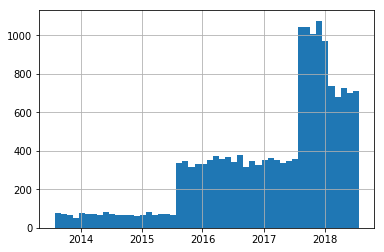

In [28]:
profile["joined_date"].hist(bins=50);

In [433]:
profile_copy = profile.copy()

In [434]:
profile_copy.index = profile_copy["joined_date"]

In [435]:
joined_date_hist = profile_copy.groupby(pd.Grouper(freq='M')).describe()

In [436]:
joined_date_hist.iloc[40:60, 0]

joined_date
2016-11-30    245.0
2016-12-31    240.0
2017-01-31    250.0
2017-02-28    239.0
2017-03-31    236.0
2017-04-30    252.0
2017-05-31    234.0
2017-06-30    260.0
2017-07-31    345.0
2017-08-31    770.0
2017-09-30    718.0
2017-10-31    800.0
2017-11-30    698.0
2017-12-31    797.0
2018-01-31    705.0
2018-02-28    452.0
2018-03-31    540.0
2018-04-30    508.0
2018-05-31    528.0
2018-06-30    486.0
Freq: M, Name: (age, count), dtype: float64

In [437]:
joined_date_hist.iloc[:, 0].sum()

14825.0

In [35]:
joined_date_hist.iloc[0:25, 0].sum()

1355.0

In [36]:
joined_date_hist.iloc[25:49, 0].sum()

6018.0

In [37]:
joined_date_hist.iloc[50:55, 0].sum()

3718.0

In [38]:
joined_date_hist.iloc[55:, 0].sum()

2964.0

There seems to be abrupt changes in the number of newly joined customers around mid 2015, mid 2017, and early 2018. This might indicate that different numbers of samples were taken from different time frames. We should keep this in mind, especially when we generalize the findings at the end of this study.

In [309]:
profile.head()

,age,id,income,tenure_length,joined_date,Female,Male,Other,total_transaction_amount,total_reward_amount,...,informational_to_no_promotions_spending_per_hour_ratio_aware,discount_to_no_promotions_spending_per_hour_ratio_active,bogo_to_no_promotions_spending_per_hour_ratio_active,informational_to_no_promotions_spending_per_hour_ratio_active,discount_positive_response_aware,bogo_positive_response_aware,informational_positive_response_aware,discount_positive_response_active,bogo_positive_response_active,informational_positive_response_active
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0,20.40,5.0,...,NaN,798.26087,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0,77.01,5.0,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0,0.0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0,14.30,0.0,...,NaN,NaN,2.943543,0.000000,NaN,1.0,NaN,NaN,1.0,0.0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0,159.27,20.0,...,9.462739,NaN,0.447874,3.240664,NaN,0.0,1.0,NaN,0.0,1.0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0,4.65,0.0,...,0.000000,3.87500,NaN,0.000000,1.0,NaN,0.0,1.0,NaN,0.0


In [420]:
profile[profile["discount_total_offers_count"] != 0]["discount_positive_response_aware"].value_counts()

1.0    8095
0.0     472
Name: discount_positive_response_aware, dtype: int64

In [421]:
profile[profile["bogo_total_offers_count"] != 0]["bogo_positive_response_aware"].value_counts()

1.0    7207
0.0     299
Name: bogo_positive_response_aware, dtype: int64

In [422]:
profile[profile["informational_total_offers_count"] != 0]["informational_positive_response_aware"].value_counts()

1.0    4259
0.0    3441
Name: informational_positive_response_aware, dtype: int64

In [423]:
profile[(profile["discount_total_offers_count"] != 0) & (profile["bogo_total_offers_count"] != 0)]["discount_positive_response_aware"].value_counts()

1.0    6876
0.0     417
Name: discount_positive_response_aware, dtype: int64

In [426]:
profile[(profile["discount_total_offers_count"] != 0) & (profile["bogo_total_offers_count"] != 0) & (profile["bogo_positive_response_aware"] == 0)][["bogo_avg_receive_to_view_time", "bogo_avg_view_to_complete_time"]]

,bogo_avg_receive_to_view_time,bogo_avg_view_to_complete_time
10,108.0,0.0
62,36.0,108.0
165,0.0,66.0
170,6.0,126.0
184,12.0,66.0
197,6.0,66.0
405,6.0,84.0
504,0.0,42.0
677,0.0,54.0
695,12.0,120.0


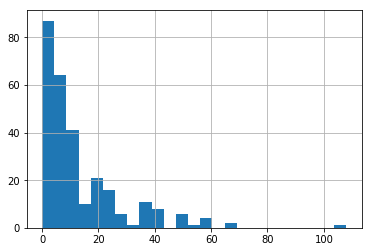

In [433]:
profile[(profile["discount_total_offers_count"] != 0) & (profile["bogo_total_offers_count"] != 0) & (profile["bogo_positive_response_aware"] == 0)]["bogo_avg_receive_to_view_time"].hist(bins=25)

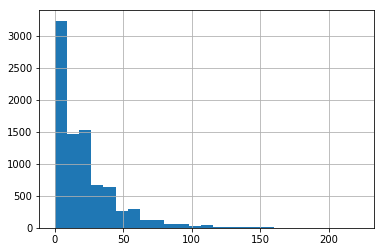

In [456]:
profile["discount_avg_receive_to_view_time"].hist(bins=25)

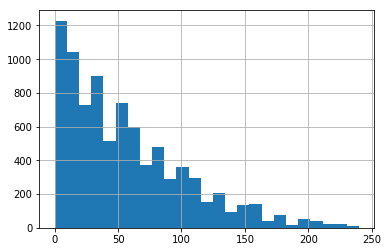

In [457]:
profile["discount_avg_view_to_complete_time"].hist(bins=25)

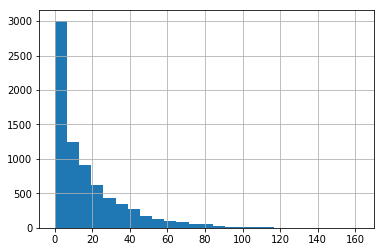

In [455]:
profile["bogo_avg_receive_to_view_time"].hist(bins=25)

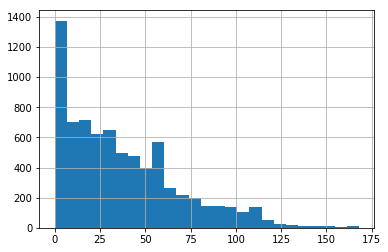

In [452]:
profile["bogo_avg_view_to_complete_time"].hist(bins=25)

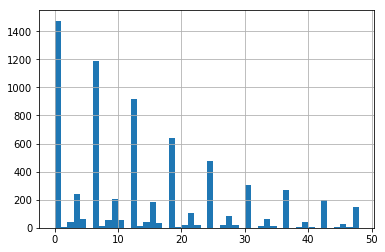

In [451]:
profile[(profile["bogo_avg_receive_to_view_time"] <= 48)]["bogo_avg_receive_to_view_time"].hist(bins=48)

In [450]:
profile[(profile["bogo_avg_receive_to_view_time"].notnull()) & (profile["bogo_avg_receive_to_view_time"] <= 24)]["bogo_avg_receive_to_view_time"].value_counts()

0.0     1475
6.0     1187
12.0     920
18.0     640
24.0     473
3.0      238
9.0      207
15.0     181
21.0     108
4.0       57
8.0       54
10.0      50
14.0      39
2.0       39
16.0      28
20.0      19
22.0      19
13.5      10
7.5        9
10.5       7
16.5       6
4.5        5
22.5       4
1.5        3
19.5       2
19.2       2
3.6        1
7.2        1
2.4        1
14.4       1
Name: bogo_avg_receive_to_view_time, dtype: int64

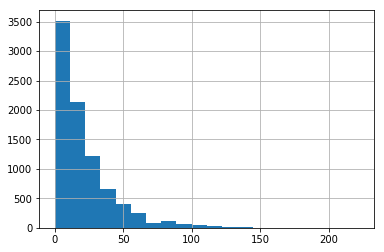

In [31]:
profile["discount_avg_receive_to_view_time"].hist(bins=20);

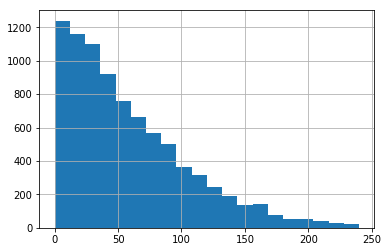

In [32]:
profile["discount_avg_view_to_complete_time"].hist(bins=20);

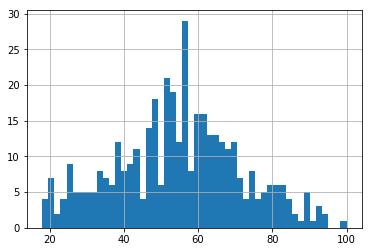

In [52]:
profile[(profile["discount_weak_positive_response"] == 1)]["age"].hist(bins=50);

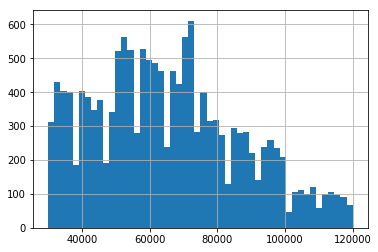

In [54]:
profile["income"].hist(bins=50);

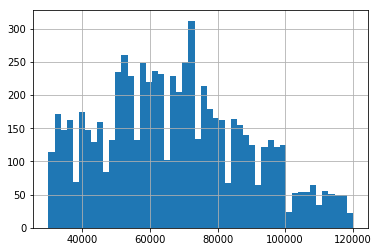

In [46]:
profile[(profile["discount_strong_positive_response"] == 1)]["income"].hist(bins=50);

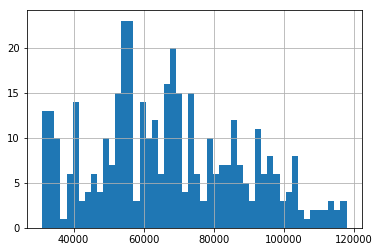

In [142]:
profile[(profile["discount_weak_positive_response"] == 1)]["income"].hist(bins=50);

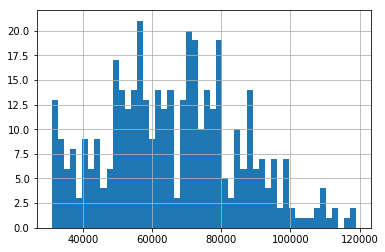

In [143]:
profile[(profile["discount_neutral_response"] == 1)]["income"].hist(bins=50);

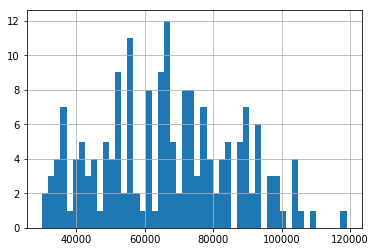

In [144]:
profile[(profile["discount_weak_negative_response"] == 1)]["income"].hist(bins=50);

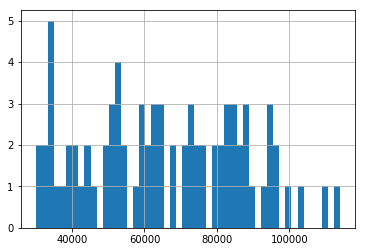

In [145]:
profile[(profile["discount_strong_negative_response"] == 1)]["income"].hist(bins=50);

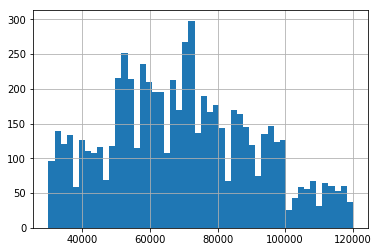

In [146]:
profile[(profile["bogo_strong_positive_response"] == 1)]["income"].hist(bins=50);

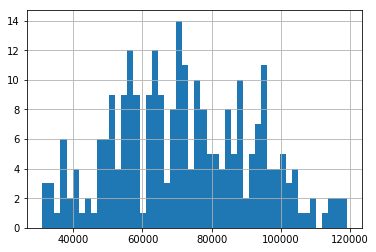

In [147]:
profile[(profile["bogo_weak_positive_response"] == 1)]["income"].hist(bins=50);

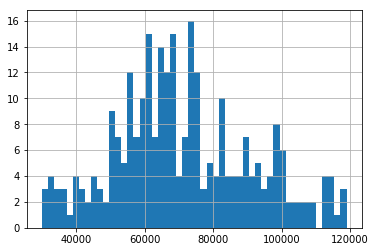

In [148]:
profile[(profile["bogo_neutral_response"] == 1)]["income"].hist(bins=50);

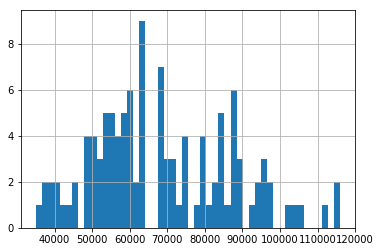

In [149]:
profile[(profile["bogo_weak_negative_response"] == 1)]["income"].hist(bins=50);

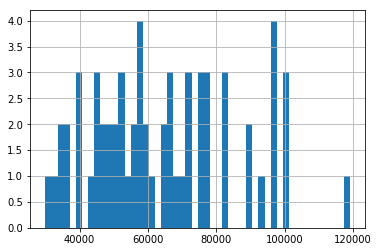

In [150]:
profile[(profile["bogo_strong_negative_response"] == 1)]["income"].hist(bins=50);

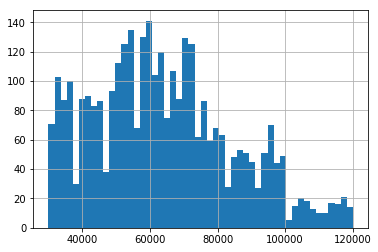

In [152]:
profile[(profile["informational_strong_positive_response"] == 1)]["income"].hist(bins=50);

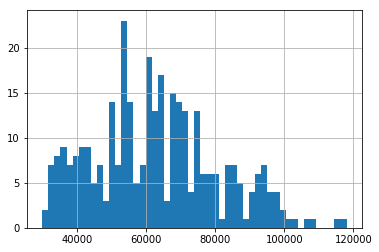

In [153]:
profile[(profile["informational_weak_positive_response"] == 1)]["income"].hist(bins=50);

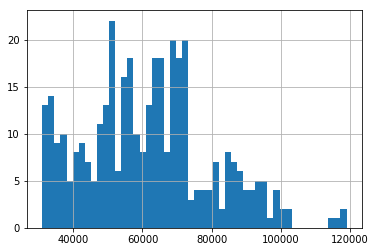

In [154]:
profile[(profile["informational_neutral_response"] == 1)]["income"].hist(bins=50);

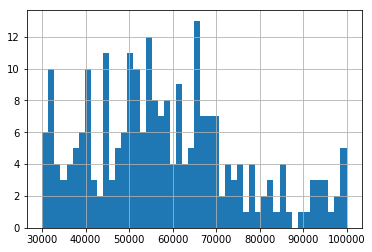

In [155]:
profile[(profile["informational_weak_negative_response"] == 1)]["income"].hist(bins=50);

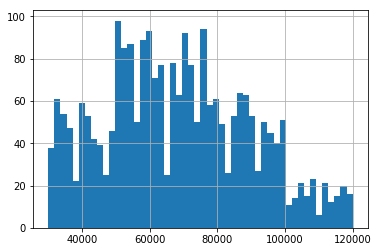

In [156]:
profile[(profile["informational_strong_negative_response"] == 1)]["income"].hist(bins=50);

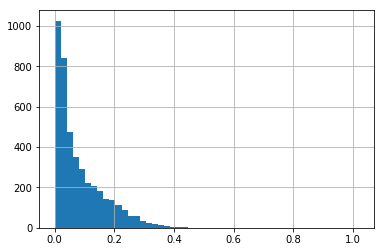

In [138]:
profile[(profile["income"] > 40000) & (profile["income"] < 60000)]["no_promotions_spending_per_hour"].hist(bins=50);

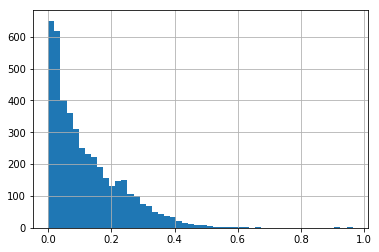

In [139]:
profile[(profile["income"] > 60000) & (profile["income"] < 80000)]["no_promotions_spending_per_hour"].hist(bins=50);

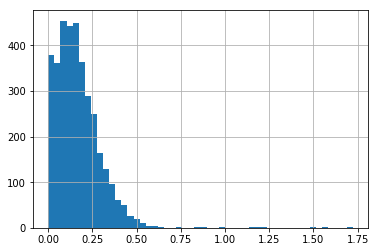

In [140]:
profile[(profile["income"] > 80000)]["no_promotions_spending_per_hour"].hist(bins=50);

In [60]:
profile[(profile["no_promotions_spending_per_hour"] > 0.7)]

,age,gender,id,income,tenure_length,joined_date,total_transaction_amount,total_reward_amount,discount_active_hours,bogo_active_hours,...,bogo_strong_positive_response,bogo_weak_positive_response,bogo_neutral_response,bogo_weak_negative_response,bogo_strong_negative_response,informational_strong_positive_response,informational_weak_positive_response,informational_neutral_response,informational_weak_negative_response,informational_strong_negative_response
739,50.0,M,7c8479d8241344f6a0c306621e191c75,51000.0,1763,2013-09-27,488.77,12.0,164,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
2681,58.0,F,6cf884a6c5ae4b2daccb6d3108028fef,110000.0,1085,2015-08-06,1165.26,13.0,0,14,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4044,63.0,F,72238c93bdfb4272a1f104a59ccc3a37,108000.0,241,2017-11-27,748.69,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
7785,60.0,M,ec8e29cea5e24a7d91896afb4c6c00c2,71000.0,202,2018-01-05,618.85,8.0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
8564,59.0,M,73adeca7df934d9a888ddfcdaad2dff0,71000.0,139,2018-03-09,693.80,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8697,71.0,F,9e523a3e05e14fd0bfec8ac108ce2cab,107000.0,50,2018-06-06,1035.01,2.0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
10138,66.0,M,ad1f0a409ae642bc9a43f31f56c130fc,80000.0,333,2017-08-27,1258.19,15.0,74,32,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11305,64.0,F,7a153a17d9754d3686c37684146fb681,106000.0,33,2018-06-23,902.94,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
12115,75.0,F,6d86fa31d7bb49a1be3197271181d5cf,98000.0,322,2017-09-07,703.89,10.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13634,37.0,M,c2390da2832148358ec29931c0487885,87000.0,271,2017-10-28,932.22,5.0,116,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0


In [64]:
profile[(profile["income"] > 80000)].iloc[0:20, 40:60]

,discount_to_no_promotions_spending_per_hour_ratio,bogo_to_no_promotions_spending_per_hour_ratio,informational_to_no_promotions_spending_per_hour_ratio,discount_strong_positive_response,discount_weak_positive_response,discount_neutral_response,discount_weak_negative_response,discount_strong_negative_response,bogo_strong_positive_response,bogo_weak_positive_response,bogo_neutral_response,bogo_weak_negative_response,bogo_strong_negative_response,informational_strong_positive_response,informational_weak_positive_response,informational_neutral_response,informational_weak_negative_response,informational_strong_negative_response
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.213729,12.855168,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21,23.013991,88.466039,4.498654,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25,17186.363636,178000.000000,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
30,3.012170,1.207477,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
33,NaN,2.660953,0.000000,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43,3.038681,NaN,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,7.386416,2.794545,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
58,1.447940,2.194066,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
65,1.132300,1.412418,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
